## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


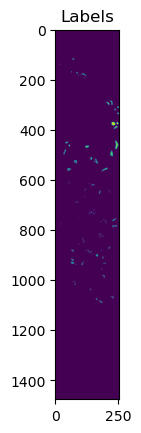

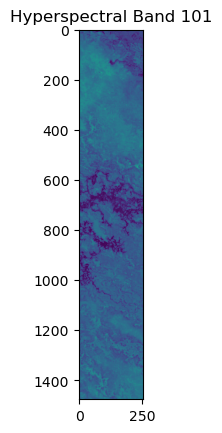

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
S


All datasets saved to the 'indices' folder.
(140, 5, 5, 145)
(70, 5, 5, 145)
(3038, 5, 5, 145)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 140
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2154, PSNR: -7.6869


Epoch [1/50] Training Loss: 0.2083, PSNR: -8.6551
	[Val]   Batch [1/11] Loss: 0.1999, PSNR: -6.0446
	[Val]   Batch [10/11] Loss: 0.2000, PSNR: -8.2835
Epoch [1/50] Validation Loss: 0.1999, PSNR: -7.9756

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.1938, PSNR: -7.4944


Epoch [2/50] Training Loss: 0.1858, PSNR: -8.4075
	[Val]   Batch [1/11] Loss: 0.1715, PSNR: -5.3787
	[Val]   Batch [10/11] Loss: 0.1717, PSNR: -7.6210
Epoch [2/50] Validation Loss: 0.1715, PSNR: -7.3099

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1734, PSNR: -9.6946


Epoch [3/50] Training Loss: 0.1647, PSNR: -7.5544
	[Val]   Batch [1/11] Loss: 0.1497, PSNR: -4.7878
	[Val]   Batch [10/11] Loss: 0.1498, PSNR: -7.0288
Epoch [3/50] Validation Loss: 0.1497, PSNR: -6.7201

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1508, PSNR: -7.7628


Epoch [4/50] Training Loss: 0.1446, PSNR: -7.0351
	[Val]   Batch [1/11] Loss: 0.1285, PSNR: -4.1249
	[Val]   Batch [10/11] Loss: 0.1286, PSNR: -6.3667
Epoch [4/50] Validation Loss: 0.1284, PSNR: -6.0541

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1335, PSNR: -7.7150


Epoch [5/50] Training Loss: 0.1258, PSNR: -6.4747
	[Val]   Batch [1/11] Loss: 0.1129, PSNR: -3.5648
	[Val]   Batch [10/11] Loss: 0.1130, PSNR: -5.8052
Epoch [5/50] Validation Loss: 0.1129, PSNR: -5.4938

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1139, PSNR: -6.5441


Epoch [6/50] Training Loss: 0.1087, PSNR: -5.8810
	[Val]   Batch [1/11] Loss: 0.0954, PSNR: -2.8344
	[Val]   Batch [10/11] Loss: 0.0955, PSNR: -5.0751
Epoch [6/50] Validation Loss: 0.0954, PSNR: -4.7647

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.0989, PSNR: -7.5460


Epoch [7/50] Training Loss: 0.0937, PSNR: -5.2286
	[Val]   Batch [1/11] Loss: 0.0840, PSNR: -2.2783
	[Val]   Batch [10/11] Loss: 0.0841, PSNR: -4.5188
Epoch [7/50] Validation Loss: 0.0840, PSNR: -4.2098

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0857, PSNR: -6.6969


Epoch [8/50] Training Loss: 0.0807, PSNR: -4.4578
	[Val]   Batch [1/11] Loss: 0.0721, PSNR: -1.6148
	[Val]   Batch [10/11] Loss: 0.0722, PSNR: -3.8560
Epoch [8/50] Validation Loss: 0.0721, PSNR: -3.5458

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0727, PSNR: -5.0757


Epoch [9/50] Training Loss: 0.0697, PSNR: -3.8712
	[Val]   Batch [1/11] Loss: 0.0642, PSNR: -1.1091
	[Val]   Batch [10/11] Loss: 0.0642, PSNR: -3.3503
Epoch [9/50] Validation Loss: 0.0641, PSNR: -3.0390

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0631, PSNR: -1.0400


Epoch [10/50] Training Loss: 0.0604, PSNR: -3.2965
	[Val]   Batch [1/11] Loss: 0.0551, PSNR: -0.4521
	[Val]   Batch [10/11] Loss: 0.0552, PSNR: -2.6925
Epoch [10/50] Validation Loss: 0.0551, PSNR: -2.3812

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0549, PSNR: -2.3680


Epoch [11/50] Training Loss: 0.0527, PSNR: -2.7238
	[Val]   Batch [1/11] Loss: 0.0490, PSNR: 0.0566
	[Val]   Batch [10/11] Loss: 0.0491, PSNR: -2.1819
Epoch [11/50] Validation Loss: 0.0490, PSNR: -1.8720

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0486, PSNR: -4.1661


Epoch [12/50] Training Loss: 0.0462, PSNR: -1.9932
	[Val]   Batch [1/11] Loss: 0.0431, PSNR: 0.6198
	[Val]   Batch [10/11] Loss: 0.0431, PSNR: -1.6191
Epoch [12/50] Validation Loss: 0.0431, PSNR: -1.3091

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0424, PSNR: -3.8844


Epoch [13/50] Training Loss: 0.0408, PSNR: -1.6991
	[Val]   Batch [1/11] Loss: 0.0390, PSNR: 1.0536
	[Val]   Batch [10/11] Loss: 0.0390, PSNR: -1.1850
Epoch [13/50] Validation Loss: 0.0390, PSNR: -0.8758

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0372, PSNR: -0.3271


Epoch [14/50] Training Loss: 0.0364, PSNR: -0.9702
	[Val]   Batch [1/11] Loss: 0.0343, PSNR: 1.6123
	[Val]   Batch [10/11] Loss: 0.0343, PSNR: -0.6274
Epoch [14/50] Validation Loss: 0.0343, PSNR: -0.3175

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0345, PSNR: -2.6819


Epoch [15/50] Training Loss: 0.0325, PSNR: -0.6690
	[Val]   Batch [1/11] Loss: 0.0314, PSNR: 1.9965
	[Val]   Batch [10/11] Loss: 0.0314, PSNR: -0.2431
Epoch [15/50] Validation Loss: 0.0314, PSNR: 0.0675

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0305, PSNR: 0.1874


Epoch [16/50] Training Loss: 0.0293, PSNR: -0.1345
	[Val]   Batch [1/11] Loss: 0.0284, PSNR: 2.4343
	[Val]   Batch [10/11] Loss: 0.0284, PSNR: 0.1951
Epoch [16/50] Validation Loss: 0.0284, PSNR: 0.5048

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0271, PSNR: 1.0416


Epoch [17/50] Training Loss: 0.0266, PSNR: 0.2921
	[Val]   Batch [1/11] Loss: 0.0255, PSNR: 2.9053
	[Val]   Batch [10/11] Loss: 0.0255, PSNR: 0.6646
Epoch [17/50] Validation Loss: 0.0254, PSNR: 0.9765

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0254, PSNR: 1.6023


Epoch [18/50] Training Loss: 0.0242, PSNR: 0.5676
	[Val]   Batch [1/11] Loss: 0.0237, PSNR: 3.2239
	[Val]   Batch [10/11] Loss: 0.0237, PSNR: 0.9828
Epoch [18/50] Validation Loss: 0.0236, PSNR: 1.2951

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0226, PSNR: -0.5130


Epoch [19/50] Training Loss: 0.0221, PSNR: 1.1872
	[Val]   Batch [1/11] Loss: 0.0216, PSNR: 3.6249
	[Val]   Batch [10/11] Loss: 0.0216, PSNR: 1.3836
Epoch [19/50] Validation Loss: 0.0216, PSNR: 1.6960

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0211, PSNR: 0.7909


Epoch [20/50] Training Loss: 0.0203, PSNR: 1.2009
	[Val]   Batch [1/11] Loss: 0.0198, PSNR: 4.0048
	[Val]   Batch [10/11] Loss: 0.0198, PSNR: 1.7638
Epoch [20/50] Validation Loss: 0.0197, PSNR: 2.0767

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0196, PSNR: 2.0944


Epoch [21/50] Training Loss: 0.0187, PSNR: 1.7738
	[Val]   Batch [1/11] Loss: 0.0184, PSNR: 4.3160
	[Val]   Batch [10/11] Loss: 0.0184, PSNR: 2.0758
Epoch [21/50] Validation Loss: 0.0184, PSNR: 2.3878

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0179, PSNR: 2.7884


Epoch [22/50] Training Loss: 0.0173, PSNR: 2.1496
	[Val]   Batch [1/11] Loss: 0.0171, PSNR: 4.6398
	[Val]   Batch [10/11] Loss: 0.0171, PSNR: 2.4004
Epoch [22/50] Validation Loss: 0.0171, PSNR: 2.7113

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0164, PSNR: 0.8771


Epoch [23/50] Training Loss: 0.0161, PSNR: 2.3788
	[Val]   Batch [1/11] Loss: 0.0158, PSNR: 4.9774
	[Val]   Batch [10/11] Loss: 0.0158, PSNR: 2.7371
Epoch [23/50] Validation Loss: 0.0158, PSNR: 3.0495

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0153, PSNR: 2.8917


Epoch [24/50] Training Loss: 0.0149, PSNR: 2.7208
	[Val]   Batch [1/11] Loss: 0.0147, PSNR: 5.2871
	[Val]   Batch [10/11] Loss: 0.0147, PSNR: 3.0458
Epoch [24/50] Validation Loss: 0.0147, PSNR: 3.3597

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0144, PSNR: 1.1598


Epoch [25/50] Training Loss: 0.0139, PSNR: 2.8712
	[Val]   Batch [1/11] Loss: 0.0137, PSNR: 5.5850
	[Val]   Batch [10/11] Loss: 0.0138, PSNR: 3.3435
Epoch [25/50] Validation Loss: 0.0137, PSNR: 3.6572

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0134, PSNR: 3.1182


Epoch [26/50] Training Loss: 0.0130, PSNR: 3.2725
	[Val]   Batch [1/11] Loss: 0.0129, PSNR: 5.8580
	[Val]   Batch [10/11] Loss: 0.0129, PSNR: 3.6172
Epoch [26/50] Validation Loss: 0.0129, PSNR: 3.9294

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0127, PSNR: 2.5040


Epoch [27/50] Training Loss: 0.0122, PSNR: 3.5038
	[Val]   Batch [1/11] Loss: 0.0120, PSNR: 6.1784
	[Val]   Batch [10/11] Loss: 0.0120, PSNR: 3.9380
Epoch [27/50] Validation Loss: 0.0120, PSNR: 4.2504

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0119, PSNR: 6.2216


Epoch [28/50] Training Loss: 0.0114, PSNR: 3.8859
	[Val]   Batch [1/11] Loss: 0.0113, PSNR: 6.4240
	[Val]   Batch [10/11] Loss: 0.0113, PSNR: 4.1830
Epoch [28/50] Validation Loss: 0.0113, PSNR: 4.4958

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0107, PSNR: 2.7432


Epoch [29/50] Training Loss: 0.0107, PSNR: 4.1501
	[Val]   Batch [1/11] Loss: 0.0107, PSNR: 6.6804
	[Val]   Batch [10/11] Loss: 0.0107, PSNR: 4.4396
Epoch [29/50] Validation Loss: 0.0107, PSNR: 4.7520

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0102, PSNR: 5.5588


Epoch [30/50] Training Loss: 0.0101, PSNR: 4.5703
	[Val]   Batch [1/11] Loss: 0.0101, PSNR: 6.9323
	[Val]   Batch [10/11] Loss: 0.0101, PSNR: 4.6913
Epoch [30/50] Validation Loss: 0.0101, PSNR: 5.0042

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0098, PSNR: 2.8422


Epoch [31/50] Training Loss: 0.0095, PSNR: 4.6970
	[Val]   Batch [1/11] Loss: 0.0095, PSNR: 7.1699
	[Val]   Batch [10/11] Loss: 0.0095, PSNR: 4.9293
Epoch [31/50] Validation Loss: 0.0095, PSNR: 5.2421

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0093, PSNR: 4.2477


Epoch [32/50] Training Loss: 0.0090, PSNR: 4.8080
	[Val]   Batch [1/11] Loss: 0.0090, PSNR: 7.4393
	[Val]   Batch [10/11] Loss: 0.0090, PSNR: 5.1982
Epoch [32/50] Validation Loss: 0.0090, PSNR: 5.5119

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0085, PSNR: 5.7117


Epoch [33/50] Training Loss: 0.0085, PSNR: 5.0683
	[Val]   Batch [1/11] Loss: 0.0085, PSNR: 7.6872
	[Val]   Batch [10/11] Loss: 0.0085, PSNR: 5.4457
Epoch [33/50] Validation Loss: 0.0085, PSNR: 5.7605

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0083, PSNR: 4.0569


Epoch [34/50] Training Loss: 0.0081, PSNR: 5.4852
	[Val]   Batch [1/11] Loss: 0.0081, PSNR: 7.8783
	[Val]   Batch [10/11] Loss: 0.0081, PSNR: 5.6379
Epoch [34/50] Validation Loss: 0.0081, PSNR: 5.9525

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0079, PSNR: 6.0689


Epoch [35/50] Training Loss: 0.0077, PSNR: 5.7310
	[Val]   Batch [1/11] Loss: 0.0077, PSNR: 8.1179
	[Val]   Batch [10/11] Loss: 0.0077, PSNR: 5.8776
Epoch [35/50] Validation Loss: 0.0077, PSNR: 6.1920

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0077, PSNR: 5.0689


Epoch [36/50] Training Loss: 0.0073, PSNR: 5.9750
	[Val]   Batch [1/11] Loss: 0.0073, PSNR: 8.3479
	[Val]   Batch [10/11] Loss: 0.0073, PSNR: 6.1073
Epoch [36/50] Validation Loss: 0.0073, PSNR: 6.4222

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0073, PSNR: 4.4158


Epoch [37/50] Training Loss: 0.0069, PSNR: 6.1910
	[Val]   Batch [1/11] Loss: 0.0069, PSNR: 8.5499
	[Val]   Batch [10/11] Loss: 0.0069, PSNR: 6.3092
Epoch [37/50] Validation Loss: 0.0069, PSNR: 6.6243

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0066, PSNR: 4.2574


Epoch [38/50] Training Loss: 0.0066, PSNR: 6.0975
	[Val]   Batch [1/11] Loss: 0.0066, PSNR: 8.7697
	[Val]   Batch [10/11] Loss: 0.0066, PSNR: 6.5296
Epoch [38/50] Validation Loss: 0.0066, PSNR: 6.8440

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0066, PSNR: 4.8176


Epoch [39/50] Training Loss: 0.0063, PSNR: 6.4353
	[Val]   Batch [1/11] Loss: 0.0063, PSNR: 8.9535
	[Val]   Batch [10/11] Loss: 0.0063, PSNR: 6.7135
Epoch [39/50] Validation Loss: 0.0063, PSNR: 7.0281

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0062, PSNR: 6.1656


Epoch [40/50] Training Loss: 0.0060, PSNR: 6.8574
	[Val]   Batch [1/11] Loss: 0.0060, PSNR: 9.1584
	[Val]   Batch [10/11] Loss: 0.0060, PSNR: 6.9181
Epoch [40/50] Validation Loss: 0.0060, PSNR: 7.2332

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0056, PSNR: 9.4939


Epoch [41/50] Training Loss: 0.0058, PSNR: 7.0576
	[Val]   Batch [1/11] Loss: 0.0058, PSNR: 9.3364
	[Val]   Batch [10/11] Loss: 0.0058, PSNR: 7.0972
Epoch [41/50] Validation Loss: 0.0058, PSNR: 7.4117

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0055, PSNR: 5.3199


Epoch [42/50] Training Loss: 0.0055, PSNR: 7.0801
	[Val]   Batch [1/11] Loss: 0.0055, PSNR: 9.5276
	[Val]   Batch [10/11] Loss: 0.0055, PSNR: 7.2892
Epoch [42/50] Validation Loss: 0.0055, PSNR: 7.6034

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0052, PSNR: 7.8807


Epoch [43/50] Training Loss: 0.0053, PSNR: 7.1336
	[Val]   Batch [1/11] Loss: 0.0053, PSNR: 9.7177
	[Val]   Batch [10/11] Loss: 0.0053, PSNR: 7.4793
Epoch [43/50] Validation Loss: 0.0053, PSNR: 7.7939

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0051, PSNR: 7.9700


Epoch [44/50] Training Loss: 0.0051, PSNR: 7.4950
	[Val]   Batch [1/11] Loss: 0.0051, PSNR: 9.8944
	[Val]   Batch [10/11] Loss: 0.0051, PSNR: 7.6560
Epoch [44/50] Validation Loss: 0.0051, PSNR: 7.9708

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0050, PSNR: 5.6673


Epoch [45/50] Training Loss: 0.0049, PSNR: 7.6552
	[Val]   Batch [1/11] Loss: 0.0049, PSNR: 10.0473
	[Val]   Batch [10/11] Loss: 0.0049, PSNR: 7.8083
Epoch [45/50] Validation Loss: 0.0049, PSNR: 8.1237

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0048, PSNR: 6.6852


Epoch [46/50] Training Loss: 0.0047, PSNR: 7.7414
	[Val]   Batch [1/11] Loss: 0.0047, PSNR: 10.2406
	[Val]   Batch [10/11] Loss: 0.0047, PSNR: 8.0015
Epoch [46/50] Validation Loss: 0.0047, PSNR: 8.3166

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0044, PSNR: 6.3074


Epoch [47/50] Training Loss: 0.0045, PSNR: 8.0546
	[Val]   Batch [1/11] Loss: 0.0045, PSNR: 10.4186
	[Val]   Batch [10/11] Loss: 0.0045, PSNR: 8.1795
Epoch [47/50] Validation Loss: 0.0045, PSNR: 8.4949

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0043, PSNR: 10.6035


Epoch [48/50] Training Loss: 0.0043, PSNR: 8.1890
	[Val]   Batch [1/11] Loss: 0.0044, PSNR: 10.5595
	[Val]   Batch [10/11] Loss: 0.0044, PSNR: 8.3208
Epoch [48/50] Validation Loss: 0.0044, PSNR: 8.6362

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0044, PSNR: 8.9526


Epoch [49/50] Training Loss: 0.0042, PSNR: 8.1888
	[Val]   Batch [1/11] Loss: 0.0042, PSNR: 10.7570
	[Val]   Batch [10/11] Loss: 0.0042, PSNR: 8.5179
Epoch [49/50] Validation Loss: 0.0042, PSNR: 8.8337

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0041, PSNR: 10.7955


Epoch [50/50] Training Loss: 0.0040, PSNR: 8.3492
	[Val]   Batch [1/11] Loss: 0.0040, PSNR: 10.9090
	[Val]   Batch [10/11] Loss: 0.0040, PSNR: 8.6705
Epoch [50/50] Validation Loss: 0.0040, PSNR: 8.9861


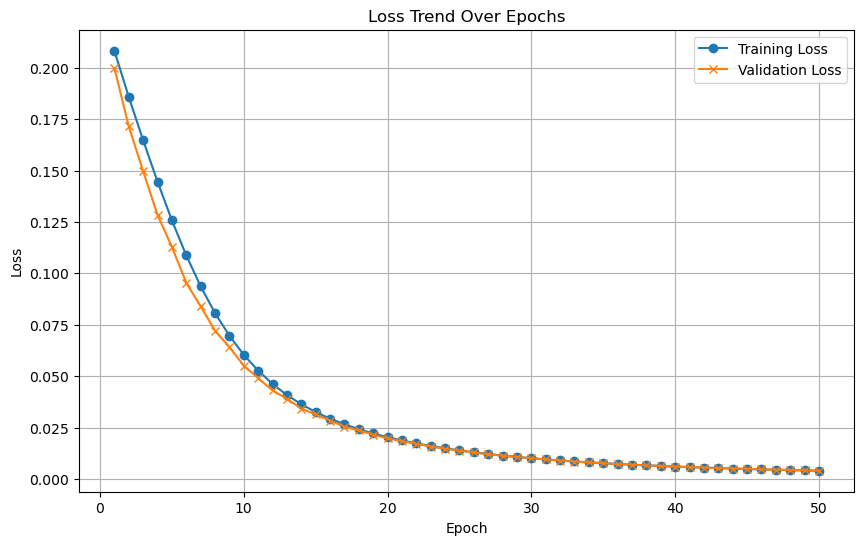

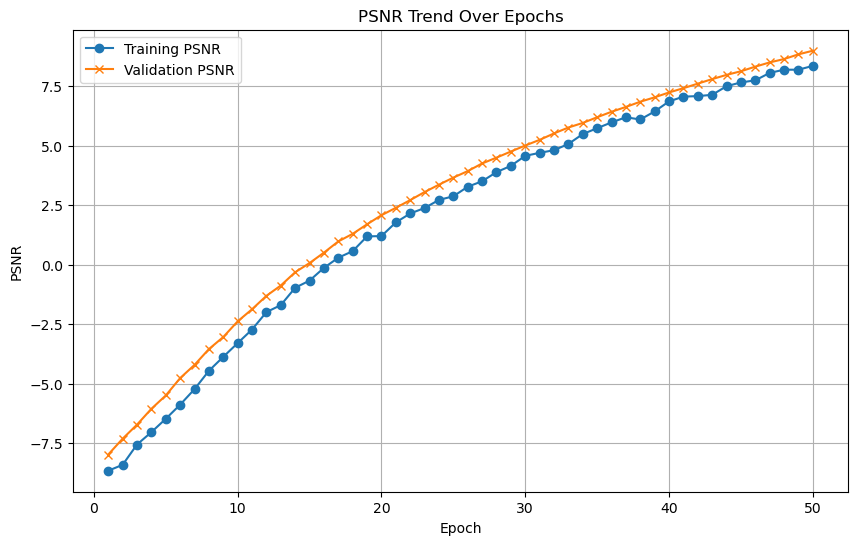

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/12 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6215
    Validation Batch [1/1], Loss: 2.6459
Validation Loss: 2.6459, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6459. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5869
    Validation Batch [1/1], Loss: 2.6459
Validation Loss: 2.6459, Validation Accuracy: 7.14%
Validation loss improved from 2.6459 to 2.6459. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5566
    Validation Batch [1/1], Loss: 2.6458
Validation Loss: 2.6458, Validation Accuracy: 7.14%
Validation loss improved from 2.6459 to 2.6458. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5397
    Validation Batch [1/1], Loss: 2.6457
Validation Loss: 2.6457, Validation Accuracy: 7.14%
Validation loss improved from 2.6458 to 2.6457. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] complete

    Validation Batch [1/1], Loss: 2.6451
Validation Loss: 2.6451, Validation Accuracy: 7.14%
Validation loss improved from 2.6452 to 2.6451. Saving model...

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.3188
    Validation Batch [1/1], Loss: 2.6450
Validation Loss: 2.6450, Validation Accuracy: 7.14%
Validation loss improved from 2.6451 to 2.6450. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.3014
    Validation Batch [1/1], Loss: 2.6450
Validation Loss: 2.6450, Validation Accuracy: 7.14%
Validation loss improved from 2.6450 to 2.6450. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.2917
    Validation Batch [1/1], Loss: 2.6449
Validation Loss: 2.6449, Validation Accuracy: 7.14%
Validation loss improved from 2.6450 to 2.6449. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.2884
    Validati

Epoch [25/1000] completed, Average Training Loss: 2.2775
    Validation Batch [1/1], Loss: 2.6448
Validation Loss: 2.6448, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.2328
    Validation Batch [1/1], Loss: 2.6448
Validation Loss: 2.6448, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 2.2286
    Validation Batch [1/1], Loss: 2.6448
Validation Loss: 2.6448, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [28/1000] - Training
Epoch [28/1000] completed, Average Training Loss: 2.2496
    Validation Batch [1/1], Loss: 2.6449
Validation Loss: 2.6449, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [29/1000] - Training
Epoch [29/1000] completed, Average Training Loss: 2.2518
    Validation 

Epoch [48/1000] completed, Average Training Loss: 2.0745
    Validation Batch [1/1], Loss: 2.6407
Validation Loss: 2.6407, Validation Accuracy: 11.43%
Validation loss improved from 2.6412 to 2.6407. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 2.0487
    Validation Batch [1/1], Loss: 2.6397
Validation Loss: 2.6397, Validation Accuracy: 14.29%
Validation loss improved from 2.6407 to 2.6397. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 2.0180
    Validation Batch [1/1], Loss: 2.6382
Validation Loss: 2.6382, Validation Accuracy: 14.29%
Validation loss improved from 2.6397 to 2.6382. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 2.0397
    Validation Batch [1/1], Loss: 2.6371
Validation Loss: 2.6371, Validation Accuracy: 14.29%
Validation loss improved from 2.6382 to 2.6371. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [5

Epoch [54/1000] completed, Average Training Loss: 2.0311
    Validation Batch [1/1], Loss: 2.6310
Validation Loss: 2.6310, Validation Accuracy: 14.29%
Validation loss improved from 2.6340 to 2.6310. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 2.0130
    Validation Batch [1/1], Loss: 2.6277
Validation Loss: 2.6277, Validation Accuracy: 14.29%
Validation loss improved from 2.6310 to 2.6277. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 1.9692
    Validation Batch [1/1], Loss: 2.6246
Validation Loss: 2.6246, Validation Accuracy: 14.29%
Validation loss improved from 2.6277 to 2.6246. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 1.9790
    Validation Batch [1/1], Loss: 2.6214
Validation Loss: 2.6214, Validation Accuracy: 12.86%
Validation loss improved from 2.6246 to 2.6214. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [5

Epoch [78/1000] completed, Average Training Loss: 1.7790


    Validation Batch [1/1], Loss: 2.2482
Validation Loss: 2.2482, Validation Accuracy: 40.00%
Validation loss improved from 2.2760 to 2.2482. Saving model...

LOG: Epoch [79/1000] - Training
Epoch [79/1000] completed, Average Training Loss: 1.8021
    Validation Batch [1/1], Loss: 2.2239
Validation Loss: 2.2239, Validation Accuracy: 40.00%
Validation loss improved from 2.2482 to 2.2239. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 1.8139
    Validation Batch [1/1], Loss: 2.1925
Validation Loss: 2.1925, Validation Accuracy: 40.00%
Validation loss improved from 2.2239 to 2.1925. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 1.7881
    Validation Batch [1/1], Loss: 2.1662
Validation Loss: 2.1662, Validation Accuracy: 41.43%
Validation loss improved from 2.1925 to 2.1662. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.7779
    Vali

    Validation Batch [1/1], Loss: 1.7695
Validation Loss: 1.7695, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [106/1000] - Training
Epoch [106/1000] completed, Average Training Loss: 1.5951
    Validation Batch [1/1], Loss: 1.7948
Validation Loss: 1.7948, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [107/1000] - Training
Epoch [107/1000] completed, Average Training Loss: 1.5989
    Validation Batch [1/1], Loss: 1.7508
Validation Loss: 1.7508, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 1.5761
    Validation Batch [1/1], Loss: 1.6989
Validation Loss: 1.6989, Validation Accuracy: 71.43%
Validation loss improved from 1.7298 to 1.6989. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 1.5695
    Validation Batch [1/1], Loss: 1.6899
Vali

Epoch [134/1000] completed, Average Training Loss: 1.3589
    Validation Batch [1/1], Loss: 1.4913
Validation Loss: 1.4913, Validation Accuracy: 87.14%
Validation loss improved from 1.4961 to 1.4913. Saving model...

LOG: Epoch [135/1000] - Training
Epoch [135/1000] completed, Average Training Loss: 1.3551
    Validation Batch [1/1], Loss: 1.4806
Validation Loss: 1.4806, Validation Accuracy: 88.57%
Validation loss improved from 1.4913 to 1.4806. Saving model...

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training Loss: 1.3646
    Validation Batch [1/1], Loss: 1.4944
Validation Loss: 1.4944, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 1.3273
    Validation Batch [1/1], Loss: 1.4850
Validation Loss: 1.4850, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [138/1000] - Training
Epoch [138/1000] completed, Av

    Validation Batch [1/1], Loss: 1.3084
Validation Loss: 1.3084, Validation Accuracy: 94.29%
Validation loss improved from 1.3194 to 1.3084. Saving model...

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 1.1669
    Validation Batch [1/1], Loss: 1.3133
Validation Loss: 1.3133, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 1.1445
    Validation Batch [1/1], Loss: 1.3065
Validation Loss: 1.3065, Validation Accuracy: 92.86%
Validation loss improved from 1.3084 to 1.3065. Saving model...

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training Loss: 1.1267
    Validation Batch [1/1], Loss: 1.3089
Validation Loss: 1.3089, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 1.1074
    Validation Batch [1/1], Lo

Epoch [191/1000] completed, Average Training Loss: 0.9487
    Validation Batch [1/1], Loss: 1.0939
Validation Loss: 1.0939, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 0.9112
    Validation Batch [1/1], Loss: 1.0715
Validation Loss: 1.0715, Validation Accuracy: 91.43%
Validation loss improved from 1.0820 to 1.0715. Saving model...

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 0.9015
    Validation Batch [1/1], Loss: 1.0679
Validation Loss: 1.0679, Validation Accuracy: 95.71%
Validation loss improved from 1.0715 to 1.0679. Saving model...

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training Loss: 0.9176
    Validation Batch [1/1], Loss: 1.0798
Validation Loss: 1.0798, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [195/1000] - Training
Epoch [195/1000] completed, Av

Epoch [219/1000] completed, Average Training Loss: 0.6848
    Validation Batch [1/1], Loss: 0.8620
Validation Loss: 0.8620, Validation Accuracy: 90.00%
Validation loss improved from 0.8732 to 0.8620. Saving model...

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.7112
    Validation Batch [1/1], Loss: 0.8685
Validation Loss: 0.8685, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.7153
    Validation Batch [1/1], Loss: 0.8672
Validation Loss: 0.8672, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [222/1000] - Training
Epoch [222/1000] completed, Average Training Loss: 0.7304
    Validation Batch [1/1], Loss: 0.8581
Validation Loss: 0.8581, Validation Accuracy: 91.43%
Validation loss improved from 0.8620 to 0.8581. Saving model...

LOG: Epoch [223/1000] - Training
Epoch [223/1000] completed, Av

Epoch [249/1000] completed, Average Training Loss: 0.5677
    Validation Batch [1/1], Loss: 0.6996
Validation Loss: 0.6996, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.5781
    Validation Batch [1/1], Loss: 0.6864
Validation Loss: 0.6864, Validation Accuracy: 94.29%
Validation loss improved from 0.6955 to 0.6864. Saving model...

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.5400
    Validation Batch [1/1], Loss: 0.6802
Validation Loss: 0.6802, Validation Accuracy: 92.86%
Validation loss improved from 0.6864 to 0.6802. Saving model...

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.5509
    Validation Batch [1/1], Loss: 0.6696
Validation Loss: 0.6696, Validation Accuracy: 91.43%
Validation loss improved from 0.6802 to 0.6696. Saving model...

LOG: Epoch [253/1000] - Training
Epoch [253/1000

Epoch [277/1000] completed, Average Training Loss: 0.3918
    Validation Batch [1/1], Loss: 0.5560
Validation Loss: 0.5560, Validation Accuracy: 91.43%
Validation loss improved from 0.5643 to 0.5560. Saving model...

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.3790
    Validation Batch [1/1], Loss: 0.5653
Validation Loss: 0.5653, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.3647
    Validation Batch [1/1], Loss: 0.5984
Validation Loss: 0.5984, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [280/1000] - Training
Epoch [280/1000] completed, Average Training Loss: 0.3847
    Validation Batch [1/1], Loss: 0.5677
Validation Loss: 0.5677, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.4688
Validation Loss: 0.4688, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.3247
    Validation Batch [1/1], Loss: 0.4805
Validation Loss: 0.4805, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training Loss: 0.3160
    Validation Batch [1/1], Loss: 0.4707
Validation Loss: 0.4707, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [309/1000] - Training
Epoch [309/1000] completed, Average Training Loss: 0.2693
    Validation Batch [1/1], Loss: 0.4611
Validation Loss: 0.4611, Validation Accuracy: 91.43%
Validation loss improved from 0.4639 to 0.4611. Saving model...

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.2840
    Validation Batch [1/1], Loss: 0.4585
Vali

    Validation Batch [1/1], Loss: 0.4150
Validation Loss: 0.4150, Validation Accuracy: 92.86%
Validation loss improved from 0.4196 to 0.4150. Saving model...

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.2847
    Validation Batch [1/1], Loss: 0.4140
Validation Loss: 0.4140, Validation Accuracy: 91.43%
Validation loss improved from 0.4150 to 0.4140. Saving model...

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.2389
    Validation Batch [1/1], Loss: 0.4151
Validation Loss: 0.4151, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.2223
    Validation Batch [1/1], Loss: 0.4086
Validation Loss: 0.4086, Validation Accuracy: 92.86%
Validation loss improved from 0.4140 to 0.4086. Saving model...

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.2324
    Validation 

Epoch [363/1000] completed, Average Training Loss: 0.1835
    Validation Batch [1/1], Loss: 0.3896
Validation Loss: 0.3896, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training Loss: 0.2285
    Validation Batch [1/1], Loss: 0.3807
Validation Loss: 0.3807, Validation Accuracy: 90.00%
Validation loss improved from 0.3814 to 0.3807. Saving model...

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.1859
    Validation Batch [1/1], Loss: 0.3767
Validation Loss: 0.3767, Validation Accuracy: 91.43%
Validation loss improved from 0.3807 to 0.3767. Saving model...

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.1827
    Validation Batch [1/1], Loss: 0.3875
Validation Loss: 0.3875, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Av

Epoch [392/1000] completed, Average Training Loss: 0.1595
    Validation Batch [1/1], Loss: 0.3443
Validation Loss: 0.3443, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [393/1000] - Training
Epoch [393/1000] completed, Average Training Loss: 0.1440
    Validation Batch [1/1], Loss: 0.3423
Validation Loss: 0.3423, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [394/1000] - Training
Epoch [394/1000] completed, Average Training Loss: 0.1553
    Validation Batch [1/1], Loss: 0.3401
Validation Loss: 0.3401, Validation Accuracy: 91.43%
Validation loss improved from 0.3416 to 0.3401. Saving model...

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training Loss: 0.1617
    Validation Batch [1/1], Loss: 0.3439
Validation Loss: 0.3439, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.3798
Validation Loss: 0.3798, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [421/1000] - Training
Epoch [421/1000] completed, Average Training Loss: 0.1319
    Validation Batch [1/1], Loss: 0.3520
Validation Loss: 0.3520, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [422/1000] - Training
Epoch [422/1000] completed, Average Training Loss: 0.1366
    Validation Batch [1/1], Loss: 0.3339
Validation Loss: 0.3339, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.1130
    Validation Batch [1/1], Loss: 0.3326
Validation Loss: 0.3326, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1346
    Validation Batch [1/1], Loss: 0.3201
Validation Loss: 0.

    Validation Batch [1/1], Loss: 0.3169
Validation Loss: 0.3169, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [450/1000] - Training
Epoch [450/1000] completed, Average Training Loss: 0.1094
    Validation Batch [1/1], Loss: 0.3199
Validation Loss: 0.3199, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [451/1000] - Training
Epoch [451/1000] completed, Average Training Loss: 0.1055
    Validation Batch [1/1], Loss: 0.3103
Validation Loss: 0.3103, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.1122
    Validation Batch [1/1], Loss: 0.3053
Validation Loss: 0.3053, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.1109
    Validation Batch [1/1], Loss: 0.3024
Validation Loss: 0

Epoch [477/1000] completed, Average Training Loss: 0.0871
    Validation Batch [1/1], Loss: 0.2985
Validation Loss: 0.2985, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [478/1000] - Training
Epoch [478/1000] completed, Average Training Loss: 0.0799
    Validation Batch [1/1], Loss: 0.3105
Validation Loss: 0.3105, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [479/1000] - Training
Epoch [479/1000] completed, Average Training Loss: 0.0929
    Validation Batch [1/1], Loss: 0.3086
Validation Loss: 0.3086, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [480/1000] - Training
Epoch [480/1000] completed, Average Training Loss: 0.0910
    Validation Batch [1/1], Loss: 0.2997
Validation Loss: 0.2997, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [481/1000] - Training
Epoch [481/1000] completed, Average Training Loss: 0.090

    Validation Batch [1/1], Loss: 0.2967
Validation Loss: 0.2967, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [505/1000] - Training
Epoch [505/1000] completed, Average Training Loss: 0.0956
    Validation Batch [1/1], Loss: 0.2896
Validation Loss: 0.2896, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [506/1000] - Training
Epoch [506/1000] completed, Average Training Loss: 0.0781
    Validation Batch [1/1], Loss: 0.2847
Validation Loss: 0.2847, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [507/1000] - Training
Epoch [507/1000] completed, Average Training Loss: 0.0879
    Validation Batch [1/1], Loss: 0.2828
Validation Loss: 0.2828, Validation Accuracy: 91.43%
Validation loss improved from 0.2836 to 0.2828. Saving model...

LOG: Epoch [508/1000] - Training
Epoch [508/1000] completed, Average Training Loss: 0.0894
    Validation Batch [1/1], Loss: 0.2801
V

    Validation Batch [1/1], Loss: 0.2772
Validation Loss: 0.2772, Validation Accuracy: 94.29%
Validation loss improved from 0.2787 to 0.2772. Saving model...

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.0618
    Validation Batch [1/1], Loss: 0.2741
Validation Loss: 0.2741, Validation Accuracy: 91.43%
Validation loss improved from 0.2772 to 0.2741. Saving model...

LOG: Epoch [532/1000] - Training
Epoch [532/1000] completed, Average Training Loss: 0.0681
    Validation Batch [1/1], Loss: 0.2804
Validation Loss: 0.2804, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [533/1000] - Training
Epoch [533/1000] completed, Average Training Loss: 0.0683
    Validation Batch [1/1], Loss: 0.2796
Validation Loss: 0.2796, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [534/1000] - Training
Epoch [534/1000] completed, Average Training Loss: 0.0764
    Validation Batch [1/1], Lo

Epoch [559/1000] completed, Average Training Loss: 0.0493
    Validation Batch [1/1], Loss: 0.2755
Validation Loss: 0.2755, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0796
    Validation Batch [1/1], Loss: 0.2747
Validation Loss: 0.2747, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.0660
    Validation Batch [1/1], Loss: 0.2836
Validation Loss: 0.2836, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [562/1000] - Training
Epoch [562/1000] completed, Average Training Loss: 0.0619
    Validation Batch [1/1], Loss: 0.2869
Validation Loss: 0.2869, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [563/1000] - Training
Epoch [563/1000] completed, Average Training Loss: 0.052

Epoch [587/1000] completed, Average Training Loss: 0.0571
    Validation Batch [1/1], Loss: 0.2594
Validation Loss: 0.2594, Validation Accuracy: 92.86%
Validation loss improved from 0.2612 to 0.2594. Saving model...

LOG: Epoch [588/1000] - Training
Epoch [588/1000] completed, Average Training Loss: 0.0590
    Validation Batch [1/1], Loss: 0.2697
Validation Loss: 0.2697, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [589/1000] - Training
Epoch [589/1000] completed, Average Training Loss: 0.0507
    Validation Batch [1/1], Loss: 0.2922
Validation Loss: 0.2922, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [590/1000] - Training
Epoch [590/1000] completed, Average Training Loss: 0.0748
    Validation Batch [1/1], Loss: 0.3030
Validation Loss: 0.3030, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [591/1000] - Training
Epoch [591/1000] completed, Average Training 

Epoch [614/1000] completed, Average Training Loss: 0.0461
    Validation Batch [1/1], Loss: 0.2744
Validation Loss: 0.2744, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [615/1000] - Training
Epoch [615/1000] completed, Average Training Loss: 0.0545
    Validation Batch [1/1], Loss: 0.2765
Validation Loss: 0.2765, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [616/1000] - Training
Epoch [616/1000] completed, Average Training Loss: 0.0467
    Validation Batch [1/1], Loss: 0.2705
Validation Loss: 0.2705, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [617/1000] - Training
Epoch [617/1000] completed, Average Training Loss: 0.0653
    Validation Batch [1/1], Loss: 0.2595
Validation Loss: 0.2595, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [618/1000] - Training
Epoch [618/1000] completed, Average Training Loss: 0.055

Epoch [643/1000] completed, Average Training Loss: 0.0467
    Validation Batch [1/1], Loss: 0.2630
Validation Loss: 0.2630, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [644/1000] - Training
Epoch [644/1000] completed, Average Training Loss: 0.0503
    Validation Batch [1/1], Loss: 0.2663
Validation Loss: 0.2663, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [645/1000] - Training
Epoch [645/1000] completed, Average Training Loss: 0.0476
    Validation Batch [1/1], Loss: 0.2743
Validation Loss: 0.2743, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [646/1000] - Training
Epoch [646/1000] completed, Average Training Loss: 0.0580
    Validation Batch [1/1], Loss: 0.2719
Validation Loss: 0.2719, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [647/1000] - Training
Epoch [647/1000] completed, Average Training Loss: 0.046

Epoch [671/1000] completed, Average Training Loss: 0.0437
    Validation Batch [1/1], Loss: 0.2442
Validation Loss: 0.2442, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [672/1000] - Training
Epoch [672/1000] completed, Average Training Loss: 0.0452
    Validation Batch [1/1], Loss: 0.2443
Validation Loss: 0.2443, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [673/1000] - Training
Epoch [673/1000] completed, Average Training Loss: 0.0351
    Validation Batch [1/1], Loss: 0.2485
Validation Loss: 0.2485, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [674/1000] - Training
Epoch [674/1000] completed, Average Training Loss: 0.0408
    Validation Batch [1/1], Loss: 0.2525
Validation Loss: 0.2525, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [675/1000] - Training
Epoch [675/1000] completed, Average Training Loss: 0.044

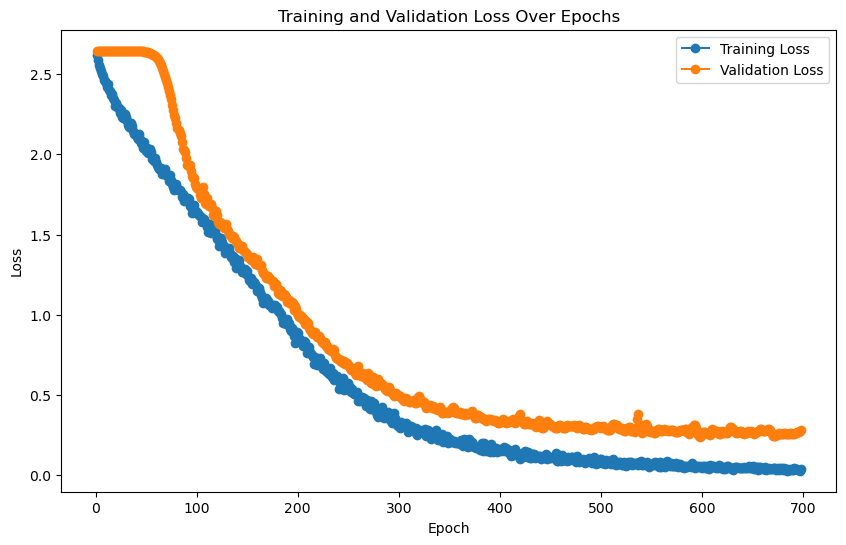

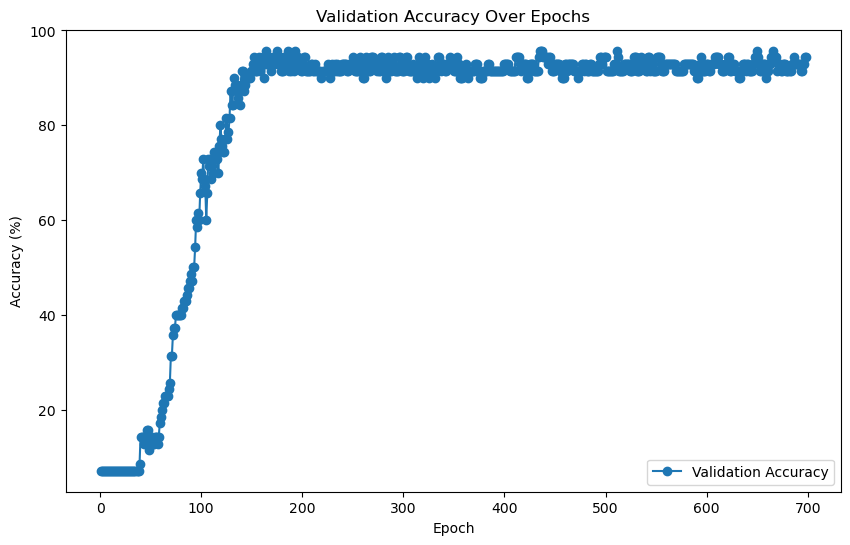


Evaluating on the test set...
    Test Batch [1/12], Loss: 0.0690

Final Test Loss: 0.1937, Test Accuracy: 94.80%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)

LOG: Training features shape: (140, 64), Training labels shape: (140,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (3038, 64), Test labels shape: (3038,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 61.43%

Validation Classification Report:
               precision    recall  f1

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)
Train reps shape: (140, 64)
Train labels shape: (140,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (3038, 64)
Test labels shape: (3038,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6411  |  Val Loss: 2.6127
Validation loss improved from inf to 2.6127.
[Epoch 2/1000] Train Loss: 2.6184  |  Val Loss: 2.6091
Validation loss improved from 2.6127 to 2.6091.
[Epoch 3/1000] Train Loss: 2.6090  |  Val Loss: 2.5996
Validation loss improved from 2.6091 to 2.5996.
[Epoch 4/1000] Train Loss: 2.5973  |  Val Loss: 2.5865
Validation loss improved from 2.5996 to 2.5865.
[Epoch 5/1000] Train Loss: 2.5871  |  Val Loss: 2.5778
Validation loss improved from 2.5865 to 2.5778.
[Epoch 6/1000] Train Loss: 2.5791  |  Val Loss: 2.5688
Validation loss improved from 2.5778 to 2.5688.


[Epoch 7/1000] Train Loss: 2.5698  |  Val Loss: 2.5566
Validation loss improved from 2.5688 to 2.5566.
[Epoch 8/1000] Train Loss: 2.5567  |  Val Loss: 2.5438
Validation loss improved from 2.5566 to 2.5438.
[Epoch 9/1000] Train Loss: 2.5455  |  Val Loss: 2.5375
Validation loss improved from 2.5438 to 2.5375.
[Epoch 10/1000] Train Loss: 2.5397  |  Val Loss: 2.5276
Validation loss improved from 2.5375 to 2.5276.
[Epoch 11/1000] Train Loss: 2.5314  |  Val Loss: 2.5176
Validation loss improved from 2.5276 to 2.5176.
[Epoch 12/1000] Train Loss: 2.5192  |  Val Loss: 2.5007
Validation loss improved from 2.5176 to 2.5007.
[Epoch 13/1000] Train Loss: 2.5020  |  Val Loss: 2.4884
Validation loss improved from 2.5007 to 2.4884.
[Epoch 14/1000] Train Loss: 2.4909  |  Val Loss: 2.4731
Validation loss improved from 2.4884 to 2.4731.
[Epoch 15/1000] Train Loss: 2.4724  |  Val Loss: 2.4570
Validation loss improved from 2.4731 to 2.4570.
[Epoch 16/1000] Train Loss: 2.4590  |  Val Loss: 2.4429
Validation 

[Epoch 26/1000] Train Loss: 2.2624  |  Val Loss: 2.2364
Validation loss improved from 2.2624 to 2.2364.
[Epoch 27/1000] Train Loss: 2.2319  |  Val Loss: 2.2140
Validation loss improved from 2.2364 to 2.2140.
[Epoch 28/1000] Train Loss: 2.2067  |  Val Loss: 2.1888
Validation loss improved from 2.2140 to 2.1888.
[Epoch 29/1000] Train Loss: 2.1858  |  Val Loss: 2.1646
Validation loss improved from 2.1888 to 2.1646.
[Epoch 30/1000] Train Loss: 2.1606  |  Val Loss: 2.1430
Validation loss improved from 2.1646 to 2.1430.
[Epoch 31/1000] Train Loss: 2.1390  |  Val Loss: 2.1175
Validation loss improved from 2.1430 to 2.1175.
[Epoch 32/1000] Train Loss: 2.1112  |  Val Loss: 2.0915
Validation loss improved from 2.1175 to 2.0915.
[Epoch 33/1000] Train Loss: 2.0832  |  Val Loss: 2.0681
Validation loss improved from 2.0915 to 2.0681.
[Epoch 34/1000] Train Loss: 2.0599  |  Val Loss: 2.0395
Validation loss improved from 2.0681 to 2.0395.
[Epoch 35/1000] Train Loss: 2.0296  |  Val Loss: 2.0099
Validati

[Epoch 38/1000] Train Loss: 1.9508  |  Val Loss: 1.9371
Validation loss improved from 1.9650 to 1.9371.
[Epoch 39/1000] Train Loss: 1.9259  |  Val Loss: 1.9275
Validation loss improved from 1.9371 to 1.9275.
[Epoch 40/1000] Train Loss: 1.9126  |  Val Loss: 1.9000
Validation loss improved from 1.9275 to 1.9000.
[Epoch 41/1000] Train Loss: 1.8855  |  Val Loss: 1.8715
Validation loss improved from 1.9000 to 1.8715.
[Epoch 42/1000] Train Loss: 1.8597  |  Val Loss: 1.8467
Validation loss improved from 1.8715 to 1.8467.
[Epoch 43/1000] Train Loss: 1.8301  |  Val Loss: 1.8205
Validation loss improved from 1.8467 to 1.8205.
[Epoch 44/1000] Train Loss: 1.7998  |  Val Loss: 1.7940
Validation loss improved from 1.8205 to 1.7940.
[Epoch 45/1000] Train Loss: 1.7728  |  Val Loss: 1.7814
Validation loss improved from 1.7940 to 1.7814.
[Epoch 46/1000] Train Loss: 1.7546  |  Val Loss: 1.7457
Validation loss improved from 1.7814 to 1.7457.
[Epoch 47/1000] Train Loss: 1.7259  |  Val Loss: 1.7254
Validati

[Epoch 57/1000] Train Loss: 1.5576  |  Val Loss: 1.6039
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 58/1000] Train Loss: 1.5625  |  Val Loss: 1.5646
Validation loss improved from 1.5934 to 1.5646.
[Epoch 59/1000] Train Loss: 1.5227  |  Val Loss: 1.5425
Validation loss improved from 1.5646 to 1.5425.
[Epoch 60/1000] Train Loss: 1.5054  |  Val Loss: 1.5269
Validation loss improved from 1.5425 to 1.5269.
[Epoch 61/1000] Train Loss: 1.4772  |  Val Loss: 1.5136
Validation loss improved from 1.5269 to 1.5136.
[Epoch 62/1000] Train Loss: 1.4667  |  Val Loss: 1.5140
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 63/1000] Train Loss: 1.4589  |  Val Loss: 1.5039
Validation loss improved from 1.5136 to 1.5039.
[Epoch 64/1000] Train Loss: 1.4643  |  Val Loss: 1.5030
Validation loss improved from 1.5039 to 1.5030.
[Epoch 65/1000] Train Loss: 1.4549  |  Val Loss: 1.5053
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 66/1000] Train Loss: 1.4881  |  Val Los

[Epoch 70/1000] Train Loss: 1.3910  |  Val Loss: 1.4539
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 71/1000] Train Loss: 1.3832  |  Val Loss: 1.4375
Validation loss improved from 1.4524 to 1.4375.
[Epoch 72/1000] Train Loss: 1.3710  |  Val Loss: 1.4392
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 73/1000] Train Loss: 1.3687  |  Val Loss: 1.4553
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 74/1000] Train Loss: 1.3929  |  Val Loss: 1.4661
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 75/1000] Train Loss: 1.3746  |  Val Loss: 1.4254
Validation loss improved from 1.4375 to 1.4254.
[Epoch 76/1000] Train Loss: 1.3515  |  Val Loss: 1.4197
Validation loss improved from 1.4254 to 1.4197.
[Epoch 77/1000] Train Loss: 1.3442  |  Val Loss: 1.4008
Validation loss improved from 1.4197 to 1.4008.
[Epoch 78/1000] Train Loss: 1.3314  |  Val Loss: 1.3940
Validation loss improved from 1.4008 to 1.3940.
[Epoch 79/1000] Train Loss: 1.3107  |  V

[Epoch 92/1000] Train Loss: 1.2456  |  Val Loss: 1.3503
Validation loss improved from 1.3513 to 1.3503.
[Epoch 93/1000] Train Loss: 1.2441  |  Val Loss: 1.3473
Validation loss improved from 1.3503 to 1.3473.
[Epoch 94/1000] Train Loss: 1.2384  |  Val Loss: 1.3292
Validation loss improved from 1.3473 to 1.3292.
[Epoch 95/1000] Train Loss: 1.2271  |  Val Loss: 1.3436
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 96/1000] Train Loss: 1.2297  |  Val Loss: 1.3386
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 97/1000] Train Loss: 1.2232  |  Val Loss: 1.3290
Validation loss improved from 1.3292 to 1.3290.
[Epoch 98/1000] Train Loss: 1.2048  |  Val Loss: 1.3235
Validation loss improved from 1.3290 to 1.3235.
[Epoch 99/1000] Train Loss: 1.1936  |  Val Loss: 1.3336
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 100/1000] Train Loss: 1.2066  |  Val Loss: 1.3533
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 101/1000] Train Loss: 1.2081  |  Val Loss: 1.3205
Validation loss improved from 1.3235 to 1.3205.
[Epoch 102/1000] Train Loss: 1.1913  |  Val Loss: 1.3629
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 103/1000] Train Loss: 1.2262  |  Val Loss: 1.3471
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 104/1000] Train Loss: 1.2340  |  Val Loss: 1.3240
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 105/1000] Train Loss: 1.1975  |  Val Loss: 1.3282
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 106/1000] Train Loss: 1.1920  |  Val Loss: 1.3245
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 107/1000] Train Loss: 1.2023  |  Val Loss: 1.3306
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 108/1000] Train Loss: 1.1858  |  Val Loss: 1.3159
Validation loss improved from 1.3205 to 1.3159.
[Epoch 109/10

[Epoch 122/1000] Train Loss: 1.1543  |  Val Loss: 1.3091
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 123/1000] Train Loss: 1.1390  |  Val Loss: 1.2906
Validation loss improved from 1.2965 to 1.2906.
[Epoch 124/1000] Train Loss: 1.1217  |  Val Loss: 1.2866
Validation loss improved from 1.2906 to 1.2866.
[Epoch 125/1000] Train Loss: 1.1225  |  Val Loss: 1.3633
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 126/1000] Train Loss: 1.1733  |  Val Loss: 1.3150
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 127/1000] Train Loss: 1.1543  |  Val Loss: 1.2919
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 128/1000] Train Loss: 1.1183  |  Val Loss: 1.3195
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 129/1000] Train Loss: 1.1273  |  Val Loss: 1.3066
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 130/1000] Train Loss: 1.1226  |  Val Loss: 1.3244
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 131/1000] Train Loss: 1.1290  |  Val Loss: 1.3147
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 132/1000] Train Loss: 1.1201  |  Val Loss: 1.3251
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 133/1000] Train Loss: 1.1135  |  Val Loss: 1.3273
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 134/1000] Train Loss: 1.1048  |  Val Loss: 1.3077
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 135/1000] Train Loss: 1.1132  |  Val Loss: 1.3240
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 136/1000] Train Loss: 1.1024  |  Val Loss: 1.3115
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 137/1000] Train Loss: 1.1065  |  Val Loss: 1.3234
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 138/1000] Train Loss: 1.1219  |  Val Loss: 1.3218
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 139/1000] Train Loss: 1.1252  |  Val Loss: 1.3219
!! Validation loss did NOT improve !! Patience: 15

[Epoch 155/1000] Train Loss: 1.1160  |  Val Loss: 1.2958
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 156/1000] Train Loss: 1.0646  |  Val Loss: 1.2840
Validation loss improved from 1.2866 to 1.2840.
[Epoch 157/1000] Train Loss: 1.0836  |  Val Loss: 1.3068
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 158/1000] Train Loss: 1.0863  |  Val Loss: 1.3006
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 159/1000] Train Loss: 1.0926  |  Val Loss: 1.2934
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 160/1000] Train Loss: 1.0698  |  Val Loss: 1.3402
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 161/1000] Train Loss: 1.0825  |  Val Loss: 1.3042
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 162/1000] Train Loss: 1.0856  |  Val Loss: 1.3195
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 163/1000] Train Loss: 1.0843  |  Val Loss: 1.3112
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 164/1000] Train Loss: 1.0857  |  Val Loss: 1.3100
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 165/1000] Train Loss: 1.0965  |  Val Loss: 1.3748
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 166/1000] Train Loss: 1.1285  |  Val Loss: 1.3496
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 167/1000] Train Loss: 1.0971  |  Val Loss: 1.3279
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 168/1000] Train Loss: 1.1103  |  Val Loss: 1.3383
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 169/1000] Train Loss: 1.0812  |  Val Loss: 1.2995
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 184/1000] Train Loss: 1.0791  |  Val Loss: 1.3583
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 185/1000] Train Loss: 1.0891  |  Val Loss: 1.3238
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 186/1000] Train Loss: 1.0901  |  Val Loss: 1.3262
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 187/1000] Train Loss: 1.0611  |  Val Loss: 1.3035
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 188/1000] Train Loss: 1.0510  |  Val Loss: 1.2969
!! Validation loss did NOT improve !! Patience: 32/100


[Epoch 189/1000] Train Loss: 1.0472  |  Val Loss: 1.3218
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 190/1000] Train Loss: 1.0568  |  Val Loss: 1.3012
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 191/1000] Train Loss: 1.0401  |  Val Loss: 1.2950
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 192/1000] Train Loss: 1.0469  |  Val Loss: 1.3306
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 193/1000] Train Loss: 1.0563  |  Val Loss: 1.3228
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 194/1000] Train Loss: 1.0682  |  Val Loss: 1.3595
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 195/1000] Train Loss: 1.0791  |  Val Loss: 1.3414
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 196/1000] Train Loss: 1.0379  |  Val Loss: 1.3009
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 197/1000] Train Loss: 1.1014  |  Val Loss: 1.2956
!! Validation loss did NOT improve !! Patience:

[Epoch 218/1000] Train Loss: 1.0365  |  Val Loss: 1.3077
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 219/1000] Train Loss: 1.0410  |  Val Loss: 1.3676
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 220/1000] Train Loss: 1.0646  |  Val Loss: 1.3074
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 221/1000] Train Loss: 1.0374  |  Val Loss: 1.3543
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 222/1000] Train Loss: 1.1212  |  Val Loss: 1.3595
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 223/1000] Train Loss: 1.0630  |  Val Loss: 1.3258
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 224/1000] Train Loss: 1.0275  |  Val Loss: 1.3120
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 225/1000] Train Loss: 1.0771  |  Val Loss: 1.3277
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 226/1000] Train Loss: 1.0279  |  Val Loss: 1.3442
!! Validation loss did NOT improve !! Patience:

[Epoch 248/1000] Train Loss: 1.0296  |  Val Loss: 1.3629
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 249/1000] Train Loss: 1.0390  |  Val Loss: 1.3328
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 250/1000] Train Loss: 1.0221  |  Val Loss: 1.3293
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 251/1000] Train Loss: 1.0069  |  Val Loss: 1.3187
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 252/1000] Train Loss: 1.0195  |  Val Loss: 1.3333
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 253/1000] Train Loss: 1.0267  |  Val Loss: 1.3316
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 254/1000] Train Loss: 1.0311  |  Val Loss: 1.3036
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 255/1000] Train Loss: 1.0227  |  Val Loss: 1.2984
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 256/1000] Train Loss: 1.0201  |  Val Loss: 1.3205
!! Validation loss did NOT improve !! Patience:

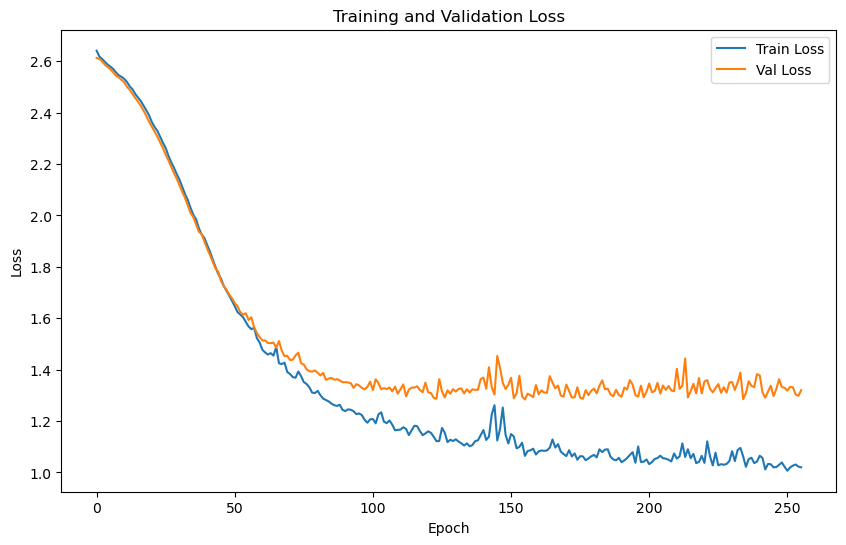

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.3460 | Test Accuracy: 42.73%


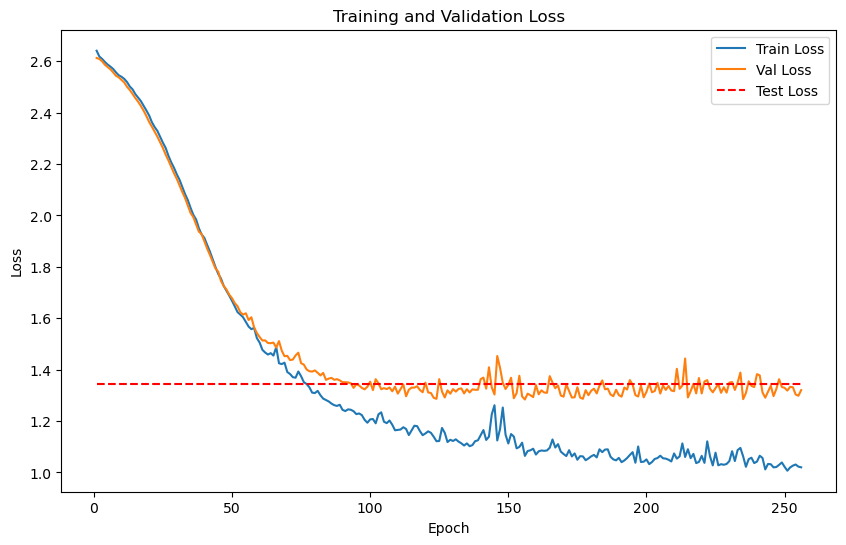

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)


Train embeddings shape: (140, 64), 
Train labels shape: (140,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3038, 64), 
Test labels shape: (3038,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10}
Training batch size: 140


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 7.7791
Epoch [1/2000], Avg Train Loss: 7.7791
Epoch [1/2000], Avg Val Loss: 3.9930
Validation loss improved from inf to 3.9930. Saving model...

LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 8.0727
Epoch [2/2000], Avg Train Loss: 8.0727
Epoch [2/2000], Avg Val Loss: 3.9742
Validation loss improved from 3.9930 to 3.9742. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.7066
Epoch [3/2000], Avg Train Loss: 7.7066
Epoch [3/2000], Avg Val Loss: 3.9560
Validation loss improved from 3.9742 to 3.9560. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.4904
Epoch [4/2000], Avg Train Loss: 7.4904
Epoch [4/2000], Avg Val Loss: 3.9386
Validation loss improved from 3.9560 to 3.9386. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.6475
Epoch [5/2000], Avg Train Loss: 7.6475
Epoch [5/2000], Avg Val Loss: 3.9222
Validation loss improved from 3.9386 to 3.9222. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.5627
Epoch [6/2000], Avg Train Loss: 7.5627
Epoch [6/2000], Avg Val Loss: 3.9063
Validation loss improved from 3.9222 to 3.9063. Saving m

    Batch [1/1], Train Loss: 6.5495
Epoch [20/2000], Avg Train Loss: 6.5495
Epoch [20/2000], Avg Val Loss: 3.7390
Validation loss improved from 3.7482 to 3.7390. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 6.6131
Epoch [21/2000], Avg Train Loss: 6.6131
Epoch [21/2000], Avg Val Loss: 3.7301
Validation loss improved from 3.7390 to 3.7301. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 6.4576
Epoch [22/2000], Avg Train Loss: 6.4576
Epoch [22/2000], Avg Val Loss: 3.7216
Validation loss improved from 3.7301 to 3.7216. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 6.3953
Epoch [23/2000], Avg Train Loss: 6.3953
Epoch [23/2000], Avg Val Loss: 3.7134
Validation loss improved from 3.7216 to 3.7134. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.2989
Epoch [24/2000], Avg Train Loss: 6.2989
Epoch [24/2000], Avg Val Loss: 3.7055
Validation loss improved from 3.7134 to 3.

    Batch [1/1], Train Loss: 5.9776
Epoch [32/2000], Avg Train Loss: 5.9776
Epoch [32/2000], Avg Val Loss: 3.6522
Validation loss improved from 3.6581 to 3.6522. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 5.9854
Epoch [33/2000], Avg Train Loss: 5.9854
Epoch [33/2000], Avg Val Loss: 3.6466
Validation loss improved from 3.6522 to 3.6466. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 5.7520
Epoch [34/2000], Avg Train Loss: 5.7520
Epoch [34/2000], Avg Val Loss: 3.6411
Validation loss improved from 3.6466 to 3.6411. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 5.8108
Epoch [35/2000], Avg Train Loss: 5.8108
Epoch [35/2000], Avg Val Loss: 3.6359
Validation loss improved from 3.6411 to 3.6359. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 5.7073
Epoch [36/2000], Avg Train Loss: 5.7073
Epoch [36/2000], Avg Val Loss: 3.6307
Validation loss improved from 3.6359 to 3.

    Batch [1/1], Train Loss: 5.2694
Epoch [48/2000], Avg Train Loss: 5.2694
Epoch [48/2000], Avg Val Loss: 3.5814
Validation loss improved from 3.5847 to 3.5814. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.2363
Epoch [49/2000], Avg Train Loss: 5.2363
Epoch [49/2000], Avg Val Loss: 3.5782
Validation loss improved from 3.5814 to 3.5782. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.2341
Epoch [50/2000], Avg Train Loss: 5.2341
Epoch [50/2000], Avg Val Loss: 3.5751
Validation loss improved from 3.5782 to 3.5751. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.1905
Epoch [51/2000], Avg Train Loss: 5.1905
Epoch [51/2000], Avg Val Loss: 3.5721
Validation loss improved from 3.5751 to 3.5721. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.2323
Epoch [52/2000], Avg Train Loss: 5.2323
Epoch [52/2000], Avg Val Loss: 3.5692
Validation loss improved from 3.5721 to 3.

    Batch [1/1], Train Loss: 4.9993
Epoch [64/2000], Avg Train Loss: 4.9993
Epoch [64/2000], Avg Val Loss: 3.5406
Validation loss improved from 3.5428 to 3.5406. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 5.0599
Epoch [65/2000], Avg Train Loss: 5.0599
Epoch [65/2000], Avg Val Loss: 3.5384
Validation loss improved from 3.5406 to 3.5384. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 5.0147
Epoch [66/2000], Avg Train Loss: 5.0147
Epoch [66/2000], Avg Val Loss: 3.5364
Validation loss improved from 3.5384 to 3.5364. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 5.0275
Epoch [67/2000], Avg Train Loss: 5.0275
Epoch [67/2000], Avg Val Loss: 3.5344
Validation loss improved from 3.5364 to 3.5344. Saving model...

LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 4.9261
Epoch [68/2000], Avg Train Loss: 4.9261
Epoch [68/2000], Avg Val Loss: 3.5324
Validation loss improved from 3.5344 to 3.

Epoch [76/2000], Avg Val Loss: 3.5184
Validation loss improved from 3.5200 to 3.5184. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 4.6811
Epoch [77/2000], Avg Train Loss: 4.6811
Epoch [77/2000], Avg Val Loss: 3.5168
Validation loss improved from 3.5184 to 3.5168. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 4.8952
Epoch [78/2000], Avg Train Loss: 4.8952
Epoch [78/2000], Avg Val Loss: 3.5151
Validation loss improved from 3.5168 to 3.5151. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 4.7711
Epoch [79/2000], Avg Train Loss: 4.7711
Epoch [79/2000], Avg Val Loss: 3.5135
Validation loss improved from 3.5151 to 3.5135. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 4.8198
Epoch [80/2000], Avg Train Loss: 4.8198
Epoch [80/2000], Avg Val Loss: 3.5119
Validation loss improved from 3.5135 to 3.5119. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 4.6733
Epoch [94/2000], Avg Train Loss: 4.6733
Epoch [94/2000], Avg Val Loss: 3.4918
Validation loss improved from 3.4931 to 3.4918. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 4.5671
Epoch [95/2000], Avg Train Loss: 4.5671
Epoch [95/2000], Avg Val Loss: 3.4905
Validation loss improved from 3.4918 to 3.4905. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 4.7209
Epoch [96/2000], Avg Train Loss: 4.7209
Epoch [96/2000], Avg Val Loss: 3.4893
Validation loss improved from 3.4905 to 3.4893. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.6593
Epoch [97/2000], Avg Train Loss: 4.6593
Epoch [97/2000], Avg Val Loss: 3.4880
Validation loss improved from 3.4893 to 3.4880. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 4.6039
Epoch [98/2000], Avg Train Loss: 4.6039
Epoch [98/2000], Avg Val Loss: 3.4868
Validation loss improved from 3.4880 to 3.

    Batch [1/1], Train Loss: 4.5267
Epoch [107/2000], Avg Train Loss: 4.5267
Epoch [107/2000], Avg Val Loss: 3.4764
Validation loss improved from 3.4774 to 3.4764. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 4.5833
Epoch [108/2000], Avg Train Loss: 4.5833
Epoch [108/2000], Avg Val Loss: 3.4753
Validation loss improved from 3.4764 to 3.4753. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 4.4967
Epoch [109/2000], Avg Train Loss: 4.4967
Epoch [109/2000], Avg Val Loss: 3.4743
Validation loss improved from 3.4753 to 3.4743. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 4.6236
Epoch [110/2000], Avg Train Loss: 4.6236
Epoch [110/2000], Avg Val Loss: 3.4732
Validation loss improved from 3.4743 to 3.4732. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.5892
Epoch [111/2000], Avg Train Loss: 4.5892
Epoch [111/2000], Avg Val Loss: 3.4722
Validation loss improved fro

Epoch [117/2000], Avg Val Loss: 3.4665
Validation loss improved from 3.4674 to 3.4665. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 4.4914
Epoch [118/2000], Avg Train Loss: 4.4914
Epoch [118/2000], Avg Val Loss: 3.4656
Validation loss improved from 3.4665 to 3.4656. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 4.4433
Epoch [119/2000], Avg Train Loss: 4.4433
Epoch [119/2000], Avg Val Loss: 3.4646
Validation loss improved from 3.4656 to 3.4646. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 4.4368
Epoch [120/2000], Avg Train Loss: 4.4368
Epoch [120/2000], Avg Val Loss: 3.4637
Validation loss improved from 3.4646 to 3.4637. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 4.4995
Epoch [121/2000], Avg Train Loss: 4.4995
Epoch [121/2000], Avg Val Loss: 3.4628
Validation loss improved from 3.4637 to 3.4628. Saving model...

LOG: Epoch [122/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3339
Epoch [138/2000], Avg Train Loss: 4.3339
Epoch [138/2000], Avg Val Loss: 3.4471
Validation loss improved from 3.4481 to 3.4471. Saving model...

LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 4.4004
Epoch [139/2000], Avg Train Loss: 4.4004
Epoch [139/2000], Avg Val Loss: 3.4461
Validation loss improved from 3.4471 to 3.4461. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 4.3508
Epoch [140/2000], Avg Train Loss: 4.3508
Epoch [140/2000], Avg Val Loss: 3.4451
Validation loss improved from 3.4461 to 3.4451. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 4.3475
Epoch [141/2000], Avg Train Loss: 4.3475
Epoch [141/2000], Avg Val Loss: 3.4441
Validation loss improved from 3.4451 to 3.4441. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 4.3271
Epoch [142/2000], Avg Train Loss: 4.3271
Epoch [142/2000], Avg Val Loss: 3.4431
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3526
Epoch [153/2000], Avg Train Loss: 4.3526
Epoch [153/2000], Avg Val Loss: 3.4325
Validation loss improved from 3.4334 to 3.4325. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 4.3471
Epoch [154/2000], Avg Train Loss: 4.3471
Epoch [154/2000], Avg Val Loss: 3.4315
Validation loss improved from 3.4325 to 3.4315. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 4.2653
Epoch [155/2000], Avg Train Loss: 4.2653
Epoch [155/2000], Avg Val Loss: 3.4306
Validation loss improved from 3.4315 to 3.4306. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 4.2984
Epoch [156/2000], Avg Train Loss: 4.2984
Epoch [156/2000], Avg Val Loss: 3.4296
Validation loss improved from 3.4306 to 3.4296. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 4.2929
Epoch [157/2000], Avg Train Loss: 4.2929
Epoch [157/2000], Avg Val Loss: 3.4287
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3797
Epoch [162/2000], Avg Train Loss: 4.3797
Epoch [162/2000], Avg Val Loss: 3.4236
Validation loss improved from 3.4246 to 3.4236. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 4.3502
Epoch [163/2000], Avg Train Loss: 4.3502
Epoch [163/2000], Avg Val Loss: 3.4226
Validation loss improved from 3.4236 to 3.4226. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 4.3292
Epoch [164/2000], Avg Train Loss: 4.3292
Epoch [164/2000], Avg Val Loss: 3.4216
Validation loss improved from 3.4226 to 3.4216. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 4.2432
Epoch [165/2000], Avg Train Loss: 4.2432
Epoch [165/2000], Avg Val Loss: 3.4206
Validation loss improved from 3.4216 to 3.4206. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 4.3182
Epoch [166/2000], Avg Train Loss: 4.3182
Epoch [166/2000], Avg Val Loss: 3.4196
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3499
Epoch [179/2000], Avg Train Loss: 4.3499
Epoch [179/2000], Avg Val Loss: 3.4064
Validation loss improved from 3.4074 to 3.4064. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 4.2260
Epoch [180/2000], Avg Train Loss: 4.2260
Epoch [180/2000], Avg Val Loss: 3.4054
Validation loss improved from 3.4064 to 3.4054. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 4.2185
Epoch [181/2000], Avg Train Loss: 4.2185
Epoch [181/2000], Avg Val Loss: 3.4044
Validation loss improved from 3.4054 to 3.4044. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 4.2468
Epoch [182/2000], Avg Train Loss: 4.2468
Epoch [182/2000], Avg Val Loss: 3.4035
Validation loss improved from 3.4044 to 3.4035. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 4.1936
Epoch [183/2000], Avg Train Loss: 4.1936
Epoch [183/2000], Avg Val Loss: 3.4025
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1880
Epoch [198/2000], Avg Train Loss: 4.1880
Epoch [198/2000], Avg Val Loss: 3.3883
Validation loss improved from 3.3892 to 3.3883. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 4.2494
Epoch [199/2000], Avg Train Loss: 4.2494
Epoch [199/2000], Avg Val Loss: 3.3874
Validation loss improved from 3.3883 to 3.3874. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 4.1513
Epoch [200/2000], Avg Train Loss: 4.1513
Epoch [200/2000], Avg Val Loss: 3.3864
Validation loss improved from 3.3874 to 3.3864. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 4.2143
Epoch [201/2000], Avg Train Loss: 4.2143
Epoch [201/2000], Avg Val Loss: 3.3854
Validation loss improved from 3.3864 to 3.3854. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 4.2370
Epoch [202/2000], Avg Train Loss: 4.2370
Epoch [202/2000], Avg Val Loss: 3.3845
Validation loss improved fro

Epoch [206/2000], Avg Val Loss: 3.3805
Validation loss improved from 3.3816 to 3.3805. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 4.1870
Epoch [207/2000], Avg Train Loss: 4.1870
Epoch [207/2000], Avg Val Loss: 3.3795
Validation loss improved from 3.3805 to 3.3795. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 4.1705
Epoch [208/2000], Avg Train Loss: 4.1705
Epoch [208/2000], Avg Val Loss: 3.3785
Validation loss improved from 3.3795 to 3.3785. Saving model...

LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 4.1545
Epoch [209/2000], Avg Train Loss: 4.1545
Epoch [209/2000], Avg Val Loss: 3.3775
Validation loss improved from 3.3785 to 3.3775. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 4.1687
Epoch [210/2000], Avg Train Loss: 4.1687
Epoch [210/2000], Avg Val Loss: 3.3764
Validation loss improved from 3.3775 to 3.3764. Saving model...

LOG: Epoch [211/2000] - Training
    Bat

Epoch [219/2000], Avg Val Loss: 3.3674
Validation loss improved from 3.3684 to 3.3674. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 4.1720
Epoch [220/2000], Avg Train Loss: 4.1720
Epoch [220/2000], Avg Val Loss: 3.3664
Validation loss improved from 3.3674 to 3.3664. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 4.1389
Epoch [221/2000], Avg Train Loss: 4.1389
Epoch [221/2000], Avg Val Loss: 3.3655
Validation loss improved from 3.3664 to 3.3655. Saving model...

LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 4.1659
Epoch [222/2000], Avg Train Loss: 4.1659
Epoch [222/2000], Avg Val Loss: 3.3646
Validation loss improved from 3.3655 to 3.3646. Saving model...

LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 4.1501
Epoch [223/2000], Avg Train Loss: 4.1501
Epoch [223/2000], Avg Val Loss: 3.3636
Validation loss improved from 3.3646 to 3.3636. Saving model...

LOG: Epoch [224/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2012
Epoch [241/2000], Avg Train Loss: 4.2012
Epoch [241/2000], Avg Val Loss: 3.3456
Validation loss improved from 3.3466 to 3.3456. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 4.0726
Epoch [242/2000], Avg Train Loss: 4.0726
Epoch [242/2000], Avg Val Loss: 3.3445
Validation loss improved from 3.3456 to 3.3445. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 4.0755
Epoch [243/2000], Avg Train Loss: 4.0755
Epoch [243/2000], Avg Val Loss: 3.3435
Validation loss improved from 3.3445 to 3.3435. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 4.1837
Epoch [244/2000], Avg Train Loss: 4.1837
Epoch [244/2000], Avg Val Loss: 3.3426
Validation loss improved from 3.3435 to 3.3426. Saving model...

LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 4.1191
Epoch [245/2000], Avg Train Loss: 4.1191
Epoch [245/2000], Avg Val Loss: 3.3416
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1289
Epoch [249/2000], Avg Train Loss: 4.1289
Epoch [249/2000], Avg Val Loss: 3.3376
Validation loss improved from 3.3386 to 3.3376. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 4.1047
Epoch [250/2000], Avg Train Loss: 4.1047
Epoch [250/2000], Avg Val Loss: 3.3367
Validation loss improved from 3.3376 to 3.3367. Saving model...

LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 4.1030
Epoch [251/2000], Avg Train Loss: 4.1030
Epoch [251/2000], Avg Val Loss: 3.3357
Validation loss improved from 3.3367 to 3.3357. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 4.0829
Epoch [252/2000], Avg Train Loss: 4.0829
Epoch [252/2000], Avg Val Loss: 3.3348
Validation loss improved from 3.3357 to 3.3348. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 4.0935
Epoch [253/2000], Avg Train Loss: 4.0935
Epoch [253/2000], Avg Val Loss: 3.3339
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0239
Epoch [263/2000], Avg Train Loss: 4.0239
Epoch [263/2000], Avg Val Loss: 3.3253
Validation loss improved from 3.3262 to 3.3253. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 4.1126
Epoch [264/2000], Avg Train Loss: 4.1126
Epoch [264/2000], Avg Val Loss: 3.3244
Validation loss improved from 3.3253 to 3.3244. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 4.0724
Epoch [265/2000], Avg Train Loss: 4.0724
Epoch [265/2000], Avg Val Loss: 3.3234
Validation loss improved from 3.3244 to 3.3234. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 4.0569
Epoch [266/2000], Avg Train Loss: 4.0569
Epoch [266/2000], Avg Val Loss: 3.3225
Validation loss improved from 3.3234 to 3.3225. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 4.0719
Epoch [267/2000], Avg Train Loss: 4.0719
Epoch [267/2000], Avg Val Loss: 3.3216
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9970
Epoch [288/2000], Avg Train Loss: 3.9970
Epoch [288/2000], Avg Val Loss: 3.3011
Validation loss improved from 3.3023 to 3.3011. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 4.0056
Epoch [289/2000], Avg Train Loss: 4.0056
Epoch [289/2000], Avg Val Loss: 3.3000
Validation loss improved from 3.3011 to 3.3000. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 4.0609
Epoch [290/2000], Avg Train Loss: 4.0609
Epoch [290/2000], Avg Val Loss: 3.2989
Validation loss improved from 3.3000 to 3.2989. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 4.0207
Epoch [291/2000], Avg Train Loss: 4.0207
Epoch [291/2000], Avg Val Loss: 3.2977
Validation loss improved from 3.2989 to 3.2977. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 4.0471
Epoch [292/2000], Avg Train Loss: 4.0471
Epoch [292/2000], Avg Val Loss: 3.2966
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0266
Epoch [298/2000], Avg Train Loss: 4.0266
Epoch [298/2000], Avg Val Loss: 3.2906
Validation loss improved from 3.2915 to 3.2906. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 4.0234
Epoch [299/2000], Avg Train Loss: 4.0234
Epoch [299/2000], Avg Val Loss: 3.2897
Validation loss improved from 3.2906 to 3.2897. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 4.0611
Epoch [300/2000], Avg Train Loss: 4.0611
Epoch [300/2000], Avg Val Loss: 3.2888
Validation loss improved from 3.2897 to 3.2888. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 4.0696
Epoch [301/2000], Avg Train Loss: 4.0696
Epoch [301/2000], Avg Val Loss: 3.2878
Validation loss improved from 3.2888 to 3.2878. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 3.9992
Epoch [302/2000], Avg Train Loss: 3.9992
Epoch [302/2000], Avg Val Loss: 3.2870
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0019
Epoch [308/2000], Avg Train Loss: 4.0019
Epoch [308/2000], Avg Val Loss: 3.2819
Validation loss improved from 3.2828 to 3.2819. Saving model...

LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 3.9996
Epoch [309/2000], Avg Train Loss: 3.9996
Epoch [309/2000], Avg Val Loss: 3.2811
Validation loss improved from 3.2819 to 3.2811. Saving model...

LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 3.9407
Epoch [310/2000], Avg Train Loss: 3.9407
Epoch [310/2000], Avg Val Loss: 3.2802
Validation loss improved from 3.2811 to 3.2802. Saving model...

LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 4.0322
Epoch [311/2000], Avg Train Loss: 4.0322
Epoch [311/2000], Avg Val Loss: 3.2795
Validation loss improved from 3.2802 to 3.2795. Saving model...

LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 3.9884
Epoch [312/2000], Avg Train Loss: 3.9884
Epoch [312/2000], Avg Val Loss: 3.2786
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9979
Epoch [333/2000], Avg Train Loss: 3.9979
Epoch [333/2000], Avg Val Loss: 3.2614
Validation loss improved from 3.2622 to 3.2614. Saving model...

LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 3.9617
Epoch [334/2000], Avg Train Loss: 3.9617
Epoch [334/2000], Avg Val Loss: 3.2606
Validation loss improved from 3.2614 to 3.2606. Saving model...

LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 4.0226
Epoch [335/2000], Avg Train Loss: 4.0226
Epoch [335/2000], Avg Val Loss: 3.2597
Validation loss improved from 3.2606 to 3.2597. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 3.9763
Epoch [336/2000], Avg Train Loss: 3.9763
Epoch [336/2000], Avg Val Loss: 3.2588
Validation loss improved from 3.2597 to 3.2588. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 3.9556
Epoch [337/2000], Avg Train Loss: 3.9556
Epoch [337/2000], Avg Val Loss: 3.2579
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9094
Epoch [343/2000], Avg Train Loss: 3.9094
Epoch [343/2000], Avg Val Loss: 3.2526
Validation loss improved from 3.2535 to 3.2526. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 3.9206
Epoch [344/2000], Avg Train Loss: 3.9206
Epoch [344/2000], Avg Val Loss: 3.2518
Validation loss improved from 3.2526 to 3.2518. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 3.9538
Epoch [345/2000], Avg Train Loss: 3.9538
Epoch [345/2000], Avg Val Loss: 3.2510
Validation loss improved from 3.2518 to 3.2510. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 3.9741
Epoch [346/2000], Avg Train Loss: 3.9741
Epoch [346/2000], Avg Val Loss: 3.2501
Validation loss improved from 3.2510 to 3.2501. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 3.9748
Epoch [347/2000], Avg Train Loss: 3.9748
Epoch [347/2000], Avg Val Loss: 3.2492
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9346
Epoch [352/2000], Avg Train Loss: 3.9346
Epoch [352/2000], Avg Val Loss: 3.2449
Validation loss improved from 3.2458 to 3.2449. Saving model...

LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 3.9430
Epoch [353/2000], Avg Train Loss: 3.9430
Epoch [353/2000], Avg Val Loss: 3.2440
Validation loss improved from 3.2449 to 3.2440. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 3.9355
Epoch [354/2000], Avg Train Loss: 3.9355
Epoch [354/2000], Avg Val Loss: 3.2431
Validation loss improved from 3.2440 to 3.2431. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 3.8977
Epoch [355/2000], Avg Train Loss: 3.8977
Epoch [355/2000], Avg Val Loss: 3.2422
Validation loss improved from 3.2431 to 3.2422. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 3.9327
Epoch [356/2000], Avg Train Loss: 3.9327
Epoch [356/2000], Avg Val Loss: 3.2413
Validation loss improved fro

Epoch [373/2000], Avg Val Loss: 3.2282
Validation loss improved from 3.2289 to 3.2282. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 3.9514
Epoch [374/2000], Avg Train Loss: 3.9514
Epoch [374/2000], Avg Val Loss: 3.2275
Validation loss improved from 3.2282 to 3.2275. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 3.8966
Epoch [375/2000], Avg Train Loss: 3.8966
Epoch [375/2000], Avg Val Loss: 3.2267
Validation loss improved from 3.2275 to 3.2267. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 3.9306
Epoch [376/2000], Avg Train Loss: 3.9306
Epoch [376/2000], Avg Val Loss: 3.2260
Validation loss improved from 3.2267 to 3.2260. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 3.8816
Epoch [377/2000], Avg Train Loss: 3.8816
Epoch [377/2000], Avg Val Loss: 3.2253
Validation loss improved from 3.2260 to 3.2253. Saving model...

LOG: Epoch [378/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9486
Epoch [385/2000], Avg Train Loss: 3.9486
Epoch [385/2000], Avg Val Loss: 3.2192
Validation loss improved from 3.2200 to 3.2192. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 3.8557
Epoch [386/2000], Avg Train Loss: 3.8557
Epoch [386/2000], Avg Val Loss: 3.2185
Validation loss improved from 3.2192 to 3.2185. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 3.8825
Epoch [387/2000], Avg Train Loss: 3.8825
Epoch [387/2000], Avg Val Loss: 3.2178
Validation loss improved from 3.2185 to 3.2178. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 3.9081
Epoch [388/2000], Avg Train Loss: 3.9081
Epoch [388/2000], Avg Val Loss: 3.2170
Validation loss improved from 3.2178 to 3.2170. Saving model...

LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 3.9394
Epoch [389/2000], Avg Train Loss: 3.9394
Epoch [389/2000], Avg Val Loss: 3.2162
Validation loss improved fro

Epoch [394/2000], Avg Val Loss: 3.2121
Validation loss improved from 3.2129 to 3.2121. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 3.8832
Epoch [395/2000], Avg Train Loss: 3.8832
Epoch [395/2000], Avg Val Loss: 3.2113
Validation loss improved from 3.2121 to 3.2113. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 3.9128
Epoch [396/2000], Avg Train Loss: 3.9128
Epoch [396/2000], Avg Val Loss: 3.2106
Validation loss improved from 3.2113 to 3.2106. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 3.8570
Epoch [397/2000], Avg Train Loss: 3.8570
Epoch [397/2000], Avg Val Loss: 3.2098
Validation loss improved from 3.2106 to 3.2098. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 3.8898
Epoch [398/2000], Avg Train Loss: 3.8898
Epoch [398/2000], Avg Val Loss: 3.2090
Validation loss improved from 3.2098 to 3.2090. Saving model...

LOG: Epoch [399/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8903
Epoch [415/2000], Avg Train Loss: 3.8903
Epoch [415/2000], Avg Val Loss: 3.1972
Validation loss improved from 3.1979 to 3.1972. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 3.8843
Epoch [416/2000], Avg Train Loss: 3.8843
Epoch [416/2000], Avg Val Loss: 3.1966
Validation loss improved from 3.1972 to 3.1966. Saving model...

LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 3.8360
Epoch [417/2000], Avg Train Loss: 3.8360
Epoch [417/2000], Avg Val Loss: 3.1959
Validation loss improved from 3.1966 to 3.1959. Saving model...

LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 3.9145
Epoch [418/2000], Avg Train Loss: 3.9145
Epoch [418/2000], Avg Val Loss: 3.1952
Validation loss improved from 3.1959 to 3.1952. Saving model...

LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 3.8581
Epoch [419/2000], Avg Train Loss: 3.8581
Epoch [419/2000], Avg Val Loss: 3.1947
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8499
Epoch [432/2000], Avg Train Loss: 3.8499
Epoch [432/2000], Avg Val Loss: 3.1853
Validation loss improved from 3.1859 to 3.1853. Saving model...

LOG: Epoch [433/2000] - Training
    Batch [1/1], Train Loss: 3.8087
Epoch [433/2000], Avg Train Loss: 3.8087
Epoch [433/2000], Avg Val Loss: 3.1847
Validation loss improved from 3.1853 to 3.1847. Saving model...

LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 3.8146
Epoch [434/2000], Avg Train Loss: 3.8146
Epoch [434/2000], Avg Val Loss: 3.1839
Validation loss improved from 3.1847 to 3.1839. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 3.8249
Epoch [435/2000], Avg Train Loss: 3.8249
Epoch [435/2000], Avg Val Loss: 3.1832
Validation loss improved from 3.1839 to 3.1832. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 3.8688
Epoch [436/2000], Avg Train Loss: 3.8688
Epoch [436/2000], Avg Val Loss: 3.1825
Validation loss improved fro

Epoch [438/2000], Avg Val Loss: 3.1811
Validation loss improved from 3.1818 to 3.1811. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 3.8396
Epoch [439/2000], Avg Train Loss: 3.8396
Epoch [439/2000], Avg Val Loss: 3.1803
Validation loss improved from 3.1811 to 3.1803. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 3.8224
Epoch [440/2000], Avg Train Loss: 3.8224
Epoch [440/2000], Avg Val Loss: 3.1796
Validation loss improved from 3.1803 to 3.1796. Saving model...

LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 3.8724
Epoch [441/2000], Avg Train Loss: 3.8724
Epoch [441/2000], Avg Val Loss: 3.1789
Validation loss improved from 3.1796 to 3.1789. Saving model...

LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 3.8516
Epoch [442/2000], Avg Train Loss: 3.8516
Epoch [442/2000], Avg Val Loss: 3.1782
Validation loss improved from 3.1789 to 3.1782. Saving model...

LOG: Epoch [443/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8446
Epoch [456/2000], Avg Train Loss: 3.8446
Epoch [456/2000], Avg Val Loss: 3.1659
Validation loss improved from 3.1668 to 3.1659. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 3.8697
Epoch [457/2000], Avg Train Loss: 3.8697
Epoch [457/2000], Avg Val Loss: 3.1651
Validation loss improved from 3.1659 to 3.1651. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 3.8336
Epoch [458/2000], Avg Train Loss: 3.8336
Epoch [458/2000], Avg Val Loss: 3.1642
Validation loss improved from 3.1651 to 3.1642. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 3.8158
Epoch [459/2000], Avg Train Loss: 3.8158
Epoch [459/2000], Avg Val Loss: 3.1634
Validation loss improved from 3.1642 to 3.1634. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 3.7569
Epoch [460/2000], Avg Train Loss: 3.7569
Epoch [460/2000], Avg Val Loss: 3.1626
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8480
Epoch [471/2000], Avg Train Loss: 3.8480


Epoch [471/2000], Avg Val Loss: 3.1549
Validation loss improved from 3.1555 to 3.1549. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 3.7961
Epoch [472/2000], Avg Train Loss: 3.7961
Epoch [472/2000], Avg Val Loss: 3.1543
Validation loss improved from 3.1549 to 3.1543. Saving model...

LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 3.8078
Epoch [473/2000], Avg Train Loss: 3.8078
Epoch [473/2000], Avg Val Loss: 3.1537
Validation loss improved from 3.1543 to 3.1537. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 3.7871
Epoch [474/2000], Avg Train Loss: 3.7871
Epoch [474/2000], Avg Val Loss: 3.1531
Validation loss improved from 3.1537 to 3.1531. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 3.7871
Epoch [475/2000], Avg Train Loss: 3.7871
Epoch [475/2000], Avg Val Loss: 3.1526
Validation loss improved from 3.1531 to 3.1526. Saving model...

LOG: Epoch [476/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7859
Epoch [497/2000], Avg Train Loss: 3.7859
Epoch [497/2000], Avg Val Loss: 3.1412
Validation loss improved from 3.1417 to 3.1412. Saving model...

LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 3.7573
Epoch [498/2000], Avg Train Loss: 3.7573
Epoch [498/2000], Avg Val Loss: 3.1407
Validation loss improved from 3.1412 to 3.1407. Saving model...

LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 3.7729
Epoch [499/2000], Avg Train Loss: 3.7729
Epoch [499/2000], Avg Val Loss: 3.1402
Validation loss improved from 3.1407 to 3.1402. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 3.7914
Epoch [500/2000], Avg Train Loss: 3.7914
Epoch [500/2000], Avg Val Loss: 3.1397
Validation loss improved from 3.1402 to 3.1397. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 3.8189
Epoch [501/2000], Avg Train Loss: 3.8189
Epoch [501/2000], Avg Val Loss: 3.1394
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7705
Epoch [514/2000], Avg Train Loss: 3.7705
Epoch [514/2000], Avg Val Loss: 3.1324
Validation loss improved from 3.1329 to 3.1324. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 3.7231
Epoch [515/2000], Avg Train Loss: 3.7231
Epoch [515/2000], Avg Val Loss: 3.1318
Validation loss improved from 3.1324 to 3.1318. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 3.7310
Epoch [516/2000], Avg Train Loss: 3.7310
Epoch [516/2000], Avg Val Loss: 3.1311
Validation loss improved from 3.1318 to 3.1311. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 3.6983
Epoch [517/2000], Avg Train Loss: 3.6983
Epoch [517/2000], Avg Val Loss: 3.1304
Validation loss improved from 3.1311 to 3.1304. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 3.7875
Epoch [518/2000], Avg Train Loss: 3.7875
Epoch [518/2000], Avg Val Loss: 3.1297
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7050
Epoch [543/2000], Avg Train Loss: 3.7050
Epoch [543/2000], Avg Val Loss: 3.1147
Validation loss improved from 3.1152 to 3.1147. Saving model...

LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 3.7228
Epoch [544/2000], Avg Train Loss: 3.7228
Epoch [544/2000], Avg Val Loss: 3.1141
Validation loss improved from 3.1147 to 3.1141. Saving model...

LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 3.7165
Epoch [545/2000], Avg Train Loss: 3.7165
Epoch [545/2000], Avg Val Loss: 3.1136
Validation loss improved from 3.1141 to 3.1136. Saving model...

LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 3.6513
Epoch [546/2000], Avg Train Loss: 3.6513
Epoch [546/2000], Avg Val Loss: 3.1130
Validation loss improved from 3.1136 to 3.1130. Saving model...

LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 3.6901
Epoch [547/2000], Avg Train Loss: 3.6901
Epoch [547/2000], Avg Val Loss: 3.1125
Validation loss improved fro

Epoch [562/2000], Avg Val Loss: 3.1038
Validation loss improved from 3.1044 to 3.1038. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 3.6980
Epoch [563/2000], Avg Train Loss: 3.6980
Epoch [563/2000], Avg Val Loss: 3.1033
Validation loss improved from 3.1038 to 3.1033. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 3.7216
Epoch [564/2000], Avg Train Loss: 3.7216
Epoch [564/2000], Avg Val Loss: 3.1028
Validation loss improved from 3.1033 to 3.1028. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 3.6812
Epoch [565/2000], Avg Train Loss: 3.6812
Epoch [565/2000], Avg Val Loss: 3.1023
Validation loss improved from 3.1028 to 3.1023. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 3.7535
Epoch [566/2000], Avg Train Loss: 3.7535
Epoch [566/2000], Avg Val Loss: 3.1019
Validation loss improved from 3.1023 to 3.1019. Saving model...

LOG: Epoch [567/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6691
Epoch [586/2000], Avg Train Loss: 3.6691
Epoch [586/2000], Avg Val Loss: 3.0917
Validation loss improved from 3.0923 to 3.0917. Saving model...

LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 3.6571
Epoch [587/2000], Avg Train Loss: 3.6571
Epoch [587/2000], Avg Val Loss: 3.0910
Validation loss improved from 3.0917 to 3.0910. Saving model...

LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 3.6556
Epoch [588/2000], Avg Train Loss: 3.6556
Epoch [588/2000], Avg Val Loss: 3.0904
Validation loss improved from 3.0910 to 3.0904. Saving model...

LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 3.6295
Epoch [589/2000], Avg Train Loss: 3.6295
Epoch [589/2000], Avg Val Loss: 3.0899
Validation loss improved from 3.0904 to 3.0899. Saving model...

LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 3.7393
Epoch [590/2000], Avg Train Loss: 3.7393
Epoch [590/2000], Avg Val Loss: 3.0893
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6148
Epoch [605/2000], Avg Train Loss: 3.6148
Epoch [605/2000], Avg Val Loss: 3.0801
Validation loss improved from 3.0806 to 3.0801. Saving model...

LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 3.7022
Epoch [606/2000], Avg Train Loss: 3.7022
Epoch [606/2000], Avg Val Loss: 3.0797
Validation loss improved from 3.0801 to 3.0797. Saving model...

LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 3.6334
Epoch [607/2000], Avg Train Loss: 3.6334
Epoch [607/2000], Avg Val Loss: 3.0793
Validation loss improved from 3.0797 to 3.0793. Saving model...

LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 3.6047
Epoch [608/2000], Avg Train Loss: 3.6047
Epoch [608/2000], Avg Val Loss: 3.0789
Validation loss improved from 3.0793 to 3.0789. Saving model...

LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 3.6058
Epoch [609/2000], Avg Train Loss: 3.6058
Epoch [609/2000], Avg Val Loss: 3.0784
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6281
Epoch [629/2000], Avg Train Loss: 3.6281
Epoch [629/2000], Avg Val Loss: 3.0670
Validation loss improved from 3.0678 to 3.0670. Saving model...

LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 3.6210
Epoch [630/2000], Avg Train Loss: 3.6210
Epoch [630/2000], Avg Val Loss: 3.0661
Validation loss improved from 3.0670 to 3.0661. Saving model...

LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 3.6147
Epoch [631/2000], Avg Train Loss: 3.6147
Epoch [631/2000], Avg Val Loss: 3.0652
Validation loss improved from 3.0661 to 3.0652. Saving model...

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 3.6618
Epoch [632/2000], Avg Train Loss: 3.6618
Epoch [632/2000], Avg Val Loss: 3.0643
Validation loss improved from 3.0652 to 3.0643. Saving model...

LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 3.6107
Epoch [633/2000], Avg Train Loss: 3.6107
Epoch [633/2000], Avg Val Loss: 3.0634
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5890
Epoch [651/2000], Avg Train Loss: 3.5890
Epoch [651/2000], Avg Val Loss: 3.0549
Validation loss improved from 3.0553 to 3.0549. Saving model...

LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 3.6190
Epoch [652/2000], Avg Train Loss: 3.6190
Epoch [652/2000], Avg Val Loss: 3.0545
Validation loss improved from 3.0549 to 3.0545. Saving model...

LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 3.6251
Epoch [653/2000], Avg Train Loss: 3.6251
Epoch [653/2000], Avg Val Loss: 3.0543
Validation loss improved from 3.0545 to 3.0543. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 3.6097
Epoch [654/2000], Avg Train Loss: 3.6097
Epoch [654/2000], Avg Val Loss: 3.0541
Validation loss improved from 3.0543 to 3.0541. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 3.6412
Epoch [655/2000], Avg Train Loss: 3.6412
Epoch [655/2000], Avg Val Loss: 3.0538
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6233
Epoch [671/2000], Avg Train Loss: 3.6233
Epoch [671/2000], Avg Val Loss: 3.0461
Validation loss improved from 3.0467 to 3.0461. Saving model...

LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 3.6287
Epoch [672/2000], Avg Train Loss: 3.6287
Epoch [672/2000], Avg Val Loss: 3.0455
Validation loss improved from 3.0461 to 3.0455. Saving model...

LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 3.5964
Epoch [673/2000], Avg Train Loss: 3.5964
Epoch [673/2000], Avg Val Loss: 3.0448
Validation loss improved from 3.0455 to 3.0448. Saving model...

LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 3.6016
Epoch [674/2000], Avg Train Loss: 3.6016
Epoch [674/2000], Avg Val Loss: 3.0443
Validation loss improved from 3.0448 to 3.0443. Saving model...

LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 3.5817
Epoch [675/2000], Avg Train Loss: 3.5817
Epoch [675/2000], Avg Val Loss: 3.0438
Validation loss improved fro

Epoch [695/2000], Avg Val Loss: 3.0311
Validation loss improved from 3.0317 to 3.0311. Saving model...

LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 3.5600
Epoch [696/2000], Avg Train Loss: 3.5600
Epoch [696/2000], Avg Val Loss: 3.0306
Validation loss improved from 3.0311 to 3.0306. Saving model...

LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 3.5475
Epoch [697/2000], Avg Train Loss: 3.5475
Epoch [697/2000], Avg Val Loss: 3.0301
Validation loss improved from 3.0306 to 3.0301. Saving model...

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 3.5696
Epoch [698/2000], Avg Train Loss: 3.5696
Epoch [698/2000], Avg Val Loss: 3.0297
Validation loss improved from 3.0301 to 3.0297. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 3.4937
Epoch [699/2000], Avg Train Loss: 3.4937
Epoch [699/2000], Avg Val Loss: 3.0293
Validation loss improved from 3.0297 to 3.0293. Saving model...

LOG: Epoch [700/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5304
Epoch [717/2000], Avg Train Loss: 3.5304
Epoch [717/2000], Avg Val Loss: 3.0187
Validation loss improved from 3.0193 to 3.0187. Saving model...

LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 3.5386
Epoch [718/2000], Avg Train Loss: 3.5386
Epoch [718/2000], Avg Val Loss: 3.0183
Validation loss improved from 3.0187 to 3.0183. Saving model...

LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 3.4672
Epoch [719/2000], Avg Train Loss: 3.4672
Epoch [719/2000], Avg Val Loss: 3.0178
Validation loss improved from 3.0183 to 3.0178. Saving model...

LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 3.5174
Epoch [720/2000], Avg Train Loss: 3.5174
Epoch [720/2000], Avg Val Loss: 3.0174
Validation loss improved from 3.0178 to 3.0174. Saving model...

LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 3.5499
Epoch [721/2000], Avg Train Loss: 3.5499
Epoch [721/2000], Avg Val Loss: 3.0170
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5172
Epoch [743/2000], Avg Train Loss: 3.5172
Epoch [743/2000], Avg Val Loss: 3.0057
Validation loss improved from 3.0063 to 3.0057. Saving model...

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 3.5571
Epoch [744/2000], Avg Train Loss: 3.5571
Epoch [744/2000], Avg Val Loss: 3.0051
Validation loss improved from 3.0057 to 3.0051. Saving model...

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 3.4713
Epoch [745/2000], Avg Train Loss: 3.4713
Epoch [745/2000], Avg Val Loss: 3.0045
Validation loss improved from 3.0051 to 3.0045. Saving model...

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 3.4710
Epoch [746/2000], Avg Train Loss: 3.4710
Epoch [746/2000], Avg Val Loss: 3.0039
Validation loss improved from 3.0045 to 3.0039. Saving model...

LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 3.4725
Epoch [747/2000], Avg Train Loss: 3.4725
Epoch [747/2000], Avg Val Loss: 3.0031
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4923
Epoch [762/2000], Avg Train Loss: 3.4923
Epoch [762/2000], Avg Val Loss: 2.9930
Validation loss improved from 2.9936 to 2.9930. Saving model...

LOG: Epoch [763/2000] - Training
    Batch [1/1], Train Loss: 3.4908
Epoch [763/2000], Avg Train Loss: 3.4908
Epoch [763/2000], Avg Val Loss: 2.9926
Validation loss improved from 2.9930 to 2.9926. Saving model...

LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 3.4979
Epoch [764/2000], Avg Train Loss: 3.4979
Epoch [764/2000], Avg Val Loss: 2.9922
Validation loss improved from 2.9926 to 2.9922. Saving model...

LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 3.4925
Epoch [765/2000], Avg Train Loss: 3.4925
Epoch [765/2000], Avg Val Loss: 2.9918
Validation loss improved from 2.9922 to 2.9918. Saving model...

LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 3.4825
Epoch [766/2000], Avg Train Loss: 3.4825
Epoch [766/2000], Avg Val Loss: 2.9913
Validation loss improved fro

Epoch [784/2000], Avg Val Loss: 2.9862
Validation loss improved from 2.9865 to 2.9862. Saving model...

LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 3.4719
Epoch [785/2000], Avg Train Loss: 3.4719
Epoch [785/2000], Avg Val Loss: 2.9858
Validation loss improved from 2.9862 to 2.9858. Saving model...

LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 3.4311
Epoch [786/2000], Avg Train Loss: 3.4311
Epoch [786/2000], Avg Val Loss: 2.9856
Validation loss improved from 2.9858 to 2.9856. Saving model...

LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 3.4275
Epoch [787/2000], Avg Train Loss: 3.4275
Epoch [787/2000], Avg Val Loss: 2.9853
Validation loss improved from 2.9856 to 2.9853. Saving model...

LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 3.4885
Epoch [788/2000], Avg Train Loss: 3.4885
Epoch [788/2000], Avg Val Loss: 2.9850
Validation loss improved from 2.9853 to 2.9850. Saving model...

LOG: Epoch [789/2000] - Training
    Bat

Epoch [804/2000], Avg Val Loss: 2.9782
Validation loss improved from 2.9787 to 2.9782. Saving model...

LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 3.4295
Epoch [805/2000], Avg Train Loss: 3.4295
Epoch [805/2000], Avg Val Loss: 2.9778
Validation loss improved from 2.9782 to 2.9778. Saving model...

LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 3.4597
Epoch [806/2000], Avg Train Loss: 3.4597
Epoch [806/2000], Avg Val Loss: 2.9774
Validation loss improved from 2.9778 to 2.9774. Saving model...

LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 3.4462
Epoch [807/2000], Avg Train Loss: 3.4462
Epoch [807/2000], Avg Val Loss: 2.9770
Validation loss improved from 2.9774 to 2.9770. Saving model...

LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 3.4272
Epoch [808/2000], Avg Train Loss: 3.4272
Epoch [808/2000], Avg Val Loss: 2.9767
Validation loss improved from 2.9770 to 2.9767. Saving model...

LOG: Epoch [809/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4231
Epoch [825/2000], Avg Train Loss: 3.4231
Epoch [825/2000], Avg Val Loss: 2.9719
Validation loss improved from 2.9723 to 2.9719. Saving model...

LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 3.4079
Epoch [826/2000], Avg Train Loss: 3.4079
Epoch [826/2000], Avg Val Loss: 2.9715
Validation loss improved from 2.9719 to 2.9715. Saving model...

LOG: Epoch [827/2000] - Training
    Batch [1/1], Train Loss: 3.3844
Epoch [827/2000], Avg Train Loss: 3.3844
Epoch [827/2000], Avg Val Loss: 2.9711
Validation loss improved from 2.9715 to 2.9711. Saving model...

LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 3.4576
Epoch [828/2000], Avg Train Loss: 3.4576
Epoch [828/2000], Avg Val Loss: 2.9706
Validation loss improved from 2.9711 to 2.9706. Saving model...

LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 3.3857
Epoch [829/2000], Avg Train Loss: 3.3857
Epoch [829/2000], Avg Val Loss: 2.9701
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3522
Epoch [851/2000], Avg Train Loss: 3.3522
Epoch [851/2000], Avg Val Loss: 2.9560
Validation loss improved from 2.9561 to 2.9560. Saving model...

LOG: Epoch [852/2000] - Training
    Batch [1/1], Train Loss: 3.4005
Epoch [852/2000], Avg Train Loss: 3.4005
Epoch [852/2000], Avg Val Loss: 2.9559
Validation loss improved from 2.9560 to 2.9559. Saving model...

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 3.4383
Epoch [853/2000], Avg Train Loss: 3.4383
Epoch [853/2000], Avg Val Loss: 2.9557
Validation loss improved from 2.9559 to 2.9557. Saving model...

LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 3.3959
Epoch [854/2000], Avg Train Loss: 3.3959
Epoch [854/2000], Avg Val Loss: 2.9557
Validation loss did not improve. Patience: 1/100

LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 3.3744
Epoch [855/2000], Avg Train Loss: 3.3744
Epoch [855/2000], Avg Val Loss: 2.9557
Validation loss improved from 2.9557 to 2.9

    Batch [1/1], Train Loss: 3.3176
Epoch [871/2000], Avg Train Loss: 3.3176
Epoch [871/2000], Avg Val Loss: 2.9517
Validation loss improved from 2.9522 to 2.9517. Saving model...

LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 3.3172
Epoch [872/2000], Avg Train Loss: 3.3172
Epoch [872/2000], Avg Val Loss: 2.9512
Validation loss improved from 2.9517 to 2.9512. Saving model...

LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 3.3991
Epoch [873/2000], Avg Train Loss: 3.3991
Epoch [873/2000], Avg Val Loss: 2.9508
Validation loss improved from 2.9512 to 2.9508. Saving model...

LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 3.4315
Epoch [874/2000], Avg Train Loss: 3.4315
Epoch [874/2000], Avg Val Loss: 2.9504
Validation loss improved from 2.9508 to 2.9504. Saving model...

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 3.3535
Epoch [875/2000], Avg Train Loss: 3.3535
Epoch [875/2000], Avg Val Loss: 2.9500
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3685
Epoch [898/2000], Avg Train Loss: 3.3685
Epoch [898/2000], Avg Val Loss: 2.9422
Validation loss improved from 2.9426 to 2.9422. Saving model...

LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 3.3405
Epoch [899/2000], Avg Train Loss: 3.3405
Epoch [899/2000], Avg Val Loss: 2.9420
Validation loss improved from 2.9422 to 2.9420. Saving model...

LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 3.3034
Epoch [900/2000], Avg Train Loss: 3.3034
Epoch [900/2000], Avg Val Loss: 2.9418
Validation loss improved from 2.9420 to 2.9418. Saving model...

LOG: Epoch [901/2000] - Training
    Batch [1/1], Train Loss: 3.3347
Epoch [901/2000], Avg Train Loss: 3.3347
Epoch [901/2000], Avg Val Loss: 2.9418
Validation loss did not improve. Patience: 1/100

LOG: Epoch [902/2000] - Training
    Batch [1/1], Train Loss: 3.3418
Epoch [902/2000], Avg Train Loss: 3.3418
Epoch [902/2000], Avg Val Loss: 2.9419
Validation loss did not improve. Patience: 

Epoch [913/2000], Avg Val Loss: 2.9392
Validation loss improved from 2.9396 to 2.9392. Saving model...

LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 3.3522
Epoch [914/2000], Avg Train Loss: 3.3522
Epoch [914/2000], Avg Val Loss: 2.9389
Validation loss improved from 2.9392 to 2.9389. Saving model...

LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 3.3579
Epoch [915/2000], Avg Train Loss: 3.3579
Epoch [915/2000], Avg Val Loss: 2.9387
Validation loss improved from 2.9389 to 2.9387. Saving model...

LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 3.3712
Epoch [916/2000], Avg Train Loss: 3.3712
Epoch [916/2000], Avg Val Loss: 2.9385
Validation loss improved from 2.9387 to 2.9385. Saving model...

LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 3.3458
Epoch [917/2000], Avg Train Loss: 3.3458
Epoch [917/2000], Avg Val Loss: 2.9383
Validation loss improved from 2.9385 to 2.9383. Saving model...

LOG: Epoch [918/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.3746
Epoch [941/2000], Avg Train Loss: 3.3746
Epoch [941/2000], Avg Val Loss: 2.9323
Validation loss improved from 2.9327 to 2.9323. Saving model...

LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 3.3286
Epoch [942/2000], Avg Train Loss: 3.3286
Epoch [942/2000], Avg Val Loss: 2.9318
Validation loss improved from 2.9323 to 2.9318. Saving model...

LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 3.2914
Epoch [943/2000], Avg Train Loss: 3.2914
Epoch [943/2000], Avg Val Loss: 2.9312
Validation loss improved from 2.9318 to 2.9312. Saving model...

LOG: Epoch [944/2000] - Training
    Batch [1/1], Train Loss: 3.3300
Epoch [944/2000], Avg Train Loss: 3.3300
Epoch [944/2000], Avg Val Loss: 2.9306
Validation loss improved from 2.9312 to 2.9306. Saving model...

LOG: Epoch [945/2000] - Training
    Batch [1/1], Train Loss: 3.3293
Epoch [945/2000], Avg Train Loss: 3.3293
Epoch [945/2000], Avg Val Loss: 2.9299
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2907
Epoch [956/2000], Avg Train Loss: 3.2907
Epoch [956/2000], Avg Val Loss: 2.9241
Validation loss improved from 2.9245 to 2.9241. Saving model...

LOG: Epoch [957/2000] - Training
    Batch [1/1], Train Loss: 3.2982
Epoch [957/2000], Avg Train Loss: 3.2982
Epoch [957/2000], Avg Val Loss: 2.9237
Validation loss improved from 2.9241 to 2.9237. Saving model...

LOG: Epoch [958/2000] - Training
    Batch [1/1], Train Loss: 3.3143
Epoch [958/2000], Avg Train Loss: 3.3143
Epoch [958/2000], Avg Val Loss: 2.9234
Validation loss improved from 2.9237 to 2.9234. Saving model...

LOG: Epoch [959/2000] - Training
    Batch [1/1], Train Loss: 3.2686
Epoch [959/2000], Avg Train Loss: 3.2686
Epoch [959/2000], Avg Val Loss: 2.9230
Validation loss improved from 2.9234 to 2.9230. Saving model...

LOG: Epoch [960/2000] - Training
    Batch [1/1], Train Loss: 3.3080
Epoch [960/2000], Avg Train Loss: 3.3080
Epoch [960/2000], Avg Val Loss: 2.9225
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2578
Epoch [984/2000], Avg Train Loss: 3.2578
Epoch [984/2000], Avg Val Loss: 2.9140
Validation loss improved from 2.9145 to 2.9140. Saving model...

LOG: Epoch [985/2000] - Training
    Batch [1/1], Train Loss: 3.2311
Epoch [985/2000], Avg Train Loss: 3.2311
Epoch [985/2000], Avg Val Loss: 2.9136
Validation loss improved from 2.9140 to 2.9136. Saving model...

LOG: Epoch [986/2000] - Training
    Batch [1/1], Train Loss: 3.3045
Epoch [986/2000], Avg Train Loss: 3.3045
Epoch [986/2000], Avg Val Loss: 2.9131
Validation loss improved from 2.9136 to 2.9131. Saving model...

LOG: Epoch [987/2000] - Training
    Batch [1/1], Train Loss: 3.2677
Epoch [987/2000], Avg Train Loss: 3.2677
Epoch [987/2000], Avg Val Loss: 2.9126
Validation loss improved from 2.9131 to 2.9126. Saving model...

LOG: Epoch [988/2000] - Training
    Batch [1/1], Train Loss: 3.2721
Epoch [988/2000], Avg Train Loss: 3.2721
Epoch [988/2000], Avg Val Loss: 2.9122
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2675
Epoch [998/2000], Avg Train Loss: 3.2675
Epoch [998/2000], Avg Val Loss: 2.9065
Validation loss improved from 2.9070 to 2.9065. Saving model...

LOG: Epoch [999/2000] - Training
    Batch [1/1], Train Loss: 3.2570
Epoch [999/2000], Avg Train Loss: 3.2570
Epoch [999/2000], Avg Val Loss: 2.9063
Validation loss improved from 2.9065 to 2.9063. Saving model...

LOG: Epoch [1000/2000] - Training
    Batch [1/1], Train Loss: 3.3434
Epoch [1000/2000], Avg Train Loss: 3.3434
Epoch [1000/2000], Avg Val Loss: 2.9062
Validation loss improved from 2.9063 to 2.9062. Saving model...

LOG: Epoch [1001/2000] - Training
    Batch [1/1], Train Loss: 3.2317
Epoch [1001/2000], Avg Train Loss: 3.2317
Epoch [1001/2000], Avg Val Loss: 2.9060
Validation loss improved from 2.9062 to 2.9060. Saving model...

LOG: Epoch [1002/2000] - Training
    Batch [1/1], Train Loss: 3.2777
Epoch [1002/2000], Avg Train Loss: 3.2777
Epoch [1002/2000], Avg Val Loss: 2.9057
Validation loss imp

Epoch [1032/2000], Avg Val Loss: 2.8972
Validation loss improved from 2.8978 to 2.8972. Saving model...

LOG: Epoch [1033/2000] - Training
    Batch [1/1], Train Loss: 3.2278
Epoch [1033/2000], Avg Train Loss: 3.2278
Epoch [1033/2000], Avg Val Loss: 2.8967
Validation loss improved from 2.8972 to 2.8967. Saving model...

LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 3.2302
Epoch [1034/2000], Avg Train Loss: 3.2302
Epoch [1034/2000], Avg Val Loss: 2.8961
Validation loss improved from 2.8967 to 2.8961. Saving model...

LOG: Epoch [1035/2000] - Training
    Batch [1/1], Train Loss: 3.1882
Epoch [1035/2000], Avg Train Loss: 3.1882
Epoch [1035/2000], Avg Val Loss: 2.8956
Validation loss improved from 2.8961 to 2.8956. Saving model...

LOG: Epoch [1036/2000] - Training
    Batch [1/1], Train Loss: 3.2418
Epoch [1036/2000], Avg Train Loss: 3.2418
Epoch [1036/2000], Avg Val Loss: 2.8952
Validation loss improved from 2.8956 to 2.8952. Saving model...

LOG: Epoch [1037/2000] - Tr

Epoch [1044/2000], Avg Val Loss: 2.8918
Validation loss improved from 2.8922 to 2.8918. Saving model...

LOG: Epoch [1045/2000] - Training
    Batch [1/1], Train Loss: 3.2222
Epoch [1045/2000], Avg Train Loss: 3.2222
Epoch [1045/2000], Avg Val Loss: 2.8914
Validation loss improved from 2.8918 to 2.8914. Saving model...

LOG: Epoch [1046/2000] - Training
    Batch [1/1], Train Loss: 3.1648
Epoch [1046/2000], Avg Train Loss: 3.1648
Epoch [1046/2000], Avg Val Loss: 2.8911
Validation loss improved from 2.8914 to 2.8911. Saving model...

LOG: Epoch [1047/2000] - Training
    Batch [1/1], Train Loss: 3.2098
Epoch [1047/2000], Avg Train Loss: 3.2098
Epoch [1047/2000], Avg Val Loss: 2.8907
Validation loss improved from 2.8911 to 2.8907. Saving model...

LOG: Epoch [1048/2000] - Training
    Batch [1/1], Train Loss: 3.1827
Epoch [1048/2000], Avg Train Loss: 3.1827
Epoch [1048/2000], Avg Val Loss: 2.8904
Validation loss improved from 2.8907 to 2.8904. Saving model...

LOG: Epoch [1049/2000] - Tr

    Batch [1/1], Train Loss: 3.1743
Epoch [1074/2000], Avg Train Loss: 3.1743
Epoch [1074/2000], Avg Val Loss: 2.8826
Validation loss improved from 2.8830 to 2.8826. Saving model...

LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 3.1512
Epoch [1075/2000], Avg Train Loss: 3.1512
Epoch [1075/2000], Avg Val Loss: 2.8821
Validation loss improved from 2.8826 to 2.8821. Saving model...

LOG: Epoch [1076/2000] - Training
    Batch [1/1], Train Loss: 3.2006
Epoch [1076/2000], Avg Train Loss: 3.2006
Epoch [1076/2000], Avg Val Loss: 2.8817
Validation loss improved from 2.8821 to 2.8817. Saving model...

LOG: Epoch [1077/2000] - Training
    Batch [1/1], Train Loss: 3.1528
Epoch [1077/2000], Avg Train Loss: 3.1528
Epoch [1077/2000], Avg Val Loss: 2.8813
Validation loss improved from 2.8817 to 2.8813. Saving model...

LOG: Epoch [1078/2000] - Training
    Batch [1/1], Train Loss: 3.2050
Epoch [1078/2000], Avg Train Loss: 3.2050
Epoch [1078/2000], Avg Val Loss: 2.8809
Validation los

    Batch [1/1], Train Loss: 3.1766
Epoch [1089/2000], Avg Train Loss: 3.1766
Epoch [1089/2000], Avg Val Loss: 2.8810
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1090/2000] - Training
    Batch [1/1], Train Loss: 3.2211
Epoch [1090/2000], Avg Train Loss: 3.2211
Epoch [1090/2000], Avg Val Loss: 2.8812
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1091/2000] - Training
    Batch [1/1], Train Loss: 3.1559
Epoch [1091/2000], Avg Train Loss: 3.1559
Epoch [1091/2000], Avg Val Loss: 2.8814
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1092/2000] - Training
    Batch [1/1], Train Loss: 3.1520
Epoch [1092/2000], Avg Train Loss: 3.1520
Epoch [1092/2000], Avg Val Loss: 2.8813
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1093/2000] - Training
    Batch [1/1], Train Loss: 3.1420
Epoch [1093/2000], Avg Train Loss: 3.1420
Epoch [1093/2000], Avg Val Loss: 2.8813
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1094/2000] 

    Batch [1/1], Train Loss: 3.1563
Epoch [1118/2000], Avg Train Loss: 3.1563
Epoch [1118/2000], Avg Val Loss: 2.8718
Validation loss improved from 2.8718 to 2.8718. Saving model...

LOG: Epoch [1119/2000] - Training
    Batch [1/1], Train Loss: 3.1416
Epoch [1119/2000], Avg Train Loss: 3.1416
Epoch [1119/2000], Avg Val Loss: 2.8717
Validation loss improved from 2.8718 to 2.8717. Saving model...

LOG: Epoch [1120/2000] - Training
    Batch [1/1], Train Loss: 3.1235
Epoch [1120/2000], Avg Train Loss: 3.1235
Epoch [1120/2000], Avg Val Loss: 2.8716
Validation loss improved from 2.8717 to 2.8716. Saving model...

LOG: Epoch [1121/2000] - Training
    Batch [1/1], Train Loss: 3.1614
Epoch [1121/2000], Avg Train Loss: 3.1614
Epoch [1121/2000], Avg Val Loss: 2.8716
Validation loss improved from 2.8716 to 2.8716. Saving model...

LOG: Epoch [1122/2000] - Training
    Batch [1/1], Train Loss: 3.1757
Epoch [1122/2000], Avg Train Loss: 3.1757
Epoch [1122/2000], Avg Val Loss: 2.8715
Validation los

Epoch [1132/2000], Avg Val Loss: 2.8714
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1133/2000] - Training
    Batch [1/1], Train Loss: 3.1298
Epoch [1133/2000], Avg Train Loss: 3.1298
Epoch [1133/2000], Avg Val Loss: 2.8714
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1134/2000] - Training
    Batch [1/1], Train Loss: 3.1592
Epoch [1134/2000], Avg Train Loss: 3.1592
Epoch [1134/2000], Avg Val Loss: 2.8717
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1135/2000] - Training
    Batch [1/1], Train Loss: 3.0788
Epoch [1135/2000], Avg Train Loss: 3.0788
Epoch [1135/2000], Avg Val Loss: 2.8718
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1136/2000] - Training
    Batch [1/1], Train Loss: 3.0980
Epoch [1136/2000], Avg Train Loss: 3.0980
Epoch [1136/2000], Avg Val Loss: 2.8718
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1137/2000] - Training
    Batch [1/1], Train Loss: 3.1300
Epoch [1137/2000], Avg Train Los

    Batch [1/1], Train Loss: 3.0907
Epoch [1161/2000], Avg Train Loss: 3.0907
Epoch [1161/2000], Avg Val Loss: 2.8639
Validation loss improved from 2.8645 to 2.8639. Saving model...

LOG: Epoch [1162/2000] - Training
    Batch [1/1], Train Loss: 3.1338
Epoch [1162/2000], Avg Train Loss: 3.1338
Epoch [1162/2000], Avg Val Loss: 2.8634
Validation loss improved from 2.8639 to 2.8634. Saving model...

LOG: Epoch [1163/2000] - Training
    Batch [1/1], Train Loss: 3.1483
Epoch [1163/2000], Avg Train Loss: 3.1483
Epoch [1163/2000], Avg Val Loss: 2.8631
Validation loss improved from 2.8634 to 2.8631. Saving model...

LOG: Epoch [1164/2000] - Training
    Batch [1/1], Train Loss: 3.1082
Epoch [1164/2000], Avg Train Loss: 3.1082
Epoch [1164/2000], Avg Val Loss: 2.8627
Validation loss improved from 2.8631 to 2.8627. Saving model...

LOG: Epoch [1165/2000] - Training
    Batch [1/1], Train Loss: 3.1459
Epoch [1165/2000], Avg Train Loss: 3.1459
Epoch [1165/2000], Avg Val Loss: 2.8625
Validation los

    Batch [1/1], Train Loss: 3.1125
Epoch [1175/2000], Avg Train Loss: 3.1125
Epoch [1175/2000], Avg Val Loss: 2.8612
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1176/2000] - Training
    Batch [1/1], Train Loss: 3.0754
Epoch [1176/2000], Avg Train Loss: 3.0754
Epoch [1176/2000], Avg Val Loss: 2.8612
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1177/2000] - Training
    Batch [1/1], Train Loss: 3.1076
Epoch [1177/2000], Avg Train Loss: 3.1076
Epoch [1177/2000], Avg Val Loss: 2.8612
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1178/2000] - Training
    Batch [1/1], Train Loss: 3.1158
Epoch [1178/2000], Avg Train Loss: 3.1158
Epoch [1178/2000], Avg Val Loss: 2.8612
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1179/2000] - Training
    Batch [1/1], Train Loss: 3.0740
Epoch [1179/2000], Avg Train Loss: 3.0740
Epoch [1179/2000], Avg Val Loss: 2.8612
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1180/2000] -

    Batch [1/1], Train Loss: 3.0924
Epoch [1204/2000], Avg Train Loss: 3.0924
Epoch [1204/2000], Avg Val Loss: 2.8556
Validation loss improved from 2.8560 to 2.8556. Saving model...

LOG: Epoch [1205/2000] - Training
    Batch [1/1], Train Loss: 3.0783
Epoch [1205/2000], Avg Train Loss: 3.0783
Epoch [1205/2000], Avg Val Loss: 2.8553
Validation loss improved from 2.8556 to 2.8553. Saving model...

LOG: Epoch [1206/2000] - Training
    Batch [1/1], Train Loss: 3.1364
Epoch [1206/2000], Avg Train Loss: 3.1364
Epoch [1206/2000], Avg Val Loss: 2.8551
Validation loss improved from 2.8553 to 2.8551. Saving model...

LOG: Epoch [1207/2000] - Training
    Batch [1/1], Train Loss: 3.1170
Epoch [1207/2000], Avg Train Loss: 3.1170
Epoch [1207/2000], Avg Val Loss: 2.8549
Validation loss improved from 2.8551 to 2.8549. Saving model...

LOG: Epoch [1208/2000] - Training
    Batch [1/1], Train Loss: 3.1057
Epoch [1208/2000], Avg Train Loss: 3.1057
Epoch [1208/2000], Avg Val Loss: 2.8546
Validation los

    Batch [1/1], Train Loss: 3.1055
Epoch [1219/2000], Avg Train Loss: 3.1055
Epoch [1219/2000], Avg Val Loss: 2.8544
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1220/2000] - Training
    Batch [1/1], Train Loss: 3.0747
Epoch [1220/2000], Avg Train Loss: 3.0747
Epoch [1220/2000], Avg Val Loss: 2.8545
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1221/2000] - Training
    Batch [1/1], Train Loss: 3.0528
Epoch [1221/2000], Avg Train Loss: 3.0528
Epoch [1221/2000], Avg Val Loss: 2.8545
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1222/2000] - Training
    Batch [1/1], Train Loss: 3.0583
Epoch [1222/2000], Avg Train Loss: 3.0583
Epoch [1222/2000], Avg Val Loss: 2.8545
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1223/2000] - Training
    Batch [1/1], Train Loss: 3.1043
Epoch [1223/2000], Avg Train Loss: 3.1043
Epoch [1223/2000], Avg Val Loss: 2.8542
Validation loss improved from 2.8543 to 2.8542. Saving model...

LOG: Epoc

    Batch [1/1], Train Loss: 3.0966
Epoch [1246/2000], Avg Train Loss: 3.0966
Epoch [1246/2000], Avg Val Loss: 2.8527
Validation loss improved from 2.8528 to 2.8527. Saving model...

LOG: Epoch [1247/2000] - Training
    Batch [1/1], Train Loss: 3.0476
Epoch [1247/2000], Avg Train Loss: 3.0476
Epoch [1247/2000], Avg Val Loss: 2.8526
Validation loss improved from 2.8527 to 2.8526. Saving model...

LOG: Epoch [1248/2000] - Training
    Batch [1/1], Train Loss: 3.0406
Epoch [1248/2000], Avg Train Loss: 3.0406
Epoch [1248/2000], Avg Val Loss: 2.8527
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1249/2000] - Training
    Batch [1/1], Train Loss: 3.0541
Epoch [1249/2000], Avg Train Loss: 3.0541
Epoch [1249/2000], Avg Val Loss: 2.8529
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1250/2000] - Training
    Batch [1/1], Train Loss: 3.0831
Epoch [1250/2000], Avg Train Loss: 3.0831
Epoch [1250/2000], Avg Val Loss: 2.8532
Validation loss did not improve. Patience: 3

    Batch [1/1], Train Loss: 3.0399
Epoch [1261/2000], Avg Train Loss: 3.0399
Epoch [1261/2000], Avg Val Loss: 2.8536
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1262/2000] - Training
    Batch [1/1], Train Loss: 3.0857
Epoch [1262/2000], Avg Train Loss: 3.0857
Epoch [1262/2000], Avg Val Loss: 2.8536
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1263/2000] - Training
    Batch [1/1], Train Loss: 3.0856
Epoch [1263/2000], Avg Train Loss: 3.0856
Epoch [1263/2000], Avg Val Loss: 2.8535
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1264/2000] - Training
    Batch [1/1], Train Loss: 3.0262
Epoch [1264/2000], Avg Train Loss: 3.0262
Epoch [1264/2000], Avg Val Loss: 2.8537
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1265/2000] - Training
    Batch [1/1], Train Loss: 3.0756
Epoch [1265/2000], Avg Train Loss: 3.0756
Epoch [1265/2000], Avg Val Loss: 2.8538
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1266/20

    Batch [1/1], Train Loss: 3.0241
Epoch [1294/2000], Avg Train Loss: 3.0241
Epoch [1294/2000], Avg Val Loss: 2.8473
Validation loss improved from 2.8478 to 2.8473. Saving model...

LOG: Epoch [1295/2000] - Training
    Batch [1/1], Train Loss: 3.0413
Epoch [1295/2000], Avg Train Loss: 3.0413
Epoch [1295/2000], Avg Val Loss: 2.8467
Validation loss improved from 2.8473 to 2.8467. Saving model...

LOG: Epoch [1296/2000] - Training
    Batch [1/1], Train Loss: 3.0049
Epoch [1296/2000], Avg Train Loss: 3.0049
Epoch [1296/2000], Avg Val Loss: 2.8461
Validation loss improved from 2.8467 to 2.8461. Saving model...

LOG: Epoch [1297/2000] - Training
    Batch [1/1], Train Loss: 3.0002
Epoch [1297/2000], Avg Train Loss: 3.0002
Epoch [1297/2000], Avg Val Loss: 2.8457
Validation loss improved from 2.8461 to 2.8457. Saving model...

LOG: Epoch [1298/2000] - Training
    Batch [1/1], Train Loss: 3.0994
Epoch [1298/2000], Avg Train Loss: 3.0994
Epoch [1298/2000], Avg Val Loss: 2.8452
Validation los

    Batch [1/1], Train Loss: 3.0239
Epoch [1304/2000], Avg Train Loss: 3.0239
Epoch [1304/2000], Avg Val Loss: 2.8446
Validation loss improved from 2.8446 to 2.8446. Saving model...

LOG: Epoch [1305/2000] - Training
    Batch [1/1], Train Loss: 3.0485
Epoch [1305/2000], Avg Train Loss: 3.0485
Epoch [1305/2000], Avg Val Loss: 2.8444
Validation loss improved from 2.8446 to 2.8444. Saving model...

LOG: Epoch [1306/2000] - Training
    Batch [1/1], Train Loss: 3.0474
Epoch [1306/2000], Avg Train Loss: 3.0474
Epoch [1306/2000], Avg Val Loss: 2.8442
Validation loss improved from 2.8444 to 2.8442. Saving model...

LOG: Epoch [1307/2000] - Training
    Batch [1/1], Train Loss: 2.9914
Epoch [1307/2000], Avg Train Loss: 2.9914
Epoch [1307/2000], Avg Val Loss: 2.8438
Validation loss improved from 2.8442 to 2.8438. Saving model...

LOG: Epoch [1308/2000] - Training
    Batch [1/1], Train Loss: 3.0057
Epoch [1308/2000], Avg Train Loss: 3.0057
Epoch [1308/2000], Avg Val Loss: 2.8433
Validation los

    Batch [1/1], Train Loss: 3.0252
Epoch [1341/2000], Avg Train Loss: 3.0252
Epoch [1341/2000], Avg Val Loss: 2.8354
Validation loss improved from 2.8359 to 2.8354. Saving model...

LOG: Epoch [1342/2000] - Training
    Batch [1/1], Train Loss: 2.9817
Epoch [1342/2000], Avg Train Loss: 2.9817
Epoch [1342/2000], Avg Val Loss: 2.8351
Validation loss improved from 2.8354 to 2.8351. Saving model...

LOG: Epoch [1343/2000] - Training
    Batch [1/1], Train Loss: 3.0017
Epoch [1343/2000], Avg Train Loss: 3.0017
Epoch [1343/2000], Avg Val Loss: 2.8345
Validation loss improved from 2.8351 to 2.8345. Saving model...

LOG: Epoch [1344/2000] - Training
    Batch [1/1], Train Loss: 3.0733
Epoch [1344/2000], Avg Train Loss: 3.0733
Epoch [1344/2000], Avg Val Loss: 2.8340
Validation loss improved from 2.8345 to 2.8340. Saving model...

LOG: Epoch [1345/2000] - Training
    Batch [1/1], Train Loss: 3.0053
Epoch [1345/2000], Avg Train Loss: 3.0053
Epoch [1345/2000], Avg Val Loss: 2.8336
Validation los

    Batch [1/1], Train Loss: 3.0664
Epoch [1353/2000], Avg Train Loss: 3.0664
Epoch [1353/2000], Avg Val Loss: 2.8298
Validation loss improved from 2.8300 to 2.8298. Saving model...

LOG: Epoch [1354/2000] - Training
    Batch [1/1], Train Loss: 2.9590
Epoch [1354/2000], Avg Train Loss: 2.9590
Epoch [1354/2000], Avg Val Loss: 2.8297
Validation loss improved from 2.8298 to 2.8297. Saving model...

LOG: Epoch [1355/2000] - Training
    Batch [1/1], Train Loss: 3.0147
Epoch [1355/2000], Avg Train Loss: 3.0147
Epoch [1355/2000], Avg Val Loss: 2.8295
Validation loss improved from 2.8297 to 2.8295. Saving model...

LOG: Epoch [1356/2000] - Training
    Batch [1/1], Train Loss: 2.9920
Epoch [1356/2000], Avg Train Loss: 2.9920
Epoch [1356/2000], Avg Val Loss: 2.8294
Validation loss improved from 2.8295 to 2.8294. Saving model...

LOG: Epoch [1357/2000] - Training
    Batch [1/1], Train Loss: 3.0369
Epoch [1357/2000], Avg Train Loss: 3.0369
Epoch [1357/2000], Avg Val Loss: 2.8294
Validation los

    Batch [1/1], Train Loss: 2.9770
Epoch [1386/2000], Avg Train Loss: 2.9770
Epoch [1386/2000], Avg Val Loss: 2.8217
Validation loss improved from 2.8218 to 2.8217. Saving model...

LOG: Epoch [1387/2000] - Training
    Batch [1/1], Train Loss: 2.9758
Epoch [1387/2000], Avg Train Loss: 2.9758
Epoch [1387/2000], Avg Val Loss: 2.8215
Validation loss improved from 2.8217 to 2.8215. Saving model...

LOG: Epoch [1388/2000] - Training
    Batch [1/1], Train Loss: 2.9787
Epoch [1388/2000], Avg Train Loss: 2.9787
Epoch [1388/2000], Avg Val Loss: 2.8212
Validation loss improved from 2.8215 to 2.8212. Saving model...

LOG: Epoch [1389/2000] - Training
    Batch [1/1], Train Loss: 2.9490
Epoch [1389/2000], Avg Train Loss: 2.9490
Epoch [1389/2000], Avg Val Loss: 2.8209
Validation loss improved from 2.8212 to 2.8209. Saving model...

LOG: Epoch [1390/2000] - Training
    Batch [1/1], Train Loss: 2.9509
Epoch [1390/2000], Avg Train Loss: 2.9509
Epoch [1390/2000], Avg Val Loss: 2.8206
Validation los

    Batch [1/1], Train Loss: 2.9787
Epoch [1398/2000], Avg Train Loss: 2.9787
Epoch [1398/2000], Avg Val Loss: 2.8180
Validation loss improved from 2.8181 to 2.8180. Saving model...

LOG: Epoch [1399/2000] - Training
    Batch [1/1], Train Loss: 2.9816
Epoch [1399/2000], Avg Train Loss: 2.9816
Epoch [1399/2000], Avg Val Loss: 2.8183
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1400/2000] - Training
    Batch [1/1], Train Loss: 3.0157
Epoch [1400/2000], Avg Train Loss: 3.0157
Epoch [1400/2000], Avg Val Loss: 2.8188
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1401/2000] - Training
    Batch [1/1], Train Loss: 2.9455
Epoch [1401/2000], Avg Train Loss: 2.9455
Epoch [1401/2000], Avg Val Loss: 2.8190
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1402/2000] - Training
    Batch [1/1], Train Loss: 2.9723
Epoch [1402/2000], Avg Train Loss: 2.9723
Epoch [1402/2000], Avg Val Loss: 2.8193
Validation loss did not improve. Patience: 4/100

LOG: Epoc

    Batch [1/1], Train Loss: 2.9396
Epoch [1425/2000], Avg Train Loss: 2.9396
Epoch [1425/2000], Avg Val Loss: 2.8165
Validation loss improved from 2.8174 to 2.8165. Saving model...

LOG: Epoch [1426/2000] - Training
    Batch [1/1], Train Loss: 2.9436
Epoch [1426/2000], Avg Train Loss: 2.9436
Epoch [1426/2000], Avg Val Loss: 2.8158
Validation loss improved from 2.8165 to 2.8158. Saving model...

LOG: Epoch [1427/2000] - Training
    Batch [1/1], Train Loss: 2.9887
Epoch [1427/2000], Avg Train Loss: 2.9887
Epoch [1427/2000], Avg Val Loss: 2.8151
Validation loss improved from 2.8158 to 2.8151. Saving model...

LOG: Epoch [1428/2000] - Training
    Batch [1/1], Train Loss: 3.0027
Epoch [1428/2000], Avg Train Loss: 3.0027
Epoch [1428/2000], Avg Val Loss: 2.8148
Validation loss improved from 2.8151 to 2.8148. Saving model...

LOG: Epoch [1429/2000] - Training
    Batch [1/1], Train Loss: 2.9676
Epoch [1429/2000], Avg Train Loss: 2.9676
Epoch [1429/2000], Avg Val Loss: 2.8143
Validation los

    Batch [1/1], Train Loss: 2.9247
Epoch [1442/2000], Avg Train Loss: 2.9247
Epoch [1442/2000], Avg Val Loss: 2.8189
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1443/2000] - Training
    Batch [1/1], Train Loss: 2.9525
Epoch [1443/2000], Avg Train Loss: 2.9525
Epoch [1443/2000], Avg Val Loss: 2.8194
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1444/2000] - Training
    Batch [1/1], Train Loss: 2.9569
Epoch [1444/2000], Avg Train Loss: 2.9569
Epoch [1444/2000], Avg Val Loss: 2.8198
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1445/2000] - Training
    Batch [1/1], Train Loss: 2.9744
Epoch [1445/2000], Avg Train Loss: 2.9744
Epoch [1445/2000], Avg Val Loss: 2.8201
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1446/2000] - Training
    Batch [1/1], Train Loss: 2.9197
Epoch [1446/2000], Avg Train Loss: 2.9197
Epoch [1446/2000], Avg Val Loss: 2.8204
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1447/20

    Batch [1/1], Train Loss: 2.9538
Epoch [1471/2000], Avg Train Loss: 2.9538
Epoch [1471/2000], Avg Val Loss: 2.8171
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1472/2000] - Training
    Batch [1/1], Train Loss: 2.9892
Epoch [1472/2000], Avg Train Loss: 2.9892
Epoch [1472/2000], Avg Val Loss: 2.8167
Validation loss did not improve. Patience: 41/100

LOG: Epoch [1473/2000] - Training
    Batch [1/1], Train Loss: 2.9224
Epoch [1473/2000], Avg Train Loss: 2.9224
Epoch [1473/2000], Avg Val Loss: 2.8164
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1474/2000] - Training
    Batch [1/1], Train Loss: 2.9231
Epoch [1474/2000], Avg Train Loss: 2.9231
Epoch [1474/2000], Avg Val Loss: 2.8161
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1475/2000] - Training
    Batch [1/1], Train Loss: 2.9445
Epoch [1475/2000], Avg Train Loss: 2.9445
Epoch [1475/2000], Avg Val Loss: 2.8160
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1476/20

Epoch [1485/2000], Avg Val Loss: 2.8141
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1486/2000] - Training
    Batch [1/1], Train Loss: 2.9236
Epoch [1486/2000], Avg Train Loss: 2.9236
Epoch [1486/2000], Avg Val Loss: 2.8144
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1487/2000] - Training
    Batch [1/1], Train Loss: 2.8808
Epoch [1487/2000], Avg Train Loss: 2.8808
Epoch [1487/2000], Avg Val Loss: 2.8147
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1488/2000] - Training
    Batch [1/1], Train Loss: 2.8820
Epoch [1488/2000], Avg Train Loss: 2.8820
Epoch [1488/2000], Avg Val Loss: 2.8149
Validation loss did not improve. Patience: 57/100

LOG: Epoch [1489/2000] - Training
    Batch [1/1], Train Loss: 2.9087
Epoch [1489/2000], Avg Train Loss: 2.9087
Epoch [1489/2000], Avg Val Loss: 2.8150
Validation loss did not improve. Patience: 58/100

LOG: Epoch [1490/2000] - Training
    Batch [1/1], Train Loss: 2.9189
Epoch [1490/2000], Avg Trai

    Batch [1/1], Train Loss: 2.8647
Epoch [1516/2000], Avg Train Loss: 2.8647
Epoch [1516/2000], Avg Val Loss: 2.8141
Validation loss did not improve. Patience: 85/100

LOG: Epoch [1517/2000] - Training
    Batch [1/1], Train Loss: 2.9315
Epoch [1517/2000], Avg Train Loss: 2.9315
Epoch [1517/2000], Avg Val Loss: 2.8140
Validation loss did not improve. Patience: 86/100

LOG: Epoch [1518/2000] - Training
    Batch [1/1], Train Loss: 2.8640
Epoch [1518/2000], Avg Train Loss: 2.8640
Epoch [1518/2000], Avg Val Loss: 2.8137
Validation loss improved from 2.8138 to 2.8137. Saving model...

LOG: Epoch [1519/2000] - Training
    Batch [1/1], Train Loss: 2.8587
Epoch [1519/2000], Avg Train Loss: 2.8587
Epoch [1519/2000], Avg Val Loss: 2.8133
Validation loss improved from 2.8137 to 2.8133. Saving model...

LOG: Epoch [1520/2000] - Training
    Batch [1/1], Train Loss: 2.8979
Epoch [1520/2000], Avg Train Loss: 2.8979
Epoch [1520/2000], Avg Val Loss: 2.8132
Validation loss improved from 2.8133 to 2.

    Batch [1/1], Train Loss: 2.8874
Epoch [1528/2000], Avg Train Loss: 2.8874
Epoch [1528/2000], Avg Val Loss: 2.8124
Validation loss improved from 2.8127 to 2.8124. Saving model...

LOG: Epoch [1529/2000] - Training
    Batch [1/1], Train Loss: 2.9249
Epoch [1529/2000], Avg Train Loss: 2.9249
Epoch [1529/2000], Avg Val Loss: 2.8123
Validation loss improved from 2.8124 to 2.8123. Saving model...

LOG: Epoch [1530/2000] - Training
    Batch [1/1], Train Loss: 2.8674
Epoch [1530/2000], Avg Train Loss: 2.8674
Epoch [1530/2000], Avg Val Loss: 2.8122
Validation loss improved from 2.8123 to 2.8122. Saving model...

LOG: Epoch [1531/2000] - Training
    Batch [1/1], Train Loss: 2.9124
Epoch [1531/2000], Avg Train Loss: 2.9124
Epoch [1531/2000], Avg Val Loss: 2.8119
Validation loss improved from 2.8122 to 2.8119. Saving model...

LOG: Epoch [1532/2000] - Training
    Batch [1/1], Train Loss: 2.9207
Epoch [1532/2000], Avg Train Loss: 2.9207
Epoch [1532/2000], Avg Val Loss: 2.8118
Validation los

    Batch [1/1], Train Loss: 2.9405
Epoch [1562/2000], Avg Train Loss: 2.9405
Epoch [1562/2000], Avg Val Loss: 2.8104
Validation loss improved from 2.8106 to 2.8104. Saving model...

LOG: Epoch [1563/2000] - Training
    Batch [1/1], Train Loss: 2.8590
Epoch [1563/2000], Avg Train Loss: 2.8590
Epoch [1563/2000], Avg Val Loss: 2.8101
Validation loss improved from 2.8104 to 2.8101. Saving model...

LOG: Epoch [1564/2000] - Training
    Batch [1/1], Train Loss: 2.8741
Epoch [1564/2000], Avg Train Loss: 2.8741
Epoch [1564/2000], Avg Val Loss: 2.8101
Validation loss improved from 2.8101 to 2.8101. Saving model...

LOG: Epoch [1565/2000] - Training
    Batch [1/1], Train Loss: 2.8705
Epoch [1565/2000], Avg Train Loss: 2.8705
Epoch [1565/2000], Avg Val Loss: 2.8099
Validation loss improved from 2.8101 to 2.8099. Saving model...

LOG: Epoch [1566/2000] - Training
    Batch [1/1], Train Loss: 2.8380
Epoch [1566/2000], Avg Train Loss: 2.8380
Epoch [1566/2000], Avg Val Loss: 2.8099
Validation los

    Batch [1/1], Train Loss: 2.8621
Epoch [1573/2000], Avg Train Loss: 2.8621
Epoch [1573/2000], Avg Val Loss: 2.8102
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1574/2000] - Training
    Batch [1/1], Train Loss: 2.8893
Epoch [1574/2000], Avg Train Loss: 2.8893
Epoch [1574/2000], Avg Val Loss: 2.8097
Validation loss improved from 2.8099 to 2.8097. Saving model...

LOG: Epoch [1575/2000] - Training
    Batch [1/1], Train Loss: 2.8883
Epoch [1575/2000], Avg Train Loss: 2.8883
Epoch [1575/2000], Avg Val Loss: 2.8091
Validation loss improved from 2.8097 to 2.8091. Saving model...

LOG: Epoch [1576/2000] - Training
    Batch [1/1], Train Loss: 2.9085
Epoch [1576/2000], Avg Train Loss: 2.9085
Epoch [1576/2000], Avg Val Loss: 2.8086
Validation loss improved from 2.8091 to 2.8086. Saving model...

LOG: Epoch [1577/2000] - Training
    Batch [1/1], Train Loss: 2.8835
Epoch [1577/2000], Avg Train Loss: 2.8835
Epoch [1577/2000], Avg Val Loss: 2.8081
Validation loss improved from

Epoch [1609/2000], Avg Val Loss: 2.8059
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1610/2000] - Training
    Batch [1/1], Train Loss: 2.8743
Epoch [1610/2000], Avg Train Loss: 2.8743
Epoch [1610/2000], Avg Val Loss: 2.8066
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1611/2000] - Training
    Batch [1/1], Train Loss: 2.8459
Epoch [1611/2000], Avg Train Loss: 2.8459
Epoch [1611/2000], Avg Val Loss: 2.8070
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1612/2000] - Training
    Batch [1/1], Train Loss: 2.8601
Epoch [1612/2000], Avg Train Loss: 2.8601
Epoch [1612/2000], Avg Val Loss: 2.8075
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1613/2000] - Training
    Batch [1/1], Train Loss: 2.8556
Epoch [1613/2000], Avg Train Loss: 2.8556
Epoch [1613/2000], Avg Val Loss: 2.8077
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1614/2000] - Training
    Batch [1/1], Train Loss: 2.8437
Epoch [1614/2000], Avg Train

    Batch [1/1], Train Loss: 2.8453
Epoch [1618/2000], Avg Train Loss: 2.8453
Epoch [1618/2000], Avg Val Loss: 2.8071
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1619/2000] - Training
    Batch [1/1], Train Loss: 2.8544
Epoch [1619/2000], Avg Train Loss: 2.8544
Epoch [1619/2000], Avg Val Loss: 2.8065
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1620/2000] - Training
    Batch [1/1], Train Loss: 2.8605
Epoch [1620/2000], Avg Train Loss: 2.8605
Epoch [1620/2000], Avg Val Loss: 2.8060
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1621/2000] - Training
    Batch [1/1], Train Loss: 2.9125
Epoch [1621/2000], Avg Train Loss: 2.9125
Epoch [1621/2000], Avg Val Loss: 2.8056
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1622/2000] - Training
    Batch [1/1], Train Loss: 2.8190
Epoch [1622/2000], Avg Train Loss: 2.8190
Epoch [1622/2000], Avg Val Loss: 2.8050
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1623/20

    Batch [1/1], Train Loss: 2.8105
Epoch [1652/2000], Avg Train Loss: 2.8105
Epoch [1652/2000], Avg Val Loss: 2.7951
Validation loss improved from 2.7955 to 2.7951. Saving model...

LOG: Epoch [1653/2000] - Training
    Batch [1/1], Train Loss: 2.8467
Epoch [1653/2000], Avg Train Loss: 2.8467
Epoch [1653/2000], Avg Val Loss: 2.7950
Validation loss improved from 2.7951 to 2.7950. Saving model...

LOG: Epoch [1654/2000] - Training
    Batch [1/1], Train Loss: 2.8179
Epoch [1654/2000], Avg Train Loss: 2.8179
Epoch [1654/2000], Avg Val Loss: 2.7950
Validation loss improved from 2.7950 to 2.7950. Saving model...

LOG: Epoch [1655/2000] - Training
    Batch [1/1], Train Loss: 2.8179
Epoch [1655/2000], Avg Train Loss: 2.8179
Epoch [1655/2000], Avg Val Loss: 2.7948
Validation loss improved from 2.7950 to 2.7948. Saving model...

LOG: Epoch [1656/2000] - Training
    Batch [1/1], Train Loss: 2.8658
Epoch [1656/2000], Avg Train Loss: 2.8658
Epoch [1656/2000], Avg Val Loss: 2.7948
Validation los

    Batch [1/1], Train Loss: 2.9089
Epoch [1661/2000], Avg Train Loss: 2.9089
Epoch [1661/2000], Avg Val Loss: 2.7962
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1662/2000] - Training
    Batch [1/1], Train Loss: 2.8754
Epoch [1662/2000], Avg Train Loss: 2.8754
Epoch [1662/2000], Avg Val Loss: 2.7970
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1663/2000] - Training
    Batch [1/1], Train Loss: 2.8189
Epoch [1663/2000], Avg Train Loss: 2.8189
Epoch [1663/2000], Avg Val Loss: 2.7976
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1664/2000] - Training
    Batch [1/1], Train Loss: 2.8266
Epoch [1664/2000], Avg Train Loss: 2.8266
Epoch [1664/2000], Avg Val Loss: 2.7981
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1665/2000] - Training
    Batch [1/1], Train Loss: 2.8156
Epoch [1665/2000], Avg Train Loss: 2.8156
Epoch [1665/2000], Avg Val Loss: 2.7984
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1666/2000] 

Epoch [1701/2000], Avg Val Loss: 2.7934
Validation loss improved from 2.7934 to 2.7934. Saving model...

LOG: Epoch [1702/2000] - Training
    Batch [1/1], Train Loss: 2.8417
Epoch [1702/2000], Avg Train Loss: 2.8417
Epoch [1702/2000], Avg Val Loss: 2.7932
Validation loss improved from 2.7934 to 2.7932. Saving model...

LOG: Epoch [1703/2000] - Training
    Batch [1/1], Train Loss: 2.8271
Epoch [1703/2000], Avg Train Loss: 2.8271
Epoch [1703/2000], Avg Val Loss: 2.7930
Validation loss improved from 2.7932 to 2.7930. Saving model...

LOG: Epoch [1704/2000] - Training
    Batch [1/1], Train Loss: 2.8670
Epoch [1704/2000], Avg Train Loss: 2.8670
Epoch [1704/2000], Avg Val Loss: 2.7928
Validation loss improved from 2.7930 to 2.7928. Saving model...

LOG: Epoch [1705/2000] - Training
    Batch [1/1], Train Loss: 2.8336
Epoch [1705/2000], Avg Train Loss: 2.8336
Epoch [1705/2000], Avg Val Loss: 2.7927
Validation loss improved from 2.7928 to 2.7927. Saving model...

LOG: Epoch [1706/2000] - Tr

    Batch [1/1], Train Loss: 2.7720
Epoch [1745/2000], Avg Train Loss: 2.7720
Epoch [1745/2000], Avg Val Loss: 2.8040
Validation loss did not improve. Patience: 36/100

LOG: Epoch [1746/2000] - Training
    Batch [1/1], Train Loss: 2.8038
Epoch [1746/2000], Avg Train Loss: 2.8038
Epoch [1746/2000], Avg Val Loss: 2.8041
Validation loss did not improve. Patience: 37/100

LOG: Epoch [1747/2000] - Training
    Batch [1/1], Train Loss: 2.8179
Epoch [1747/2000], Avg Train Loss: 2.8179
Epoch [1747/2000], Avg Val Loss: 2.8040
Validation loss did not improve. Patience: 38/100

LOG: Epoch [1748/2000] - Training
    Batch [1/1], Train Loss: 2.8121
Epoch [1748/2000], Avg Train Loss: 2.8121
Epoch [1748/2000], Avg Val Loss: 2.8039
Validation loss did not improve. Patience: 39/100

LOG: Epoch [1749/2000] - Training
    Batch [1/1], Train Loss: 2.8037
Epoch [1749/2000], Avg Train Loss: 2.8037
Epoch [1749/2000], Avg Val Loss: 2.8039
Validation loss did not improve. Patience: 40/100

LOG: Epoch [1750/20

    Batch [1/1], Train Loss: 2.7422
Epoch [1789/2000], Avg Train Loss: 2.7422
Epoch [1789/2000], Avg Val Loss: 2.7998
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1790/2000] - Training
    Batch [1/1], Train Loss: 2.8519
Epoch [1790/2000], Avg Train Loss: 2.8519
Epoch [1790/2000], Avg Val Loss: 2.7997
Validation loss did not improve. Patience: 81/100

LOG: Epoch [1791/2000] - Training
    Batch [1/1], Train Loss: 2.7547
Epoch [1791/2000], Avg Train Loss: 2.7547
Epoch [1791/2000], Avg Val Loss: 2.7998
Validation loss did not improve. Patience: 82/100

LOG: Epoch [1792/2000] - Training
    Batch [1/1], Train Loss: 2.8007
Epoch [1792/2000], Avg Train Loss: 2.8007
Epoch [1792/2000], Avg Val Loss: 2.7997
Validation loss did not improve. Patience: 83/100

LOG: Epoch [1793/2000] - Training
    Batch [1/1], Train Loss: 2.7759
Epoch [1793/2000], Avg Train Loss: 2.7759
Epoch [1793/2000], Avg Val Loss: 2.7997
Validation loss did not improve. Patience: 84/100

LOG: Epoch [1794/20

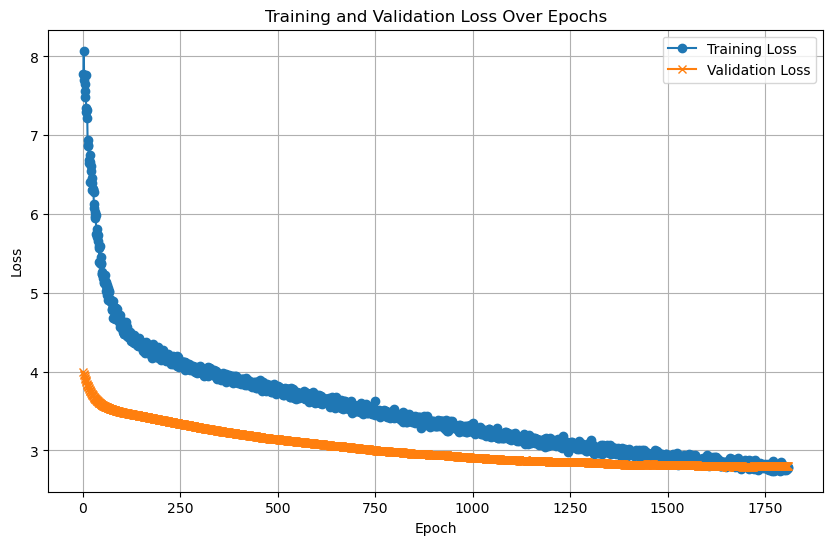

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/12], Loss: 5.0199

Test Loss: 4.9202


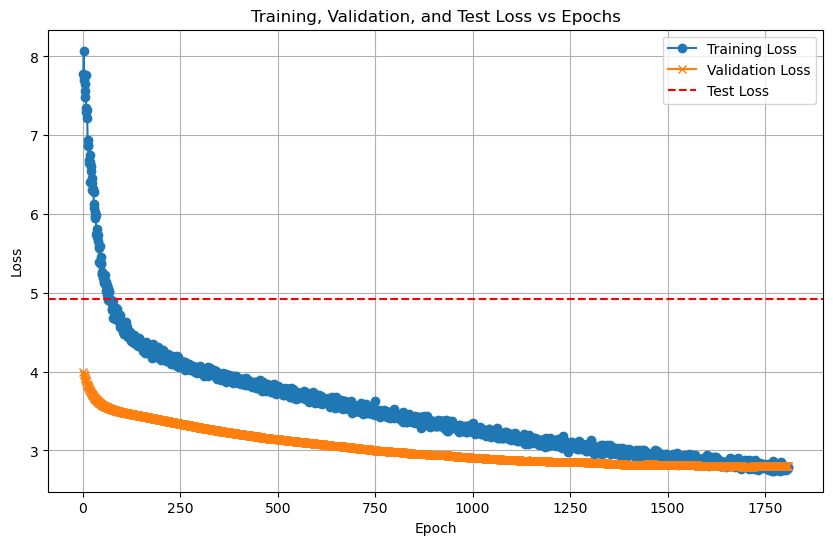

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 78.57%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       0.80      0.80      0.80         5
           3       0.83      1.00      0.91         5
           4       0.50      0.80      0.62         5
           5       0.25      0.20      0.22         5
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         5
           8       0.50      0.40      0.44         5
           9       0.62      1.00      0.77         5
          10       1.00      0.80      0.89         5
          11       1.00      1.00      1.00         5
          12       0.75      0.60      0.67         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6383  |  Val Loss: 2.6282
Validation loss improved from inf to 2.6282.
[Epoch 2/1000] Train Loss: 2.6157  |  Val Loss: 2.6084
Validation loss improved from 2.6282 to 2.6084.
[Epoch 3/1000] Train Loss: 2.5936  |  Val Loss: 2.5906
Validation loss improved from 2.6084 to 2.5906.
[Epoch 4/1000] Train Loss: 2.5754  |  Val Loss: 2.5737
Validation loss improved from 2.5906 to 2.5737.
[Epoch 5/1000] Train Loss: 2.5571  |  Val Loss: 2.5577
Validation loss improved from 2.5737 to 2.5577.
[Epoch 6/1000] Train Loss: 2.5408  |  Val Loss: 2.5428
Validation loss improved from 2.5577 to 2.5428.
[Epoch 7/1000] Train Loss: 2.5232  |  Val Loss: 2.5288
Validation loss improved from 2.5428 to 2.5288.
[Epoch 8/1000] Train Loss: 2.5084  |  Val Loss: 2.5155
Validation loss improved from 2.5288 to 2.5155.
[Epoch 9/1000] Train Loss: 2.4933  |  Val Loss: 2.5028
Validation loss improved from 2.5155 to 2.5028.
[Epoch 10/1000] Train Loss: 2.4787  |  Val Loss: 2.4902
Validation loss impr

[Epoch 20/1000] Train Loss: 2.3364  |  Val Loss: 2.3727
Validation loss improved from 2.3818 to 2.3727.
[Epoch 21/1000] Train Loss: 2.3255  |  Val Loss: 2.3642
Validation loss improved from 2.3727 to 2.3642.
[Epoch 22/1000] Train Loss: 2.3150  |  Val Loss: 2.3560
Validation loss improved from 2.3642 to 2.3560.
[Epoch 23/1000] Train Loss: 2.3045  |  Val Loss: 2.3480
Validation loss improved from 2.3560 to 2.3480.
[Epoch 24/1000] Train Loss: 2.2943  |  Val Loss: 2.3399
Validation loss improved from 2.3480 to 2.3399.
[Epoch 25/1000] Train Loss: 2.2838  |  Val Loss: 2.3320
Validation loss improved from 2.3399 to 2.3320.
[Epoch 26/1000] Train Loss: 2.2738  |  Val Loss: 2.3240
Validation loss improved from 2.3320 to 2.3240.
[Epoch 27/1000] Train Loss: 2.2642  |  Val Loss: 2.3160
Validation loss improved from 2.3240 to 2.3160.
[Epoch 28/1000] Train Loss: 2.2542  |  Val Loss: 2.3082
Validation loss improved from 2.3160 to 2.3082.


[Epoch 29/1000] Train Loss: 2.2442  |  Val Loss: 2.3000
Validation loss improved from 2.3082 to 2.3000.
[Epoch 30/1000] Train Loss: 2.2340  |  Val Loss: 2.2917
Validation loss improved from 2.3000 to 2.2917.
[Epoch 31/1000] Train Loss: 2.2242  |  Val Loss: 2.2836
Validation loss improved from 2.2917 to 2.2836.
[Epoch 32/1000] Train Loss: 2.2135  |  Val Loss: 2.2756
Validation loss improved from 2.2836 to 2.2756.
[Epoch 33/1000] Train Loss: 2.2038  |  Val Loss: 2.2670
Validation loss improved from 2.2756 to 2.2670.
[Epoch 34/1000] Train Loss: 2.1937  |  Val Loss: 2.2583
Validation loss improved from 2.2670 to 2.2583.
[Epoch 35/1000] Train Loss: 2.1829  |  Val Loss: 2.2499
Validation loss improved from 2.2583 to 2.2499.
[Epoch 36/1000] Train Loss: 2.1726  |  Val Loss: 2.2418
Validation loss improved from 2.2499 to 2.2418.
[Epoch 37/1000] Train Loss: 2.1627  |  Val Loss: 2.2340
Validation loss improved from 2.2418 to 2.2340.
[Epoch 38/1000] Train Loss: 2.1530  |  Val Loss: 2.2264
Validati

[Epoch 51/1000] Train Loss: 2.0356  |  Val Loss: 2.1326
Validation loss improved from 2.1396 to 2.1326.
[Epoch 52/1000] Train Loss: 2.0266  |  Val Loss: 2.1256
Validation loss improved from 2.1326 to 2.1256.
[Epoch 53/1000] Train Loss: 2.0177  |  Val Loss: 2.1184
Validation loss improved from 2.1256 to 2.1184.
[Epoch 54/1000] Train Loss: 2.0092  |  Val Loss: 2.1110
Validation loss improved from 2.1184 to 2.1110.
[Epoch 55/1000] Train Loss: 2.0001  |  Val Loss: 2.1038
Validation loss improved from 2.1110 to 2.1038.
[Epoch 56/1000] Train Loss: 1.9912  |  Val Loss: 2.0966
Validation loss improved from 2.1038 to 2.0966.
[Epoch 57/1000] Train Loss: 1.9824  |  Val Loss: 2.0892
Validation loss improved from 2.0966 to 2.0892.
[Epoch 58/1000] Train Loss: 1.9735  |  Val Loss: 2.0818
Validation loss improved from 2.0892 to 2.0818.
[Epoch 59/1000] Train Loss: 1.9643  |  Val Loss: 2.0745
Validation loss improved from 2.0818 to 2.0745.


[Epoch 60/1000] Train Loss: 1.9553  |  Val Loss: 2.0670
Validation loss improved from 2.0745 to 2.0670.
[Epoch 61/1000] Train Loss: 1.9462  |  Val Loss: 2.0592
Validation loss improved from 2.0670 to 2.0592.
[Epoch 62/1000] Train Loss: 1.9369  |  Val Loss: 2.0515
Validation loss improved from 2.0592 to 2.0515.
[Epoch 63/1000] Train Loss: 1.9277  |  Val Loss: 2.0437
Validation loss improved from 2.0515 to 2.0437.
[Epoch 64/1000] Train Loss: 1.9184  |  Val Loss: 2.0358
Validation loss improved from 2.0437 to 2.0358.
[Epoch 65/1000] Train Loss: 1.9093  |  Val Loss: 2.0280
Validation loss improved from 2.0358 to 2.0280.
[Epoch 66/1000] Train Loss: 1.9000  |  Val Loss: 2.0201
Validation loss improved from 2.0280 to 2.0201.
[Epoch 67/1000] Train Loss: 1.8906  |  Val Loss: 2.0123
Validation loss improved from 2.0201 to 2.0123.
[Epoch 68/1000] Train Loss: 1.8811  |  Val Loss: 2.0046
Validation loss improved from 2.0123 to 2.0046.
[Epoch 69/1000] Train Loss: 1.8716  |  Val Loss: 1.9971
Validati

[Epoch 82/1000] Train Loss: 1.7484  |  Val Loss: 1.8984
Validation loss improved from 1.9059 to 1.8984.
[Epoch 83/1000] Train Loss: 1.7391  |  Val Loss: 1.8908
Validation loss improved from 1.8984 to 1.8908.
[Epoch 84/1000] Train Loss: 1.7293  |  Val Loss: 1.8833
Validation loss improved from 1.8908 to 1.8833.
[Epoch 85/1000] Train Loss: 1.7198  |  Val Loss: 1.8760
Validation loss improved from 1.8833 to 1.8760.
[Epoch 86/1000] Train Loss: 1.7104  |  Val Loss: 1.8688
Validation loss improved from 1.8760 to 1.8688.
[Epoch 87/1000] Train Loss: 1.7010  |  Val Loss: 1.8615
Validation loss improved from 1.8688 to 1.8615.
[Epoch 88/1000] Train Loss: 1.6915  |  Val Loss: 1.8539
Validation loss improved from 1.8615 to 1.8539.
[Epoch 89/1000] Train Loss: 1.6817  |  Val Loss: 1.8461
Validation loss improved from 1.8539 to 1.8461.
[Epoch 90/1000] Train Loss: 1.6718  |  Val Loss: 1.8384
Validation loss improved from 1.8461 to 1.8384.


[Epoch 91/1000] Train Loss: 1.6621  |  Val Loss: 1.8307
Validation loss improved from 1.8384 to 1.8307.
[Epoch 92/1000] Train Loss: 1.6521  |  Val Loss: 1.8227
Validation loss improved from 1.8307 to 1.8227.
[Epoch 93/1000] Train Loss: 1.6425  |  Val Loss: 1.8146
Validation loss improved from 1.8227 to 1.8146.
[Epoch 94/1000] Train Loss: 1.6323  |  Val Loss: 1.8064
Validation loss improved from 1.8146 to 1.8064.
[Epoch 95/1000] Train Loss: 1.6222  |  Val Loss: 1.7983
Validation loss improved from 1.8064 to 1.7983.
[Epoch 96/1000] Train Loss: 1.6123  |  Val Loss: 1.7903
Validation loss improved from 1.7983 to 1.7903.
[Epoch 97/1000] Train Loss: 1.6022  |  Val Loss: 1.7825
Validation loss improved from 1.7903 to 1.7825.
[Epoch 98/1000] Train Loss: 1.5924  |  Val Loss: 1.7749
Validation loss improved from 1.7825 to 1.7749.
[Epoch 99/1000] Train Loss: 1.5824  |  Val Loss: 1.7675
Validation loss improved from 1.7749 to 1.7675.
[Epoch 100/1000] Train Loss: 1.5724  |  Val Loss: 1.7603
Validat

[Epoch 114/1000] Train Loss: 1.4341  |  Val Loss: 1.6558
Validation loss improved from 1.6631 to 1.6558.
[Epoch 115/1000] Train Loss: 1.4248  |  Val Loss: 1.6485
Validation loss improved from 1.6558 to 1.6485.
[Epoch 116/1000] Train Loss: 1.4147  |  Val Loss: 1.6415
Validation loss improved from 1.6485 to 1.6415.
[Epoch 117/1000] Train Loss: 1.4051  |  Val Loss: 1.6344
Validation loss improved from 1.6415 to 1.6344.
[Epoch 118/1000] Train Loss: 1.3954  |  Val Loss: 1.6276
Validation loss improved from 1.6344 to 1.6276.
[Epoch 119/1000] Train Loss: 1.3857  |  Val Loss: 1.6209
Validation loss improved from 1.6276 to 1.6209.
[Epoch 120/1000] Train Loss: 1.3763  |  Val Loss: 1.6143
Validation loss improved from 1.6209 to 1.6143.
[Epoch 121/1000] Train Loss: 1.3666  |  Val Loss: 1.6077
Validation loss improved from 1.6143 to 1.6077.
[Epoch 122/1000] Train Loss: 1.3575  |  Val Loss: 1.6013
Validation loss improved from 1.6077 to 1.6013.


[Epoch 123/1000] Train Loss: 1.3484  |  Val Loss: 1.5947
Validation loss improved from 1.6013 to 1.5947.
[Epoch 124/1000] Train Loss: 1.3393  |  Val Loss: 1.5883
Validation loss improved from 1.5947 to 1.5883.
[Epoch 125/1000] Train Loss: 1.3305  |  Val Loss: 1.5817
Validation loss improved from 1.5883 to 1.5817.
[Epoch 126/1000] Train Loss: 1.3212  |  Val Loss: 1.5751
Validation loss improved from 1.5817 to 1.5751.
[Epoch 127/1000] Train Loss: 1.3124  |  Val Loss: 1.5680
Validation loss improved from 1.5751 to 1.5680.
[Epoch 128/1000] Train Loss: 1.3033  |  Val Loss: 1.5608
Validation loss improved from 1.5680 to 1.5608.
[Epoch 129/1000] Train Loss: 1.2946  |  Val Loss: 1.5538
Validation loss improved from 1.5608 to 1.5538.
[Epoch 130/1000] Train Loss: 1.2858  |  Val Loss: 1.5467
Validation loss improved from 1.5538 to 1.5467.
[Epoch 131/1000] Train Loss: 1.2770  |  Val Loss: 1.5396
Validation loss improved from 1.5467 to 1.5396.
[Epoch 132/1000] Train Loss: 1.2685  |  Val Loss: 1.532

[Epoch 142/1000] Train Loss: 1.1843  |  Val Loss: 1.4725
Validation loss improved from 1.4782 to 1.4725.
[Epoch 143/1000] Train Loss: 1.1762  |  Val Loss: 1.4668
Validation loss improved from 1.4725 to 1.4668.
[Epoch 144/1000] Train Loss: 1.1682  |  Val Loss: 1.4612
Validation loss improved from 1.4668 to 1.4612.
[Epoch 145/1000] Train Loss: 1.1603  |  Val Loss: 1.4555
Validation loss improved from 1.4612 to 1.4555.
[Epoch 146/1000] Train Loss: 1.1529  |  Val Loss: 1.4499
Validation loss improved from 1.4555 to 1.4499.
[Epoch 147/1000] Train Loss: 1.1452  |  Val Loss: 1.4446
Validation loss improved from 1.4499 to 1.4446.
[Epoch 148/1000] Train Loss: 1.1376  |  Val Loss: 1.4393
Validation loss improved from 1.4446 to 1.4393.
[Epoch 149/1000] Train Loss: 1.1299  |  Val Loss: 1.4339
Validation loss improved from 1.4393 to 1.4339.
[Epoch 150/1000] Train Loss: 1.1224  |  Val Loss: 1.4282
Validation loss improved from 1.4339 to 1.4282.


[Epoch 151/1000] Train Loss: 1.1144  |  Val Loss: 1.4226
Validation loss improved from 1.4282 to 1.4226.
[Epoch 152/1000] Train Loss: 1.1070  |  Val Loss: 1.4169
Validation loss improved from 1.4226 to 1.4169.
[Epoch 153/1000] Train Loss: 1.0992  |  Val Loss: 1.4114
Validation loss improved from 1.4169 to 1.4114.
[Epoch 154/1000] Train Loss: 1.0916  |  Val Loss: 1.4061
Validation loss improved from 1.4114 to 1.4061.
[Epoch 155/1000] Train Loss: 1.0841  |  Val Loss: 1.4010
Validation loss improved from 1.4061 to 1.4010.
[Epoch 156/1000] Train Loss: 1.0763  |  Val Loss: 1.3964
Validation loss improved from 1.4010 to 1.3964.
[Epoch 157/1000] Train Loss: 1.0687  |  Val Loss: 1.3918
Validation loss improved from 1.3964 to 1.3918.
[Epoch 158/1000] Train Loss: 1.0613  |  Val Loss: 1.3871
Validation loss improved from 1.3918 to 1.3871.
[Epoch 159/1000] Train Loss: 1.0537  |  Val Loss: 1.3822
Validation loss improved from 1.3871 to 1.3822.
[Epoch 160/1000] Train Loss: 1.0465  |  Val Loss: 1.377

[Epoch 173/1000] Train Loss: 0.9522  |  Val Loss: 1.3143
Validation loss improved from 1.3191 to 1.3143.
[Epoch 174/1000] Train Loss: 0.9452  |  Val Loss: 1.3097
Validation loss improved from 1.3143 to 1.3097.
[Epoch 175/1000] Train Loss: 0.9384  |  Val Loss: 1.3056
Validation loss improved from 1.3097 to 1.3056.
[Epoch 176/1000] Train Loss: 0.9312  |  Val Loss: 1.3015
Validation loss improved from 1.3056 to 1.3015.
[Epoch 177/1000] Train Loss: 0.9240  |  Val Loss: 1.2970
Validation loss improved from 1.3015 to 1.2970.
[Epoch 178/1000] Train Loss: 0.9169  |  Val Loss: 1.2926
Validation loss improved from 1.2970 to 1.2926.
[Epoch 179/1000] Train Loss: 0.9103  |  Val Loss: 1.2882
Validation loss improved from 1.2926 to 1.2882.
[Epoch 180/1000] Train Loss: 0.9035  |  Val Loss: 1.2839
Validation loss improved from 1.2882 to 1.2839.
[Epoch 181/1000] Train Loss: 0.8970  |  Val Loss: 1.2797
Validation loss improved from 1.2839 to 1.2797.


[Epoch 182/1000] Train Loss: 0.8903  |  Val Loss: 1.2750
Validation loss improved from 1.2797 to 1.2750.
[Epoch 183/1000] Train Loss: 0.8838  |  Val Loss: 1.2705
Validation loss improved from 1.2750 to 1.2705.
[Epoch 184/1000] Train Loss: 0.8774  |  Val Loss: 1.2661
Validation loss improved from 1.2705 to 1.2661.
[Epoch 185/1000] Train Loss: 0.8710  |  Val Loss: 1.2618
Validation loss improved from 1.2661 to 1.2618.
[Epoch 186/1000] Train Loss: 0.8645  |  Val Loss: 1.2576
Validation loss improved from 1.2618 to 1.2576.
[Epoch 187/1000] Train Loss: 0.8580  |  Val Loss: 1.2537
Validation loss improved from 1.2576 to 1.2537.
[Epoch 188/1000] Train Loss: 0.8514  |  Val Loss: 1.2501
Validation loss improved from 1.2537 to 1.2501.
[Epoch 189/1000] Train Loss: 0.8449  |  Val Loss: 1.2468
Validation loss improved from 1.2501 to 1.2468.
[Epoch 190/1000] Train Loss: 0.8385  |  Val Loss: 1.2434
Validation loss improved from 1.2468 to 1.2434.
[Epoch 191/1000] Train Loss: 0.8324  |  Val Loss: 1.239

[Epoch 206/1000] Train Loss: 0.7426  |  Val Loss: 1.1939
Validation loss improved from 1.1969 to 1.1939.
[Epoch 207/1000] Train Loss: 0.7372  |  Val Loss: 1.1909
Validation loss improved from 1.1939 to 1.1909.
[Epoch 208/1000] Train Loss: 0.7314  |  Val Loss: 1.1878
Validation loss improved from 1.1909 to 1.1878.
[Epoch 209/1000] Train Loss: 0.7258  |  Val Loss: 1.1851
Validation loss improved from 1.1878 to 1.1851.
[Epoch 210/1000] Train Loss: 0.7201  |  Val Loss: 1.1826
Validation loss improved from 1.1851 to 1.1826.
[Epoch 211/1000] Train Loss: 0.7145  |  Val Loss: 1.1798
Validation loss improved from 1.1826 to 1.1798.
[Epoch 212/1000] Train Loss: 0.7089  |  Val Loss: 1.1764
Validation loss improved from 1.1798 to 1.1764.


[Epoch 213/1000] Train Loss: 0.7033  |  Val Loss: 1.1731
Validation loss improved from 1.1764 to 1.1731.
[Epoch 214/1000] Train Loss: 0.6978  |  Val Loss: 1.1699
Validation loss improved from 1.1731 to 1.1699.
[Epoch 215/1000] Train Loss: 0.6921  |  Val Loss: 1.1665
Validation loss improved from 1.1699 to 1.1665.
[Epoch 216/1000] Train Loss: 0.6868  |  Val Loss: 1.1624
Validation loss improved from 1.1665 to 1.1624.
[Epoch 217/1000] Train Loss: 0.6812  |  Val Loss: 1.1583
Validation loss improved from 1.1624 to 1.1583.
[Epoch 218/1000] Train Loss: 0.6755  |  Val Loss: 1.1543
Validation loss improved from 1.1583 to 1.1543.
[Epoch 219/1000] Train Loss: 0.6701  |  Val Loss: 1.1505
Validation loss improved from 1.1543 to 1.1505.
[Epoch 220/1000] Train Loss: 0.6648  |  Val Loss: 1.1468
Validation loss improved from 1.1505 to 1.1468.
[Epoch 221/1000] Train Loss: 0.6596  |  Val Loss: 1.1440
Validation loss improved from 1.1468 to 1.1440.
[Epoch 222/1000] Train Loss: 0.6545  |  Val Loss: 1.141

[Epoch 235/1000] Train Loss: 0.5892  |  Val Loss: 1.1075
Validation loss improved from 1.1085 to 1.1075.
[Epoch 236/1000] Train Loss: 0.5843  |  Val Loss: 1.1067
Validation loss improved from 1.1075 to 1.1067.
[Epoch 237/1000] Train Loss: 0.5796  |  Val Loss: 1.1061
Validation loss improved from 1.1067 to 1.1061.
[Epoch 238/1000] Train Loss: 0.5747  |  Val Loss: 1.1049
Validation loss improved from 1.1061 to 1.1049.
[Epoch 239/1000] Train Loss: 0.5700  |  Val Loss: 1.1029
Validation loss improved from 1.1049 to 1.1029.


[Epoch 240/1000] Train Loss: 0.5653  |  Val Loss: 1.1001
Validation loss improved from 1.1029 to 1.1001.
[Epoch 241/1000] Train Loss: 0.5606  |  Val Loss: 1.0976
Validation loss improved from 1.1001 to 1.0976.
[Epoch 242/1000] Train Loss: 0.5561  |  Val Loss: 1.0951
Validation loss improved from 1.0976 to 1.0951.
[Epoch 243/1000] Train Loss: 0.5516  |  Val Loss: 1.0923
Validation loss improved from 1.0951 to 1.0923.
[Epoch 244/1000] Train Loss: 0.5471  |  Val Loss: 1.0896
Validation loss improved from 1.0923 to 1.0896.
[Epoch 245/1000] Train Loss: 0.5429  |  Val Loss: 1.0870
Validation loss improved from 1.0896 to 1.0870.
[Epoch 246/1000] Train Loss: 0.5386  |  Val Loss: 1.0843
Validation loss improved from 1.0870 to 1.0843.
[Epoch 247/1000] Train Loss: 0.5346  |  Val Loss: 1.0816
Validation loss improved from 1.0843 to 1.0816.
[Epoch 248/1000] Train Loss: 0.5304  |  Val Loss: 1.0792
Validation loss improved from 1.0816 to 1.0792.
[Epoch 249/1000] Train Loss: 0.5260  |  Val Loss: 1.076

[Epoch 265/1000] Train Loss: 0.4598  |  Val Loss: 1.0437
Validation loss improved from 1.0445 to 1.0437.
[Epoch 266/1000] Train Loss: 0.4557  |  Val Loss: 1.0430
Validation loss improved from 1.0437 to 1.0430.
[Epoch 267/1000] Train Loss: 0.4522  |  Val Loss: 1.0421
Validation loss improved from 1.0430 to 1.0421.
[Epoch 268/1000] Train Loss: 0.4481  |  Val Loss: 1.0411
Validation loss improved from 1.0421 to 1.0411.
[Epoch 269/1000] Train Loss: 0.4443  |  Val Loss: 1.0403
Validation loss improved from 1.0411 to 1.0403.
[Epoch 270/1000] Train Loss: 0.4404  |  Val Loss: 1.0391
Validation loss improved from 1.0403 to 1.0391.
[Epoch 271/1000] Train Loss: 0.4367  |  Val Loss: 1.0383
Validation loss improved from 1.0391 to 1.0383.


[Epoch 272/1000] Train Loss: 0.4332  |  Val Loss: 1.0375
Validation loss improved from 1.0383 to 1.0375.
[Epoch 273/1000] Train Loss: 0.4298  |  Val Loss: 1.0360
Validation loss improved from 1.0375 to 1.0360.
[Epoch 274/1000] Train Loss: 0.4264  |  Val Loss: 1.0346
Validation loss improved from 1.0360 to 1.0346.
[Epoch 275/1000] Train Loss: 0.4234  |  Val Loss: 1.0327
Validation loss improved from 1.0346 to 1.0327.
[Epoch 276/1000] Train Loss: 0.4198  |  Val Loss: 1.0311
Validation loss improved from 1.0327 to 1.0311.
[Epoch 277/1000] Train Loss: 0.4162  |  Val Loss: 1.0299
Validation loss improved from 1.0311 to 1.0299.
[Epoch 278/1000] Train Loss: 0.4130  |  Val Loss: 1.0291
Validation loss improved from 1.0299 to 1.0291.
[Epoch 279/1000] Train Loss: 0.4091  |  Val Loss: 1.0284
Validation loss improved from 1.0291 to 1.0284.
[Epoch 280/1000] Train Loss: 0.4055  |  Val Loss: 1.0272
Validation loss improved from 1.0284 to 1.0272.
[Epoch 281/1000] Train Loss: 0.4020  |  Val Loss: 1.026

[Epoch 297/1000] Train Loss: 0.3485  |  Val Loss: 1.0121
Validation loss improved from 1.0140 to 1.0121.
[Epoch 298/1000] Train Loss: 0.3458  |  Val Loss: 1.0099
Validation loss improved from 1.0121 to 1.0099.
[Epoch 299/1000] Train Loss: 0.3426  |  Val Loss: 1.0076
Validation loss improved from 1.0099 to 1.0076.
[Epoch 300/1000] Train Loss: 0.3396  |  Val Loss: 1.0056
Validation loss improved from 1.0076 to 1.0056.
[Epoch 301/1000] Train Loss: 0.3367  |  Val Loss: 1.0036
Validation loss improved from 1.0056 to 1.0036.
[Epoch 302/1000] Train Loss: 0.3341  |  Val Loss: 1.0014
Validation loss improved from 1.0036 to 1.0014.
[Epoch 303/1000] Train Loss: 0.3315  |  Val Loss: 1.0006
Validation loss improved from 1.0014 to 1.0006.
[Epoch 304/1000] Train Loss: 0.3288  |  Val Loss: 1.0003
Validation loss improved from 1.0006 to 1.0003.


[Epoch 305/1000] Train Loss: 0.3261  |  Val Loss: 1.0003
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 306/1000] Train Loss: 0.3232  |  Val Loss: 1.0000
Validation loss improved from 1.0003 to 1.0000.
[Epoch 307/1000] Train Loss: 0.3203  |  Val Loss: 1.0003
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 308/1000] Train Loss: 0.3177  |  Val Loss: 1.0009
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 309/1000] Train Loss: 0.3148  |  Val Loss: 1.0017
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 310/1000] Train Loss: 0.3124  |  Val Loss: 1.0021
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 311/1000] Train Loss: 0.3098  |  Val Loss: 1.0023
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 312/1000] Train Loss: 0.3071  |  Val Loss: 1.0023
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 313/1000] Train Loss: 0.3046  |  Val Loss: 1.0026
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 

[Epoch 326/1000] Train Loss: 0.2727  |  Val Loss: 0.9955
Validation loss improved from 0.9959 to 0.9955.
[Epoch 327/1000] Train Loss: 0.2707  |  Val Loss: 0.9958
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 328/1000] Train Loss: 0.2682  |  Val Loss: 0.9965
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 329/1000] Train Loss: 0.2661  |  Val Loss: 0.9971
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 330/1000] Train Loss: 0.2638  |  Val Loss: 0.9970
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 331/1000] Train Loss: 0.2617  |  Val Loss: 0.9964
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 332/1000] Train Loss: 0.2595  |  Val Loss: 0.9963
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 333/1000] Train Loss: 0.2573  |  Val Loss: 0.9963
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 334/1000] Train Loss: 0.2551  |  Val Loss: 0.9962
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 337/1000] Train Loss: 0.2489  |  Val Loss: 0.9935
Validation loss improved from 0.9942 to 0.9935.
[Epoch 338/1000] Train Loss: 0.2468  |  Val Loss: 0.9924
Validation loss improved from 0.9935 to 0.9924.
[Epoch 339/1000] Train Loss: 0.2449  |  Val Loss: 0.9909
Validation loss improved from 0.9924 to 0.9909.
[Epoch 340/1000] Train Loss: 0.2430  |  Val Loss: 0.9898
Validation loss improved from 0.9909 to 0.9898.
[Epoch 341/1000] Train Loss: 0.2412  |  Val Loss: 0.9894
Validation loss improved from 0.9898 to 0.9894.
[Epoch 342/1000] Train Loss: 0.2391  |  Val Loss: 0.9896
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 343/1000] Train Loss: 0.2372  |  Val Loss: 0.9897
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 344/1000] Train Loss: 0.2353  |  Val Loss: 0.9893
Validation loss improved from 0.9894 to 0.9893.
[Epoch 345/1000] Train Loss: 0.2333  |  Val Loss: 0.9886
Validation loss improved from 0.9893 to 0.9886.
[Epoch 346/1000] Train Loss: 0.2315  |  Val

[Epoch 355/1000] Train Loss: 0.2147  |  Val Loss: 0.9810
Validation loss improved from 0.9820 to 0.9810.
[Epoch 356/1000] Train Loss: 0.2129  |  Val Loss: 0.9793
Validation loss improved from 0.9810 to 0.9793.
[Epoch 357/1000] Train Loss: 0.2111  |  Val Loss: 0.9781
Validation loss improved from 0.9793 to 0.9781.
[Epoch 358/1000] Train Loss: 0.2093  |  Val Loss: 0.9771
Validation loss improved from 0.9781 to 0.9771.
[Epoch 359/1000] Train Loss: 0.2077  |  Val Loss: 0.9761
Validation loss improved from 0.9771 to 0.9761.
[Epoch 360/1000] Train Loss: 0.2058  |  Val Loss: 0.9756
Validation loss improved from 0.9761 to 0.9756.
[Epoch 361/1000] Train Loss: 0.2043  |  Val Loss: 0.9755
Validation loss improved from 0.9756 to 0.9755.
[Epoch 362/1000] Train Loss: 0.2025  |  Val Loss: 0.9757
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 363/1000] Train Loss: 0.2009  |  Val Loss: 0.9765
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 364/1000] Train Loss: 0.1993  |  Val

[Epoch 369/1000] Train Loss: 0.1914  |  Val Loss: 0.9809
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 370/1000] Train Loss: 0.1898  |  Val Loss: 0.9812
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 371/1000] Train Loss: 0.1883  |  Val Loss: 0.9817
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 372/1000] Train Loss: 0.1868  |  Val Loss: 0.9819
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 373/1000] Train Loss: 0.1852  |  Val Loss: 0.9820
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 374/1000] Train Loss: 0.1838  |  Val Loss: 0.9822
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 375/1000] Train Loss: 0.1825  |  Val Loss: 0.9827
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 376/1000] Train Loss: 0.1811  |  Val Loss: 0.9833
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 377/1000] Train Loss: 0.1794  |  Val Loss: 0.9842
!! Validation loss did NOT improve !! Patience: 1

[Epoch 385/1000] Train Loss: 0.1685  |  Val Loss: 0.9847
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 386/1000] Train Loss: 0.1671  |  Val Loss: 0.9855
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 387/1000] Train Loss: 0.1659  |  Val Loss: 0.9861
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 388/1000] Train Loss: 0.1646  |  Val Loss: 0.9866
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 389/1000] Train Loss: 0.1634  |  Val Loss: 0.9870
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 390/1000] Train Loss: 0.1621  |  Val Loss: 0.9875
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 391/1000] Train Loss: 0.1609  |  Val Loss: 0.9882
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 392/1000] Train Loss: 0.1596  |  Val Loss: 0.9885
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 393/1000] Train Loss: 0.1583  |  Val Loss: 0.9888
!! Validation loss did NOT improve !! Patience:

[Epoch 398/1000] Train Loss: 0.1523  |  Val Loss: 0.9912
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 399/1000] Train Loss: 0.1512  |  Val Loss: 0.9923
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 400/1000] Train Loss: 0.1500  |  Val Loss: 0.9931
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 401/1000] Train Loss: 0.1490  |  Val Loss: 0.9930
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 402/1000] Train Loss: 0.1479  |  Val Loss: 0.9928
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 403/1000] Train Loss: 0.1467  |  Val Loss: 0.9931
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 404/1000] Train Loss: 0.1458  |  Val Loss: 0.9933
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 405/1000] Train Loss: 0.1445  |  Val Loss: 0.9930
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 406/1000] Train Loss: 0.1434  |  Val Loss: 0.9927
!! Validation loss did NOT improve !! Patience:

[Epoch 416/1000] Train Loss: 0.1330  |  Val Loss: 0.9961
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 417/1000] Train Loss: 0.1320  |  Val Loss: 0.9965
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 418/1000] Train Loss: 0.1310  |  Val Loss: 0.9971
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 419/1000] Train Loss: 0.1302  |  Val Loss: 0.9976
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 420/1000] Train Loss: 0.1292  |  Val Loss: 0.9985
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 421/1000] Train Loss: 0.1283  |  Val Loss: 0.9997
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 422/1000] Train Loss: 0.1276  |  Val Loss: 1.0012
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 423/1000] Train Loss: 0.1266  |  Val Loss: 1.0019
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 424/1000] Train Loss: 0.1257  |  Val Loss: 1.0025
!! Validation loss did NOT improve !! Patience:

[Epoch 428/1000] Train Loss: 0.1223  |  Val Loss: 1.0053
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 429/1000] Train Loss: 0.1213  |  Val Loss: 1.0065
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 430/1000] Train Loss: 0.1206  |  Val Loss: 1.0075
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 431/1000] Train Loss: 0.1198  |  Val Loss: 1.0078
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 432/1000] Train Loss: 0.1189  |  Val Loss: 1.0066
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 433/1000] Train Loss: 0.1180  |  Val Loss: 1.0048
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 434/1000] Train Loss: 0.1172  |  Val Loss: 1.0038
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 435/1000] Train Loss: 0.1163  |  Val Loss: 1.0040
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 436/1000] Train Loss: 0.1156  |  Val Loss: 1.0042
!! Validation loss did NOT improve !! Patience:

[Epoch 447/1000] Train Loss: 0.1069  |  Val Loss: 1.0072
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 448/1000] Train Loss: 0.1061  |  Val Loss: 1.0081
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 449/1000] Train Loss: 0.1053  |  Val Loss: 1.0090
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 450/1000] Train Loss: 0.1047  |  Val Loss: 1.0098
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 451/1000] Train Loss: 0.1039  |  Val Loss: 1.0100
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 452/1000] Train Loss: 0.1033  |  Val Loss: 1.0098
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 453/1000] Train Loss: 0.1025  |  Val Loss: 1.0100
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 454/1000] Train Loss: 0.1018  |  Val Loss: 1.0101
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 455/1000] Train Loss: 0.1011  |  Val Loss: 1.0099
!! Validation loss did NOT improve !! Patience:

[Epoch 457/1000] Train Loss: 0.0997  |  Val Loss: 1.0107
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 458/1000] Train Loss: 0.0990  |  Val Loss: 1.0116
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 459/1000] Train Loss: 0.0983  |  Val Loss: 1.0126
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 460/1000] Train Loss: 0.0977  |  Val Loss: 1.0135
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 461/1000] Train Loss: 0.0971  |  Val Loss: 1.0148
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 461 !!
No improvement for 100 epochs.


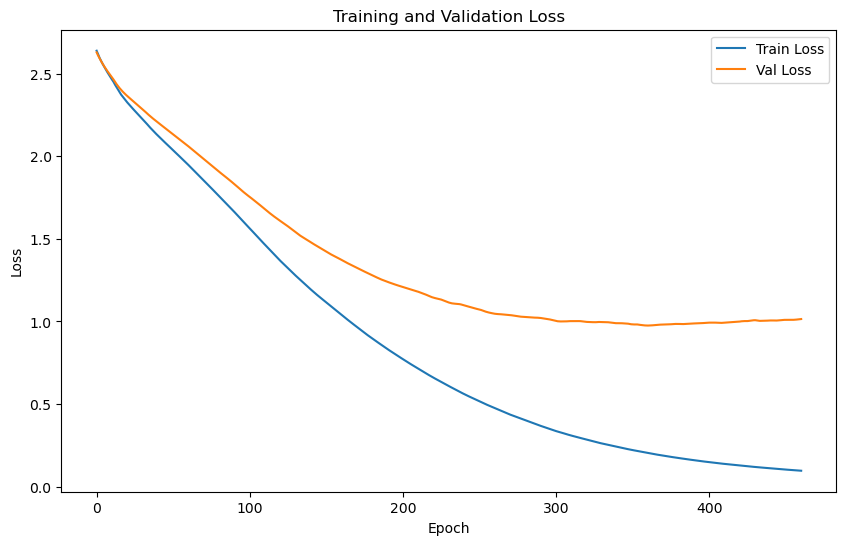

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.8485 | Test Accuracy: 76.50%


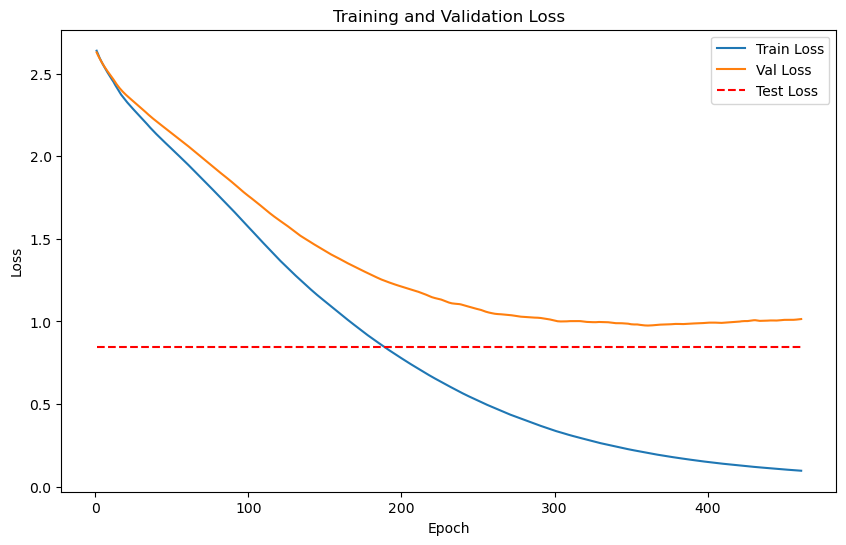

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 140 samples with 64 features each
LOG: Labels shape: (140,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3038 samples with 64 features each
LOG: Labels shape: (3038,)


Train embeddings shape: (140, 64), 
Train labels shape: (140,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3038, 64), 
Test labels shape: (3038,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10, 13: 10}
Training batch size: 140


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.2652
Epoch [1/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.3691

Validation loss improved from inf to 0.3691. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4842
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4731
    Batch [2/2], Val Loss: 0.2657
Epoch [2/2000], Avg Train Loss: 0.4842, Avg Val Loss: 0.3694

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.2656
Epoch [3/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.3695

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4847
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4736
    Batch [2/2], Val Loss: 0.2656
Epoch [4/2000], Avg Train Loss: 0.4847, Avg Val Loss: 0.3696

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4898
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4738
    Batch [2/2], Val Loss: 0.2657
Epoch [5/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.3697

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4739
    Batch [2/2], Val Loss: 0.2653
Epoch [6/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.3696

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.4851
LOG: Epoch [7/2000] - Validation


    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.2680
Epoch [7/2000], Avg Train Loss: 0.4851, Avg Val Loss: 0.3710

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training
    Batch [1/1], Train Loss: 0.4839
LOG: Epoch [8/2000] - Validation


    Batch [1/2], Val Loss: 0.4741
    Batch [2/2], Val Loss: 0.2705
Epoch [8/2000], Avg Train Loss: 0.4839, Avg Val Loss: 0.3723

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.4829
LOG: Epoch [9/2000] - Validation


    Batch [1/2], Val Loss: 0.4743
    Batch [2/2], Val Loss: 0.2715
Epoch [9/2000], Avg Train Loss: 0.4829, Avg Val Loss: 0.3729

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4782
LOG: Epoch [10/2000] - Validation


    Batch [1/2], Val Loss: 0.4743
    Batch [2/2], Val Loss: 0.2715
Epoch [10/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.3729

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4791
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4740
    Batch [2/2], Val Loss: 0.2720
Epoch [11/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.3730

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4735
    Batch [2/2], Val Loss: 0.2724
Epoch [12/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.3730

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4808
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4731
    Batch [2/2], Val Loss: 0.2727
Epoch [13/2000], Avg Train Loss: 0.4808, Avg Val Loss: 0.3729

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4724
    Batch [2/2], Val Loss: 0.2728
Epoch [14/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.3726

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4772
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4711
    Batch [2/2], Val Loss: 0.2695
Epoch [15/2000], Avg Train Loss: 0.4772, Avg Val Loss: 0.3703

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4767
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.2654
Epoch [16/2000], Avg Train Loss: 0.4767, Avg Val Loss: 0.3677

Validation loss improved from 0.3691 to 0.3677. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4697
    Batch [2/2], Val Loss: 0.2604
Epoch [17/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.3650

Validation loss improved from 0.3677 to 0.3650. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4774
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.2554
Epoch [18/2000], Avg Train Loss: 0.4774, Avg Val Loss: 0.3627

Validation loss improved from 0.3650 to 0.3627. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4816
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4695
    Batch [2/2], Val Loss: 0.2494
Epoch [19/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.3595

Validation loss improved from 0.3627 to 0.3595. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4764
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4695
    Batch [2/2], Val Loss: 0.2434
Epoch [20/2000], Avg Train Loss: 0.4764, Avg Val Loss: 0.3564

Validation loss improved from 0.3595 to 0.3564. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4724
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.2374
Epoch [21/2000], Avg Train Loss: 0.4724, Avg Val Loss: 0.3534

Validation loss improved from 0.3564 to 0.3534. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4755
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.2313
Epoch [22/2000], Avg Train Loss: 0.4755, Avg Val Loss: 0.3499

Validation loss improved from 0.3534 to 0.3499. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.2243
Epoch [23/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.3461

Validation loss improved from 0.3499 to 0.3461. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4670
    Batch [2/2], Val Loss: 0.2179
Epoch [24/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.3425

Validation loss improved from 0.3461 to 0.3425. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4728
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4667
    Batch [2/2], Val Loss: 0.2115
Epoch [25/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.3391

Validation loss improved from 0.3425 to 0.3391. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4666
    Batch [2/2], Val Loss: 0.2067
Epoch [26/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.3367

Validation loss improved from 0.3391 to 0.3367. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4701
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4663
    Batch [2/2], Val Loss: 0.2028
Epoch [27/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.3345

Validation loss improved from 0.3367 to 0.3345. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4748
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.2002
Epoch [28/2000], Avg Train Loss: 0.4748, Avg Val Loss: 0.3330

Validation loss improved from 0.3345 to 0.3330. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4714
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4650
    Batch [2/2], Val Loss: 0.1994
Epoch [29/2000], Avg Train Loss: 0.4714, Avg Val Loss: 0.3322

Validation loss improved from 0.3330 to 0.3322. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4641
    Batch [2/2], Val Loss: 0.1995
Epoch [30/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.3318

Validation loss improved from 0.3322 to 0.3318. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4627
    Batch [2/2], Val Loss: 0.1998
Epoch [31/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.3313

Validation loss improved from 0.3318 to 0.3313. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.2007
Epoch [32/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.3312

Validation loss improved from 0.3313 to 0.3312. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4628
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.2015
Epoch [33/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.3310

Validation loss improved from 0.3312 to 0.3310. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4631
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.2024
Epoch [34/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.3309

Validation loss improved from 0.3310 to 0.3309. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4581
    Batch [2/2], Val Loss: 0.2029
Epoch [35/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.3305

Validation loss improved from 0.3309 to 0.3305. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4654
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4566
    Batch [2/2], Val Loss: 0.2036
Epoch [36/2000], Avg Train Loss: 0.4654, Avg Val Loss: 0.3301

Validation loss improved from 0.3305 to 0.3301. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4633
LOG: Epoch [37/2000] - Validation


    Batch [1/2], Val Loss: 0.4551
    Batch [2/2], Val Loss: 0.2044
Epoch [37/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.3298

Validation loss improved from 0.3301 to 0.3298. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4536
    Batch [2/2], Val Loss: 0.2054
Epoch [38/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.3295

Validation loss improved from 0.3298 to 0.3295. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4605
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4519
    Batch [2/2], Val Loss: 0.2066
Epoch [39/2000], Avg Train Loss: 0.4605, Avg Val Loss: 0.3293

Validation loss improved from 0.3295 to 0.3293. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4503
    Batch [2/2], Val Loss: 0.2078
Epoch [40/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.3291

Validation loss improved from 0.3293 to 0.3291. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4616
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4487
    Batch [2/2], Val Loss: 0.2094
Epoch [41/2000], Avg Train Loss: 0.4616, Avg Val Loss: 0.3291

Validation loss improved from 0.3291 to 0.3291. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4593
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4469
    Batch [2/2], Val Loss: 0.2116
Epoch [42/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.3292

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4449
    Batch [2/2], Val Loss: 0.2137
Epoch [43/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.3293

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4606
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4431
    Batch [2/2], Val Loss: 0.2158
Epoch [44/2000], Avg Train Loss: 0.4606, Avg Val Loss: 0.3295

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4414
    Batch [2/2], Val Loss: 0.2180
Epoch [45/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.3297

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4595
LOG: Epoch [46/2000] - Validation


    Batch [1/2], Val Loss: 0.4397
    Batch [2/2], Val Loss: 0.2204
Epoch [46/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.3301

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [47/2000] - Validation


    Batch [1/2], Val Loss: 0.4381
    Batch [2/2], Val Loss: 0.2225
Epoch [47/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.3303

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4566
LOG: Epoch [48/2000] - Validation


    Batch [1/2], Val Loss: 0.4366
    Batch [2/2], Val Loss: 0.2249
Epoch [48/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.3307

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4350
    Batch [2/2], Val Loss: 0.2272
Epoch [49/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.3311

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4336
    Batch [2/2], Val Loss: 0.2297
Epoch [50/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.3316

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [51/2000] - Validation


    Batch [1/2], Val Loss: 0.4322
    Batch [2/2], Val Loss: 0.2323
Epoch [51/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.3322

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.4521
LOG: Epoch [52/2000] - Validation


    Batch [1/2], Val Loss: 0.4308
    Batch [2/2], Val Loss: 0.2349
Epoch [52/2000], Avg Train Loss: 0.4521, Avg Val Loss: 0.3328

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [53/2000] - Validation


    Batch [1/2], Val Loss: 0.4294
    Batch [2/2], Val Loss: 0.2374
Epoch [53/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.3334

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.4509
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4282


    Batch [2/2], Val Loss: 0.2400
Epoch [54/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.3341

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [55/2000] - Validation


    Batch [1/2], Val Loss: 0.4270
    Batch [2/2], Val Loss: 0.2427
Epoch [55/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.3348

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [56/2000] - Validation


    Batch [1/2], Val Loss: 0.4259
    Batch [2/2], Val Loss: 0.2449
Epoch [56/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.3354

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [57/2000] - Validation


    Batch [1/2], Val Loss: 0.4251
    Batch [2/2], Val Loss: 0.2468
Epoch [57/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.3359

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [58/2000] - Validation


    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.2479
Epoch [58/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [59/2000] - Validation


    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.2491
Epoch [59/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.3362

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.4463
LOG: Epoch [60/2000] - Validation


    Batch [1/2], Val Loss: 0.4226
    Batch [2/2], Val Loss: 0.2505
Epoch [60/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.3366

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4219
    Batch [2/2], Val Loss: 0.2520
Epoch [61/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.3370

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4214
    Batch [2/2], Val Loss: 0.2536
Epoch [62/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.3375

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4209
    Batch [2/2], Val Loss: 0.2551
Epoch [63/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.3380

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4201
    Batch [2/2], Val Loss: 0.2567
Epoch [64/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.3384

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4193
    Batch [2/2], Val Loss: 0.2583
Epoch [65/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.3388

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.2600
Epoch [66/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.3393

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4184
    Batch [2/2], Val Loss: 0.2597
Epoch [67/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4183
    Batch [2/2], Val Loss: 0.2595
Epoch [68/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.3389

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4185
    Batch [2/2], Val Loss: 0.2595
Epoch [69/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.3390

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4188
    Batch [2/2], Val Loss: 0.2593
Epoch [70/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4191
    Batch [2/2], Val Loss: 0.2591
Epoch [71/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.2591
Epoch [72/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.3393

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.2594
Epoch [73/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.3396

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4201
    Batch [2/2], Val Loss: 0.2597
Epoch [74/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.3399

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4379
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4201
    Batch [2/2], Val Loss: 0.2600
Epoch [75/2000], Avg Train Loss: 0.4379, Avg Val Loss: 0.3400

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4425
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4201
    Batch [2/2], Val Loss: 0.2603
Epoch [76/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.3402

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4199
    Batch [2/2], Val Loss: 0.2606
Epoch [77/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.3403

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4198
    Batch [2/2], Val Loss: 0.2609
Epoch [78/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.3403

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4196
    Batch [2/2], Val Loss: 0.2611
Epoch [79/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.3403

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4194
    Batch [2/2], Val Loss: 0.2612
Epoch [80/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.3403

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4192
    Batch [2/2], Val Loss: 0.2613
Epoch [81/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.3403

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4191
    Batch [2/2], Val Loss: 0.2614
Epoch [82/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.3402

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4189
    Batch [2/2], Val Loss: 0.2615
Epoch [83/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.3402

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4187
    Batch [2/2], Val Loss: 0.2615
Epoch [84/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.3401

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4186
    Batch [2/2], Val Loss: 0.2616
Epoch [85/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.3401

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4184
    Batch [2/2], Val Loss: 0.2616
Epoch [86/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.3400

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4183
    Batch [2/2], Val Loss: 0.2616
Epoch [87/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.3400

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4182
    Batch [2/2], Val Loss: 0.2617
Epoch [88/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.3399

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4425
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4181
    Batch [2/2], Val Loss: 0.2617
Epoch [89/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.3399

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [90/2000] - Validation


    Batch [1/2], Val Loss: 0.4180
    Batch [2/2], Val Loss: 0.2616
Epoch [90/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.3398

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [91/2000] - Validation


    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2617
Epoch [91/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.3398

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2617
Epoch [92/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.3397

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.2615
Epoch [93/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.3396

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [94/2000] - Validation


    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.2614
Epoch [94/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.3396

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [95/2000] - Validation


    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.2612
Epoch [95/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.3395

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [96/2000] - Validation


    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.2611
Epoch [96/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.3394

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.2610
Epoch [97/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.3394

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.2609
Epoch [98/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.3393

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4397
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.2608
Epoch [99/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.3393

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.2608
Epoch [100/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.3392

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.2607
Epoch [101/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.3392

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4316
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.2607
Epoch [102/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.3392

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4404
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.2607
Epoch [103/2000], Avg Train Loss: 0.4404, Avg Val Loss: 0.3392

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.2606
Epoch [104/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.3392

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.2606
Epoch [105/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.3392

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.2606
Epoch [106/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.3392

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2606
Epoch [107/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.3392

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2606
Epoch [108/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.3392

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [109/2000] - Validation


    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2605
Epoch [109/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.3392

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [110/2000] - Validation


    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2605
Epoch [110/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [111/2000] - Validation


    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2605
Epoch [111/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [112/2000] - Validation


    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2605
Epoch [112/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [113/2000] - Validation


    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2605
Epoch [113/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [114/2000] - Validation


    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2605
Epoch [114/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [115/2000] - Validation


    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2605
Epoch [115/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [116/2000] - Validation


    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2605
Epoch [116/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [117/2000] - Validation


    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2605
Epoch [117/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [118/2000] - Validation


    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2605
Epoch [118/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [119/2000] - Validation


    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2605
Epoch [119/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [120/2000] - Validation


    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2604
Epoch [120/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.4441
LOG: Epoch [121/2000] - Validation


    Batch [1/2], Val Loss: 0.4178
    Batch [2/2], Val Loss: 0.2604
Epoch [121/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [122/2000] - Validation


    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2604
Epoch [122/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2604
Epoch [123/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4379
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2604
Epoch [124/2000], Avg Train Loss: 0.4379, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2604
Epoch [125/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2604
Epoch [126/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2604
Epoch [127/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2604
Epoch [128/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4337
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2604
Epoch [129/2000], Avg Train Loss: 0.4337, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2604
Epoch [130/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4417
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2604
Epoch [131/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2604
Epoch [132/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2604
Epoch [133/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2604
Epoch [134/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2603
Epoch [135/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2603
Epoch [136/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2603
Epoch [137/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2603
Epoch [138/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2603
Epoch [139/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2603
Epoch [140/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4401
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4179
    Batch [2/2], Val Loss: 0.2603
Epoch [141/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.3391

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 141!!
No improvement for 100 epochs


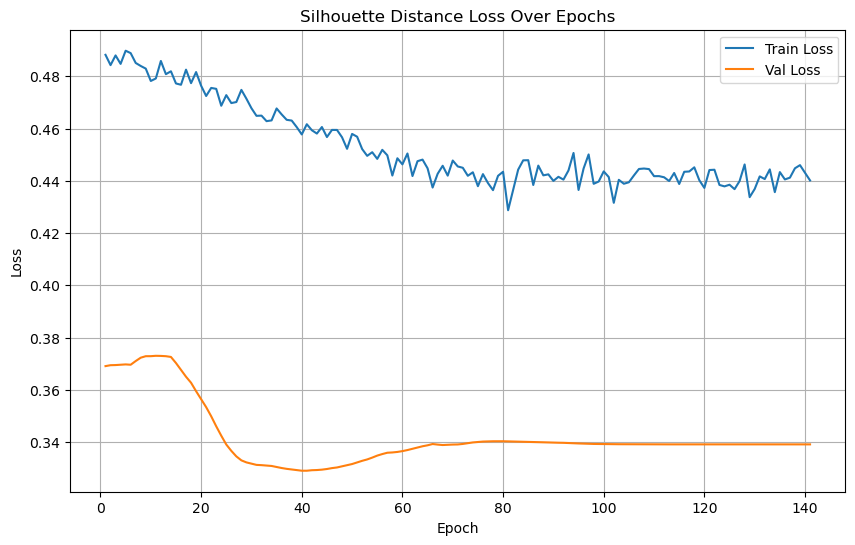

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/48], Loss: 0.3444
Test Batch [20/48], Loss: 0.2980


Test Batch [30/48], Loss: 0.3001
Test Batch [40/48], Loss: 0.5000

Test Loss: 0.3217


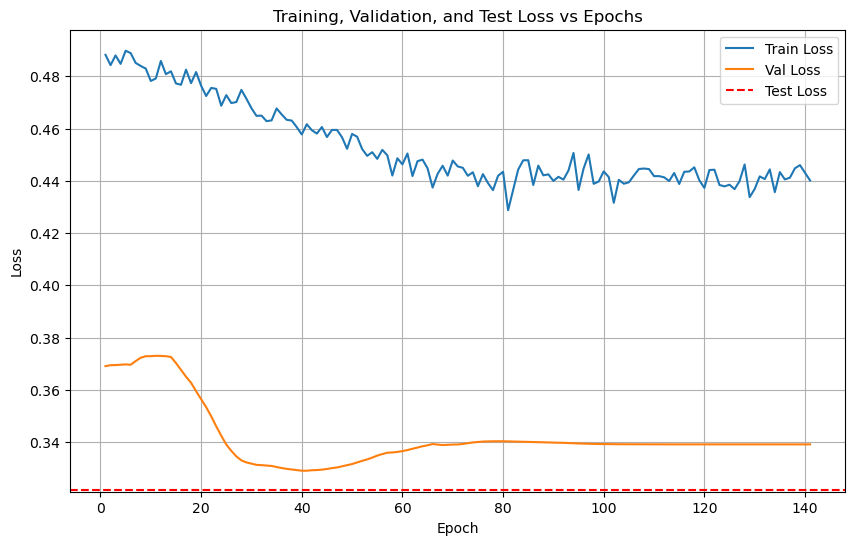

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/48 for test dataset.
  Processed batch 20/48 for test dataset.
  Processed batch 30/48 for test dataset.


  Processed batch 40/48 for test dataset.


Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 74.29%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       0.50      0.40      0.44         5
           3       0.71      1.00      0.83         5
           4       1.00      0.40      0.57         5
           5       0.00      0.00      0.00         5
           6       0.67      0.80      0.73         5
           7       0.83      1.00      0.91         5
           8       0.50      0.60      0.55         5
           9       0.80      0.80      0.80         5
          10       1.00      0.80      0.89         5
          11       0.83      1.00      0.91         5
          12       0.50      0.80      0.62         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (140, 128)
Train labels shape: (140,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3038, 128)
Test labels shape: (3038,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6594  |  Val Loss: 2.6581
Validation loss improved from inf to 2.6581.
[Epoch 2/1000] Train Loss: 2.6473  |  Val Loss: 2.6477
Validation loss improved from 2.6581 to 2.6477.
[Epoch 3/1000] Train Loss: 2.6352  |  Val Loss: 2.6381
Validation loss improved from 2.6477 to 2.6381.
[Epoch 4/1000] Train Loss: 2.6243  |  Val Loss: 2.6289
Validation loss improved from 2.6381 to 2.6289.
[Epoch 5/1000] Train Loss: 2.6144  |  Val Loss: 2.6198
Validation loss improved from 2.6289 to 2.6198.
[Epoch 6/1000] Train Loss: 2.6050  |  Val Loss: 2.6110
Validation loss improved from 2.6198 to 2.6110.
[Epoch 7/1000] Train Loss: 2.5950  |  Val Loss: 2.6029
Validation loss improved from 2.6110 to 2.6029.
[Epoch 8/1000] Train Loss: 2.5863  |  Val Loss: 2.5950
Validation loss improved from 2.6029 to 2.5950.
[Epoch 9/1000] Train Loss: 2.5775  |  Val Loss: 2.5874
Validation loss improved from 2.5950 to 2.5874.
[Epoch 10/1000] Train Loss: 2.5689  |  Val Loss: 2.5798
Validation loss impr

[Epoch 20/1000] Train Loss: 2.4738  |  Val Loss: 2.4913
Validation loss improved from 2.5007 to 2.4913.
[Epoch 21/1000] Train Loss: 2.4639  |  Val Loss: 2.4819
Validation loss improved from 2.4913 to 2.4819.
[Epoch 22/1000] Train Loss: 2.4537  |  Val Loss: 2.4727
Validation loss improved from 2.4819 to 2.4727.
[Epoch 23/1000] Train Loss: 2.4436  |  Val Loss: 2.4633
Validation loss improved from 2.4727 to 2.4633.
[Epoch 24/1000] Train Loss: 2.4340  |  Val Loss: 2.4540
Validation loss improved from 2.4633 to 2.4540.
[Epoch 25/1000] Train Loss: 2.4242  |  Val Loss: 2.4453
Validation loss improved from 2.4540 to 2.4453.
[Epoch 26/1000] Train Loss: 2.4150  |  Val Loss: 2.4371
Validation loss improved from 2.4453 to 2.4371.
[Epoch 27/1000] Train Loss: 2.4053  |  Val Loss: 2.4292
Validation loss improved from 2.4371 to 2.4292.


[Epoch 28/1000] Train Loss: 2.3966  |  Val Loss: 2.4211
Validation loss improved from 2.4292 to 2.4211.
[Epoch 29/1000] Train Loss: 2.3878  |  Val Loss: 2.4131
Validation loss improved from 2.4211 to 2.4131.
[Epoch 30/1000] Train Loss: 2.3790  |  Val Loss: 2.4054
Validation loss improved from 2.4131 to 2.4054.
[Epoch 31/1000] Train Loss: 2.3702  |  Val Loss: 2.3977
Validation loss improved from 2.4054 to 2.3977.
[Epoch 32/1000] Train Loss: 2.3620  |  Val Loss: 2.3900
Validation loss improved from 2.3977 to 2.3900.
[Epoch 33/1000] Train Loss: 2.3534  |  Val Loss: 2.3826
Validation loss improved from 2.3900 to 2.3826.
[Epoch 34/1000] Train Loss: 2.3453  |  Val Loss: 2.3754
Validation loss improved from 2.3826 to 2.3754.
[Epoch 35/1000] Train Loss: 2.3371  |  Val Loss: 2.3683
Validation loss improved from 2.3754 to 2.3683.
[Epoch 36/1000] Train Loss: 2.3289  |  Val Loss: 2.3611
Validation loss improved from 2.3683 to 2.3611.
[Epoch 37/1000] Train Loss: 2.3205  |  Val Loss: 2.3537
Validati

[Epoch 53/1000] Train Loss: 2.1825  |  Val Loss: 2.2327
Validation loss improved from 2.2402 to 2.2327.
[Epoch 54/1000] Train Loss: 2.1738  |  Val Loss: 2.2252
Validation loss improved from 2.2327 to 2.2252.
[Epoch 55/1000] Train Loss: 2.1650  |  Val Loss: 2.2179
Validation loss improved from 2.2252 to 2.2179.
[Epoch 56/1000] Train Loss: 2.1561  |  Val Loss: 2.2105
Validation loss improved from 2.2179 to 2.2105.
[Epoch 57/1000] Train Loss: 2.1473  |  Val Loss: 2.2030
Validation loss improved from 2.2105 to 2.2030.
[Epoch 58/1000] Train Loss: 2.1383  |  Val Loss: 2.1957
Validation loss improved from 2.2030 to 2.1957.
[Epoch 59/1000] Train Loss: 2.1298  |  Val Loss: 2.1883
Validation loss improved from 2.1957 to 2.1883.


[Epoch 60/1000] Train Loss: 2.1209  |  Val Loss: 2.1811
Validation loss improved from 2.1883 to 2.1811.
[Epoch 61/1000] Train Loss: 2.1121  |  Val Loss: 2.1739
Validation loss improved from 2.1811 to 2.1739.
[Epoch 62/1000] Train Loss: 2.1033  |  Val Loss: 2.1665
Validation loss improved from 2.1739 to 2.1665.
[Epoch 63/1000] Train Loss: 2.0943  |  Val Loss: 2.1589
Validation loss improved from 2.1665 to 2.1589.
[Epoch 64/1000] Train Loss: 2.0849  |  Val Loss: 2.1513
Validation loss improved from 2.1589 to 2.1513.
[Epoch 65/1000] Train Loss: 2.0760  |  Val Loss: 2.1437
Validation loss improved from 2.1513 to 2.1437.
[Epoch 66/1000] Train Loss: 2.0668  |  Val Loss: 2.1362
Validation loss improved from 2.1437 to 2.1362.
[Epoch 67/1000] Train Loss: 2.0575  |  Val Loss: 2.1286
Validation loss improved from 2.1362 to 2.1286.
[Epoch 68/1000] Train Loss: 2.0484  |  Val Loss: 2.1209
Validation loss improved from 2.1286 to 2.1209.
[Epoch 69/1000] Train Loss: 2.0396  |  Val Loss: 2.1132
Validati

[Epoch 82/1000] Train Loss: 1.9147  |  Val Loss: 2.0076
Validation loss improved from 2.0161 to 2.0076.
[Epoch 83/1000] Train Loss: 1.9048  |  Val Loss: 1.9991
Validation loss improved from 2.0076 to 1.9991.
[Epoch 84/1000] Train Loss: 1.8948  |  Val Loss: 1.9905
Validation loss improved from 1.9991 to 1.9905.
[Epoch 85/1000] Train Loss: 1.8846  |  Val Loss: 1.9820
Validation loss improved from 1.9905 to 1.9820.
[Epoch 86/1000] Train Loss: 1.8746  |  Val Loss: 1.9735
Validation loss improved from 1.9820 to 1.9735.


[Epoch 87/1000] Train Loss: 1.8644  |  Val Loss: 1.9650
Validation loss improved from 1.9735 to 1.9650.
[Epoch 88/1000] Train Loss: 1.8545  |  Val Loss: 1.9566
Validation loss improved from 1.9650 to 1.9566.
[Epoch 89/1000] Train Loss: 1.8447  |  Val Loss: 1.9483
Validation loss improved from 1.9566 to 1.9483.
[Epoch 90/1000] Train Loss: 1.8348  |  Val Loss: 1.9400
Validation loss improved from 1.9483 to 1.9400.
[Epoch 91/1000] Train Loss: 1.8249  |  Val Loss: 1.9316
Validation loss improved from 1.9400 to 1.9316.
[Epoch 92/1000] Train Loss: 1.8147  |  Val Loss: 1.9233
Validation loss improved from 1.9316 to 1.9233.
[Epoch 93/1000] Train Loss: 1.8044  |  Val Loss: 1.9150
Validation loss improved from 1.9233 to 1.9150.
[Epoch 94/1000] Train Loss: 1.7940  |  Val Loss: 1.9064
Validation loss improved from 1.9150 to 1.9064.
[Epoch 95/1000] Train Loss: 1.7837  |  Val Loss: 1.8977
Validation loss improved from 1.9064 to 1.8977.
[Epoch 96/1000] Train Loss: 1.7733  |  Val Loss: 1.8891
Validati

[Epoch 111/1000] Train Loss: 1.6135  |  Val Loss: 1.7572
Validation loss improved from 1.7663 to 1.7572.
[Epoch 112/1000] Train Loss: 1.6026  |  Val Loss: 1.7480
Validation loss improved from 1.7572 to 1.7480.
[Epoch 113/1000] Train Loss: 1.5916  |  Val Loss: 1.7389
Validation loss improved from 1.7480 to 1.7389.
[Epoch 114/1000] Train Loss: 1.5808  |  Val Loss: 1.7300
Validation loss improved from 1.7389 to 1.7300.
[Epoch 115/1000] Train Loss: 1.5702  |  Val Loss: 1.7210
Validation loss improved from 1.7300 to 1.7210.
[Epoch 116/1000] Train Loss: 1.5590  |  Val Loss: 1.7120
Validation loss improved from 1.7210 to 1.7120.
[Epoch 117/1000] Train Loss: 1.5483  |  Val Loss: 1.7031
Validation loss improved from 1.7120 to 1.7031.


[Epoch 118/1000] Train Loss: 1.5374  |  Val Loss: 1.6944
Validation loss improved from 1.7031 to 1.6944.
[Epoch 119/1000] Train Loss: 1.5264  |  Val Loss: 1.6858
Validation loss improved from 1.6944 to 1.6858.
[Epoch 120/1000] Train Loss: 1.5158  |  Val Loss: 1.6773
Validation loss improved from 1.6858 to 1.6773.
[Epoch 121/1000] Train Loss: 1.5051  |  Val Loss: 1.6688
Validation loss improved from 1.6773 to 1.6688.
[Epoch 122/1000] Train Loss: 1.4943  |  Val Loss: 1.6606
Validation loss improved from 1.6688 to 1.6606.
[Epoch 123/1000] Train Loss: 1.4837  |  Val Loss: 1.6523
Validation loss improved from 1.6606 to 1.6523.
[Epoch 124/1000] Train Loss: 1.4731  |  Val Loss: 1.6439
Validation loss improved from 1.6523 to 1.6439.
[Epoch 125/1000] Train Loss: 1.4623  |  Val Loss: 1.6357
Validation loss improved from 1.6439 to 1.6357.
[Epoch 126/1000] Train Loss: 1.4517  |  Val Loss: 1.6273
Validation loss improved from 1.6357 to 1.6273.
[Epoch 127/1000] Train Loss: 1.4409  |  Val Loss: 1.618

[Epoch 142/1000] Train Loss: 1.2776  |  Val Loss: 1.4904
Validation loss improved from 1.4985 to 1.4904.
[Epoch 143/1000] Train Loss: 1.2668  |  Val Loss: 1.4819
Validation loss improved from 1.4904 to 1.4819.
[Epoch 144/1000] Train Loss: 1.2561  |  Val Loss: 1.4736
Validation loss improved from 1.4819 to 1.4736.
[Epoch 145/1000] Train Loss: 1.2449  |  Val Loss: 1.4655
Validation loss improved from 1.4736 to 1.4655.
[Epoch 146/1000] Train Loss: 1.2341  |  Val Loss: 1.4575
Validation loss improved from 1.4655 to 1.4575.
[Epoch 147/1000] Train Loss: 1.2231  |  Val Loss: 1.4495
Validation loss improved from 1.4575 to 1.4495.
[Epoch 148/1000] Train Loss: 1.2123  |  Val Loss: 1.4417
Validation loss improved from 1.4495 to 1.4417.
[Epoch 149/1000] Train Loss: 1.2017  |  Val Loss: 1.4337
Validation loss improved from 1.4417 to 1.4337.
[Epoch 150/1000] Train Loss: 1.1912  |  Val Loss: 1.4257
Validation loss improved from 1.4337 to 1.4257.


[Epoch 151/1000] Train Loss: 1.1810  |  Val Loss: 1.4176
Validation loss improved from 1.4257 to 1.4176.
[Epoch 152/1000] Train Loss: 1.1707  |  Val Loss: 1.4095
Validation loss improved from 1.4176 to 1.4095.
[Epoch 153/1000] Train Loss: 1.1604  |  Val Loss: 1.4013
Validation loss improved from 1.4095 to 1.4013.
[Epoch 154/1000] Train Loss: 1.1499  |  Val Loss: 1.3931
Validation loss improved from 1.4013 to 1.3931.
[Epoch 155/1000] Train Loss: 1.1397  |  Val Loss: 1.3849
Validation loss improved from 1.3931 to 1.3849.
[Epoch 156/1000] Train Loss: 1.1292  |  Val Loss: 1.3769
Validation loss improved from 1.3849 to 1.3769.
[Epoch 157/1000] Train Loss: 1.1185  |  Val Loss: 1.3691
Validation loss improved from 1.3769 to 1.3691.
[Epoch 158/1000] Train Loss: 1.1081  |  Val Loss: 1.3613
Validation loss improved from 1.3691 to 1.3613.
[Epoch 159/1000] Train Loss: 1.0974  |  Val Loss: 1.3535
Validation loss improved from 1.3613 to 1.3535.
[Epoch 160/1000] Train Loss: 1.0870  |  Val Loss: 1.345

[Epoch 174/1000] Train Loss: 0.9499  |  Val Loss: 1.2463
Validation loss improved from 1.2534 to 1.2463.
[Epoch 175/1000] Train Loss: 0.9408  |  Val Loss: 1.2395
Validation loss improved from 1.2463 to 1.2395.
[Epoch 176/1000] Train Loss: 0.9315  |  Val Loss: 1.2327
Validation loss improved from 1.2395 to 1.2327.
[Epoch 177/1000] Train Loss: 0.9224  |  Val Loss: 1.2262
Validation loss improved from 1.2327 to 1.2262.
[Epoch 178/1000] Train Loss: 0.9135  |  Val Loss: 1.2201
Validation loss improved from 1.2262 to 1.2201.
[Epoch 179/1000] Train Loss: 0.9050  |  Val Loss: 1.2139
Validation loss improved from 1.2201 to 1.2139.
[Epoch 180/1000] Train Loss: 0.8963  |  Val Loss: 1.2079
Validation loss improved from 1.2139 to 1.2079.
[Epoch 181/1000] Train Loss: 0.8883  |  Val Loss: 1.2019
Validation loss improved from 1.2079 to 1.2019.
[Epoch 182/1000] Train Loss: 0.8802  |  Val Loss: 1.1957
Validation loss improved from 1.2019 to 1.1957.


[Epoch 183/1000] Train Loss: 0.8715  |  Val Loss: 1.1896
Validation loss improved from 1.1957 to 1.1896.
[Epoch 184/1000] Train Loss: 0.8633  |  Val Loss: 1.1832
Validation loss improved from 1.1896 to 1.1832.
[Epoch 185/1000] Train Loss: 0.8548  |  Val Loss: 1.1769
Validation loss improved from 1.1832 to 1.1769.
[Epoch 186/1000] Train Loss: 0.8472  |  Val Loss: 1.1706
Validation loss improved from 1.1769 to 1.1706.
[Epoch 187/1000] Train Loss: 0.8391  |  Val Loss: 1.1651
Validation loss improved from 1.1706 to 1.1651.
[Epoch 188/1000] Train Loss: 0.8311  |  Val Loss: 1.1600
Validation loss improved from 1.1651 to 1.1600.
[Epoch 189/1000] Train Loss: 0.8231  |  Val Loss: 1.1547
Validation loss improved from 1.1600 to 1.1547.
[Epoch 190/1000] Train Loss: 0.8155  |  Val Loss: 1.1494
Validation loss improved from 1.1547 to 1.1494.
[Epoch 191/1000] Train Loss: 0.8077  |  Val Loss: 1.1441
Validation loss improved from 1.1494 to 1.1441.
[Epoch 192/1000] Train Loss: 0.7999  |  Val Loss: 1.139

[Epoch 205/1000] Train Loss: 0.7063  |  Val Loss: 1.0769
Validation loss improved from 1.0808 to 1.0769.
[Epoch 206/1000] Train Loss: 0.6998  |  Val Loss: 1.0734
Validation loss improved from 1.0769 to 1.0734.
[Epoch 207/1000] Train Loss: 0.6936  |  Val Loss: 1.0697
Validation loss improved from 1.0734 to 1.0697.
[Epoch 208/1000] Train Loss: 0.6874  |  Val Loss: 1.0654
Validation loss improved from 1.0697 to 1.0654.
[Epoch 209/1000] Train Loss: 0.6811  |  Val Loss: 1.0612
Validation loss improved from 1.0654 to 1.0612.
[Epoch 210/1000] Train Loss: 0.6749  |  Val Loss: 1.0571
Validation loss improved from 1.0612 to 1.0571.
[Epoch 211/1000] Train Loss: 0.6689  |  Val Loss: 1.0537
Validation loss improved from 1.0571 to 1.0537.
[Epoch 212/1000] Train Loss: 0.6627  |  Val Loss: 1.0511
Validation loss improved from 1.0537 to 1.0511.
[Epoch 213/1000] Train Loss: 0.6572  |  Val Loss: 1.0487
Validation loss improved from 1.0511 to 1.0487.
[Epoch 214/1000] Train Loss: 0.6515  |  Val Loss: 1.045

[Epoch 216/1000] Train Loss: 0.6402  |  Val Loss: 1.0386
Validation loss improved from 1.0418 to 1.0386.
[Epoch 217/1000] Train Loss: 0.6347  |  Val Loss: 1.0349
Validation loss improved from 1.0386 to 1.0349.
[Epoch 218/1000] Train Loss: 0.6292  |  Val Loss: 1.0306
Validation loss improved from 1.0349 to 1.0306.
[Epoch 219/1000] Train Loss: 0.6235  |  Val Loss: 1.0265
Validation loss improved from 1.0306 to 1.0265.
[Epoch 220/1000] Train Loss: 0.6181  |  Val Loss: 1.0224
Validation loss improved from 1.0265 to 1.0224.
[Epoch 221/1000] Train Loss: 0.6129  |  Val Loss: 1.0182
Validation loss improved from 1.0224 to 1.0182.
[Epoch 222/1000] Train Loss: 0.6073  |  Val Loss: 1.0136
Validation loss improved from 1.0182 to 1.0136.
[Epoch 223/1000] Train Loss: 0.6021  |  Val Loss: 1.0091
Validation loss improved from 1.0136 to 1.0091.
[Epoch 224/1000] Train Loss: 0.5971  |  Val Loss: 1.0048
Validation loss improved from 1.0091 to 1.0048.
[Epoch 225/1000] Train Loss: 0.5917  |  Val Loss: 1.000

[Epoch 235/1000] Train Loss: 0.5437  |  Val Loss: 0.9731
Validation loss improved from 0.9763 to 0.9731.
[Epoch 236/1000] Train Loss: 0.5391  |  Val Loss: 0.9699
Validation loss improved from 0.9731 to 0.9699.
[Epoch 237/1000] Train Loss: 0.5345  |  Val Loss: 0.9662
Validation loss improved from 0.9699 to 0.9662.
[Epoch 238/1000] Train Loss: 0.5304  |  Val Loss: 0.9625
Validation loss improved from 0.9662 to 0.9625.
[Epoch 239/1000] Train Loss: 0.5260  |  Val Loss: 0.9595
Validation loss improved from 0.9625 to 0.9595.
[Epoch 240/1000] Train Loss: 0.5216  |  Val Loss: 0.9567
Validation loss improved from 0.9595 to 0.9567.
[Epoch 241/1000] Train Loss: 0.5174  |  Val Loss: 0.9546
Validation loss improved from 0.9567 to 0.9546.
[Epoch 242/1000] Train Loss: 0.5132  |  Val Loss: 0.9530
Validation loss improved from 0.9546 to 0.9530.
[Epoch 243/1000] Train Loss: 0.5092  |  Val Loss: 0.9515
Validation loss improved from 0.9530 to 0.9515.
[Epoch 244/1000] Train Loss: 0.5053  |  Val Loss: 0.949

[Epoch 245/1000] Train Loss: 0.5015  |  Val Loss: 0.9484
Validation loss improved from 0.9499 to 0.9484.
[Epoch 246/1000] Train Loss: 0.4979  |  Val Loss: 0.9464
Validation loss improved from 0.9484 to 0.9464.
[Epoch 247/1000] Train Loss: 0.4942  |  Val Loss: 0.9441
Validation loss improved from 0.9464 to 0.9441.
[Epoch 248/1000] Train Loss: 0.4901  |  Val Loss: 0.9413
Validation loss improved from 0.9441 to 0.9413.
[Epoch 249/1000] Train Loss: 0.4860  |  Val Loss: 0.9389
Validation loss improved from 0.9413 to 0.9389.
[Epoch 250/1000] Train Loss: 0.4821  |  Val Loss: 0.9363
Validation loss improved from 0.9389 to 0.9363.
[Epoch 251/1000] Train Loss: 0.4784  |  Val Loss: 0.9341
Validation loss improved from 0.9363 to 0.9341.
[Epoch 252/1000] Train Loss: 0.4742  |  Val Loss: 0.9326
Validation loss improved from 0.9341 to 0.9326.
[Epoch 253/1000] Train Loss: 0.4704  |  Val Loss: 0.9306
Validation loss improved from 0.9326 to 0.9306.
[Epoch 254/1000] Train Loss: 0.4668  |  Val Loss: 0.928

[Epoch 263/1000] Train Loss: 0.4360  |  Val Loss: 0.9113
Validation loss improved from 0.9129 to 0.9113.
[Epoch 264/1000] Train Loss: 0.4329  |  Val Loss: 0.9093
Validation loss improved from 0.9113 to 0.9093.
[Epoch 265/1000] Train Loss: 0.4296  |  Val Loss: 0.9061
Validation loss improved from 0.9093 to 0.9061.
[Epoch 266/1000] Train Loss: 0.4264  |  Val Loss: 0.9038
Validation loss improved from 0.9061 to 0.9038.
[Epoch 267/1000] Train Loss: 0.4230  |  Val Loss: 0.9015
Validation loss improved from 0.9038 to 0.9015.
[Epoch 268/1000] Train Loss: 0.4200  |  Val Loss: 0.8997
Validation loss improved from 0.9015 to 0.8997.
[Epoch 269/1000] Train Loss: 0.4173  |  Val Loss: 0.8978
Validation loss improved from 0.8997 to 0.8978.
[Epoch 270/1000] Train Loss: 0.4147  |  Val Loss: 0.8957
Validation loss improved from 0.8978 to 0.8957.
[Epoch 271/1000] Train Loss: 0.4117  |  Val Loss: 0.8932
Validation loss improved from 0.8957 to 0.8932.
[Epoch 272/1000] Train Loss: 0.4086  |  Val Loss: 0.891

[Epoch 273/1000] Train Loss: 0.4056  |  Val Loss: 0.8908
Validation loss improved from 0.8919 to 0.8908.
[Epoch 274/1000] Train Loss: 0.4027  |  Val Loss: 0.8896
Validation loss improved from 0.8908 to 0.8896.
[Epoch 275/1000] Train Loss: 0.3996  |  Val Loss: 0.8882
Validation loss improved from 0.8896 to 0.8882.
[Epoch 276/1000] Train Loss: 0.3965  |  Val Loss: 0.8873
Validation loss improved from 0.8882 to 0.8873.
[Epoch 277/1000] Train Loss: 0.3937  |  Val Loss: 0.8862
Validation loss improved from 0.8873 to 0.8862.
[Epoch 278/1000] Train Loss: 0.3907  |  Val Loss: 0.8846
Validation loss improved from 0.8862 to 0.8846.
[Epoch 279/1000] Train Loss: 0.3883  |  Val Loss: 0.8823
Validation loss improved from 0.8846 to 0.8823.
[Epoch 280/1000] Train Loss: 0.3854  |  Val Loss: 0.8806
Validation loss improved from 0.8823 to 0.8806.
[Epoch 281/1000] Train Loss: 0.3826  |  Val Loss: 0.8787
Validation loss improved from 0.8806 to 0.8787.
[Epoch 282/1000] Train Loss: 0.3798  |  Val Loss: 0.877

[Epoch 292/1000] Train Loss: 0.3534  |  Val Loss: 0.8587
Validation loss improved from 0.8603 to 0.8587.
[Epoch 293/1000] Train Loss: 0.3512  |  Val Loss: 0.8572
Validation loss improved from 0.8587 to 0.8572.
[Epoch 294/1000] Train Loss: 0.3492  |  Val Loss: 0.8560
Validation loss improved from 0.8572 to 0.8560.
[Epoch 295/1000] Train Loss: 0.3469  |  Val Loss: 0.8552
Validation loss improved from 0.8560 to 0.8552.
[Epoch 296/1000] Train Loss: 0.3448  |  Val Loss: 0.8541
Validation loss improved from 0.8552 to 0.8541.
[Epoch 297/1000] Train Loss: 0.3428  |  Val Loss: 0.8526
Validation loss improved from 0.8541 to 0.8526.
[Epoch 298/1000] Train Loss: 0.3407  |  Val Loss: 0.8512
Validation loss improved from 0.8526 to 0.8512.
[Epoch 299/1000] Train Loss: 0.3385  |  Val Loss: 0.8502
Validation loss improved from 0.8512 to 0.8502.
[Epoch 300/1000] Train Loss: 0.3359  |  Val Loss: 0.8495
Validation loss improved from 0.8502 to 0.8495.
[Epoch 301/1000] Train Loss: 0.3339  |  Val Loss: 0.849

[Epoch 302/1000] Train Loss: 0.3314  |  Val Loss: 0.8492
Validation loss improved from 0.8495 to 0.8492.
[Epoch 303/1000] Train Loss: 0.3288  |  Val Loss: 0.8488
Validation loss improved from 0.8492 to 0.8488.
[Epoch 304/1000] Train Loss: 0.3266  |  Val Loss: 0.8491
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 305/1000] Train Loss: 0.3244  |  Val Loss: 0.8494
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 306/1000] Train Loss: 0.3220  |  Val Loss: 0.8489
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 307/1000] Train Loss: 0.3196  |  Val Loss: 0.8476
Validation loss improved from 0.8488 to 0.8476.
[Epoch 308/1000] Train Loss: 0.3174  |  Val Loss: 0.8462
Validation loss improved from 0.8476 to 0.8462.
[Epoch 309/1000] Train Loss: 0.3154  |  Val Loss: 0.8451
Validation loss improved from 0.8462 to 0.8451.
[Epoch 310/1000] Train Loss: 0.3134  |  Val Loss: 0.8443
Validation loss improved from 0.8451 to 0.8443.
[Epoch 311/1000] Train Loss: 0.3114  

[Epoch 322/1000] Train Loss: 0.2900  |  Val Loss: 0.8348
Validation loss improved from 0.8357 to 0.8348.
[Epoch 323/1000] Train Loss: 0.2881  |  Val Loss: 0.8343
Validation loss improved from 0.8348 to 0.8343.
[Epoch 324/1000] Train Loss: 0.2862  |  Val Loss: 0.8342
Validation loss improved from 0.8343 to 0.8342.
[Epoch 325/1000] Train Loss: 0.2843  |  Val Loss: 0.8329
Validation loss improved from 0.8342 to 0.8329.
[Epoch 326/1000] Train Loss: 0.2830  |  Val Loss: 0.8315
Validation loss improved from 0.8329 to 0.8315.
[Epoch 327/1000] Train Loss: 0.2810  |  Val Loss: 0.8297
Validation loss improved from 0.8315 to 0.8297.
[Epoch 328/1000] Train Loss: 0.2792  |  Val Loss: 0.8282
Validation loss improved from 0.8297 to 0.8282.
[Epoch 329/1000] Train Loss: 0.2776  |  Val Loss: 0.8271
Validation loss improved from 0.8282 to 0.8271.
[Epoch 330/1000] Train Loss: 0.2759  |  Val Loss: 0.8261
Validation loss improved from 0.8271 to 0.8261.
[Epoch 331/1000] Train Loss: 0.2739  |  Val Loss: 0.825

[Epoch 334/1000] Train Loss: 0.2691  |  Val Loss: 0.8229
Validation loss improved from 0.8241 to 0.8229.
[Epoch 335/1000] Train Loss: 0.2676  |  Val Loss: 0.8212
Validation loss improved from 0.8229 to 0.8212.
[Epoch 336/1000] Train Loss: 0.2661  |  Val Loss: 0.8195
Validation loss improved from 0.8212 to 0.8195.
[Epoch 337/1000] Train Loss: 0.2647  |  Val Loss: 0.8180
Validation loss improved from 0.8195 to 0.8180.
[Epoch 338/1000] Train Loss: 0.2631  |  Val Loss: 0.8171
Validation loss improved from 0.8180 to 0.8171.
[Epoch 339/1000] Train Loss: 0.2615  |  Val Loss: 0.8163
Validation loss improved from 0.8171 to 0.8163.
[Epoch 340/1000] Train Loss: 0.2599  |  Val Loss: 0.8160
Validation loss improved from 0.8163 to 0.8160.
[Epoch 341/1000] Train Loss: 0.2580  |  Val Loss: 0.8160
Validation loss improved from 0.8160 to 0.8160.
[Epoch 342/1000] Train Loss: 0.2561  |  Val Loss: 0.8163
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 343/1000] Train Loss: 0.2542  |  Val Loss:

[Epoch 354/1000] Train Loss: 0.2389  |  Val Loss: 0.8129
Validation loss improved from 0.8148 to 0.8129.
[Epoch 355/1000] Train Loss: 0.2373  |  Val Loss: 0.8110
Validation loss improved from 0.8129 to 0.8110.
[Epoch 356/1000] Train Loss: 0.2355  |  Val Loss: 0.8089
Validation loss improved from 0.8110 to 0.8089.
[Epoch 357/1000] Train Loss: 0.2343  |  Val Loss: 0.8068
Validation loss improved from 0.8089 to 0.8068.
[Epoch 358/1000] Train Loss: 0.2328  |  Val Loss: 0.8050
Validation loss improved from 0.8068 to 0.8050.
[Epoch 359/1000] Train Loss: 0.2317  |  Val Loss: 0.8038
Validation loss improved from 0.8050 to 0.8038.
[Epoch 360/1000] Train Loss: 0.2304  |  Val Loss: 0.8028
Validation loss improved from 0.8038 to 0.8028.
[Epoch 361/1000] Train Loss: 0.2292  |  Val Loss: 0.8012
Validation loss improved from 0.8028 to 0.8012.
[Epoch 362/1000] Train Loss: 0.2278  |  Val Loss: 0.8003
Validation loss improved from 0.8012 to 0.8003.
[Epoch 363/1000] Train Loss: 0.2265  |  Val Loss: 0.800

[Epoch 367/1000] Train Loss: 0.2204  |  Val Loss: 0.8009
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 368/1000] Train Loss: 0.2192  |  Val Loss: 0.8001
Validation loss improved from 0.8003 to 0.8001.
[Epoch 369/1000] Train Loss: 0.2180  |  Val Loss: 0.8007
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 370/1000] Train Loss: 0.2164  |  Val Loss: 0.8012
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 371/1000] Train Loss: 0.2154  |  Val Loss: 0.8020
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 372/1000] Train Loss: 0.2140  |  Val Loss: 0.8024
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 373/1000] Train Loss: 0.2135  |  Val Loss: 0.8027
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 374/1000] Train Loss: 0.2122  |  Val Loss: 0.8028
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 375/1000] Train Loss: 0.2109  |  Val Loss: 0.8020
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 

[Epoch 382/1000] Train Loss: 0.2024  |  Val Loss: 0.8007
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 383/1000] Train Loss: 0.2014  |  Val Loss: 0.8014
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 384/1000] Train Loss: 0.2004  |  Val Loss: 0.8014
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 385/1000] Train Loss: 0.1993  |  Val Loss: 0.8004
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 386/1000] Train Loss: 0.1980  |  Val Loss: 0.8003
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 387/1000] Train Loss: 0.1968  |  Val Loss: 0.8006
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 388/1000] Train Loss: 0.1957  |  Val Loss: 0.8007
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 389/1000] Train Loss: 0.1945  |  Val Loss: 0.7998
Validation loss improved from 0.8001 to 0.7998.
[Epoch 390/1000] Train Loss: 0.1934  |  Val Loss: 0.7989
Validation loss improved from 0.7998 to 0.7989.
[Epoch

[Epoch 399/1000] Train Loss: 0.1842  |  Val Loss: 0.7926
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 400/1000] Train Loss: 0.1828  |  Val Loss: 0.7932
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 401/1000] Train Loss: 0.1818  |  Val Loss: 0.7940
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 402/1000] Train Loss: 0.1807  |  Val Loss: 0.7947
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 403/1000] Train Loss: 0.1796  |  Val Loss: 0.7952
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 404/1000] Train Loss: 0.1786  |  Val Loss: 0.7949
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 405/1000] Train Loss: 0.1775  |  Val Loss: 0.7943
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 406/1000] Train Loss: 0.1766  |  Val Loss: 0.7931
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 407/1000] Train Loss: 0.1755  |  Val Loss: 0.7926
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 410/1000] Train Loss: 0.1729  |  Val Loss: 0.7916
Validation loss improved from 0.7920 to 0.7916.
[Epoch 411/1000] Train Loss: 0.1721  |  Val Loss: 0.7912
Validation loss improved from 0.7916 to 0.7912.
[Epoch 412/1000] Train Loss: 0.1713  |  Val Loss: 0.7909
Validation loss improved from 0.7912 to 0.7909.
[Epoch 413/1000] Train Loss: 0.1703  |  Val Loss: 0.7903
Validation loss improved from 0.7909 to 0.7903.
[Epoch 414/1000] Train Loss: 0.1693  |  Val Loss: 0.7896
Validation loss improved from 0.7903 to 0.7896.
[Epoch 415/1000] Train Loss: 0.1682  |  Val Loss: 0.7894
Validation loss improved from 0.7896 to 0.7894.
[Epoch 416/1000] Train Loss: 0.1672  |  Val Loss: 0.7892
Validation loss improved from 0.7894 to 0.7892.
[Epoch 417/1000] Train Loss: 0.1662  |  Val Loss: 0.7892
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 418/1000] Train Loss: 0.1652  |  Val Loss: 0.7893
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 419/1000] Train Loss: 0.1642  |  Val

[Epoch 434/1000] Train Loss: 0.1514  |  Val Loss: 0.7900
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 435/1000] Train Loss: 0.1505  |  Val Loss: 0.7889
Validation loss improved from 0.7892 to 0.7889.
[Epoch 436/1000] Train Loss: 0.1495  |  Val Loss: 0.7880
Validation loss improved from 0.7889 to 0.7880.
[Epoch 437/1000] Train Loss: 0.1487  |  Val Loss: 0.7871
Validation loss improved from 0.7880 to 0.7871.
[Epoch 438/1000] Train Loss: 0.1480  |  Val Loss: 0.7864
Validation loss improved from 0.7871 to 0.7864.
[Epoch 439/1000] Train Loss: 0.1472  |  Val Loss: 0.7857
Validation loss improved from 0.7864 to 0.7857.
[Epoch 440/1000] Train Loss: 0.1464  |  Val Loss: 0.7842
Validation loss improved from 0.7857 to 0.7842.
[Epoch 441/1000] Train Loss: 0.1456  |  Val Loss: 0.7825
Validation loss improved from 0.7842 to 0.7825.


[Epoch 442/1000] Train Loss: 0.1448  |  Val Loss: 0.7815
Validation loss improved from 0.7825 to 0.7815.
[Epoch 443/1000] Train Loss: 0.1440  |  Val Loss: 0.7813
Validation loss improved from 0.7815 to 0.7813.
[Epoch 444/1000] Train Loss: 0.1433  |  Val Loss: 0.7810
Validation loss improved from 0.7813 to 0.7810.
[Epoch 445/1000] Train Loss: 0.1425  |  Val Loss: 0.7811
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 446/1000] Train Loss: 0.1419  |  Val Loss: 0.7816
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 447/1000] Train Loss: 0.1411  |  Val Loss: 0.7833
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 448/1000] Train Loss: 0.1403  |  Val Loss: 0.7854
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 449/1000] Train Loss: 0.1397  |  Val Loss: 0.7866
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 450/1000] Train Loss: 0.1390  |  Val Loss: 0.7870
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 451/1000] Tr

[Epoch 463/1000] Train Loss: 0.1293  |  Val Loss: 0.7880
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 464/1000] Train Loss: 0.1285  |  Val Loss: 0.7894
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 465/1000] Train Loss: 0.1279  |  Val Loss: 0.7909
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 466/1000] Train Loss: 0.1274  |  Val Loss: 0.7919
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 467/1000] Train Loss: 0.1268  |  Val Loss: 0.7918
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 468/1000] Train Loss: 0.1262  |  Val Loss: 0.7911
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 469/1000] Train Loss: 0.1255  |  Val Loss: 0.7902
!! Validation loss did NOT improve !! Patience: 25/100


[Epoch 470/1000] Train Loss: 0.1248  |  Val Loss: 0.7894
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 471/1000] Train Loss: 0.1242  |  Val Loss: 0.7895
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 472/1000] Train Loss: 0.1236  |  Val Loss: 0.7904
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 473/1000] Train Loss: 0.1229  |  Val Loss: 0.7904
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 474/1000] Train Loss: 0.1224  |  Val Loss: 0.7901
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 475/1000] Train Loss: 0.1216  |  Val Loss: 0.7900
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 476/1000] Train Loss: 0.1210  |  Val Loss: 0.7896
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 477/1000] Train Loss: 0.1203  |  Val Loss: 0.7888
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 478/1000] Train Loss: 0.1196  |  Val Loss: 0.7879
!! Validation loss did NOT improve !! Patience:

[Epoch 492/1000] Train Loss: 0.1110  |  Val Loss: 0.7924
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 493/1000] Train Loss: 0.1103  |  Val Loss: 0.7913
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 494/1000] Train Loss: 0.1097  |  Val Loss: 0.7900
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 495/1000] Train Loss: 0.1088  |  Val Loss: 0.7897
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 496/1000] Train Loss: 0.1083  |  Val Loss: 0.7890
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 497/1000] Train Loss: 0.1076  |  Val Loss: 0.7883
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 498/1000] Train Loss: 0.1070  |  Val Loss: 0.7879
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 499/1000] Train Loss: 0.1065  |  Val Loss: 0.7881
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 500/1000] Train Loss: 0.1059  |  Val Loss: 0.7883
!! Validation loss did NOT improve !! Patience:

[Epoch 501/1000] Train Loss: 0.1053  |  Val Loss: 0.7882
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 502/1000] Train Loss: 0.1048  |  Val Loss: 0.7888
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 503/1000] Train Loss: 0.1043  |  Val Loss: 0.7905
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 504/1000] Train Loss: 0.1038  |  Val Loss: 0.7921
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 505/1000] Train Loss: 0.1033  |  Val Loss: 0.7934
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 506/1000] Train Loss: 0.1028  |  Val Loss: 0.7934
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 507/1000] Train Loss: 0.1023  |  Val Loss: 0.7933
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 508/1000] Train Loss: 0.1017  |  Val Loss: 0.7932
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 509/1000] Train Loss: 0.1011  |  Val Loss: 0.7921
!! Validation loss did NOT improve !! Patience:

[Epoch 523/1000] Train Loss: 0.0939  |  Val Loss: 0.7951
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 524/1000] Train Loss: 0.0934  |  Val Loss: 0.7947
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 525/1000] Train Loss: 0.0929  |  Val Loss: 0.7937
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 526/1000] Train Loss: 0.0925  |  Val Loss: 0.7929
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 527/1000] Train Loss: 0.0920  |  Val Loss: 0.7925
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 528/1000] Train Loss: 0.0915  |  Val Loss: 0.7925
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 529/1000] Train Loss: 0.0911  |  Val Loss: 0.7925
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 530/1000] Train Loss: 0.0906  |  Val Loss: 0.7932
!! Validation loss did NOT improve !! Patience: 86/100


[Epoch 531/1000] Train Loss: 0.0902  |  Val Loss: 0.7934
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 532/1000] Train Loss: 0.0897  |  Val Loss: 0.7943
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 533/1000] Train Loss: 0.0893  |  Val Loss: 0.7956
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 534/1000] Train Loss: 0.0887  |  Val Loss: 0.7963
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 535/1000] Train Loss: 0.0883  |  Val Loss: 0.7965
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 536/1000] Train Loss: 0.0879  |  Val Loss: 0.7970
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 537/1000] Train Loss: 0.0875  |  Val Loss: 0.7969
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 538/1000] Train Loss: 0.0870  |  Val Loss: 0.7971
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 539/1000] Train Loss: 0.0866  |  Val Loss: 0.7974
!! Validation loss did NOT improve !! Patience:

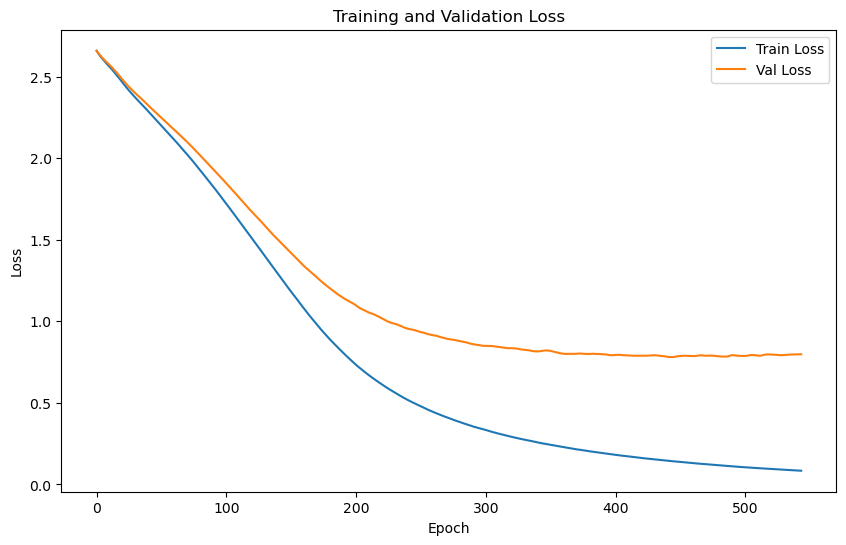

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.7808 | Test Accuracy: 77.22%


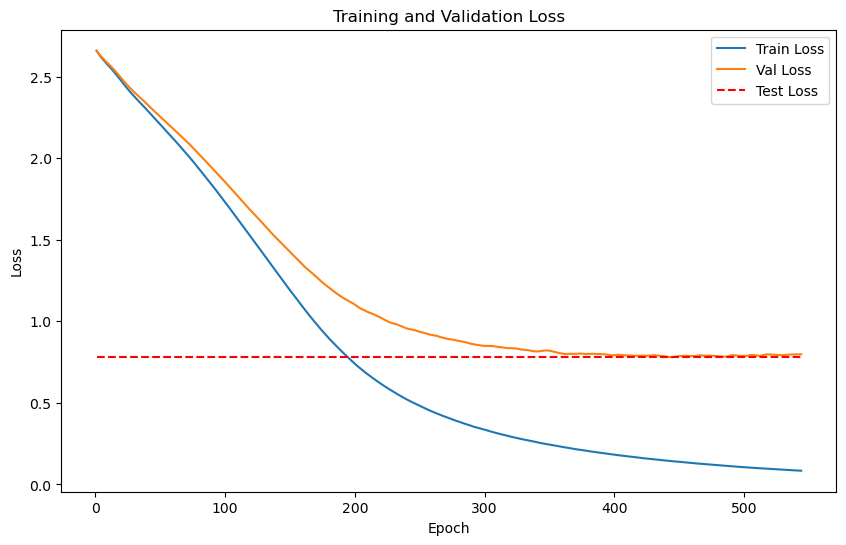

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


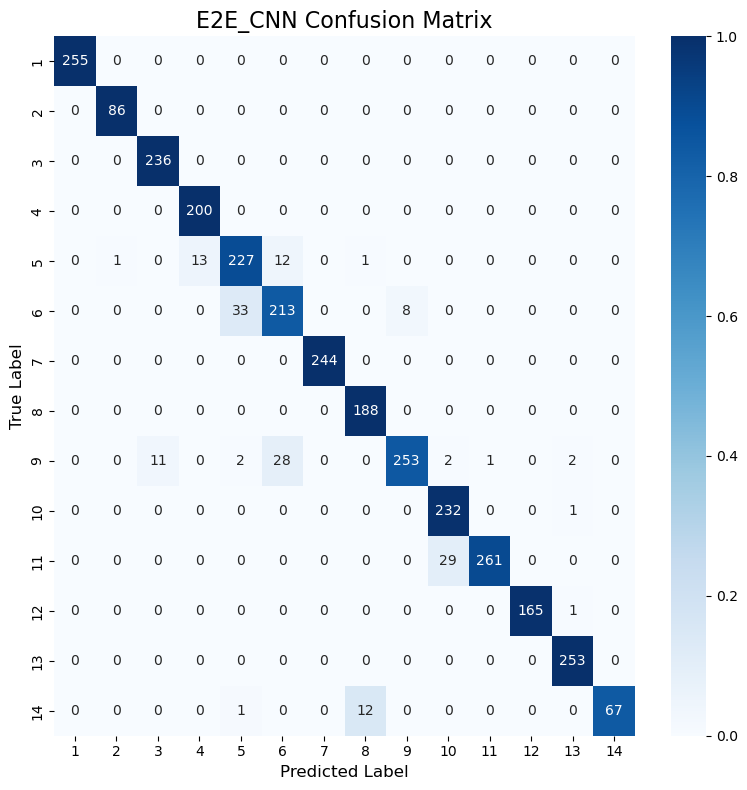

Classification Accuracy: 94.80%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


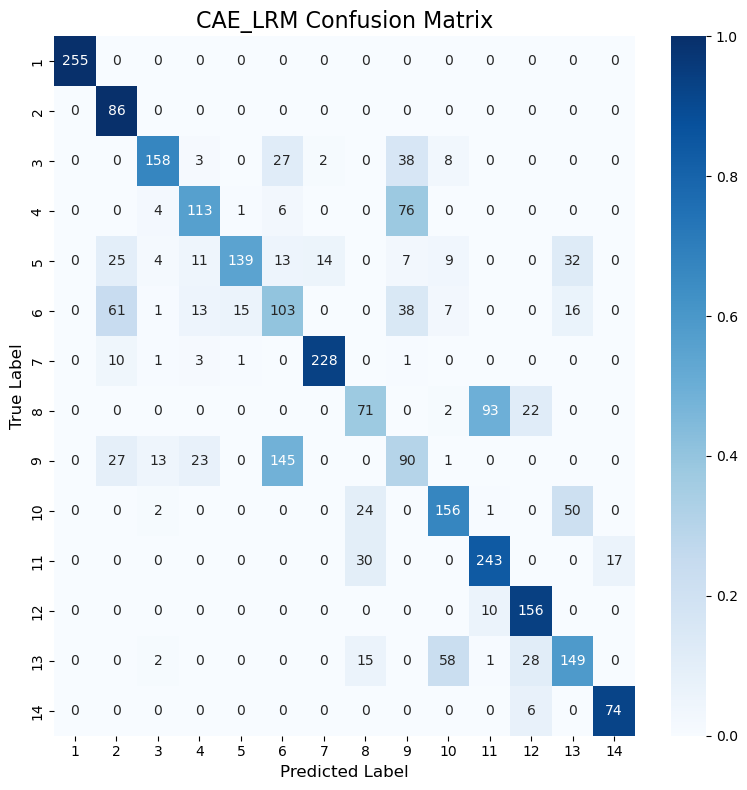

Classification Accuracy: 66.52%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


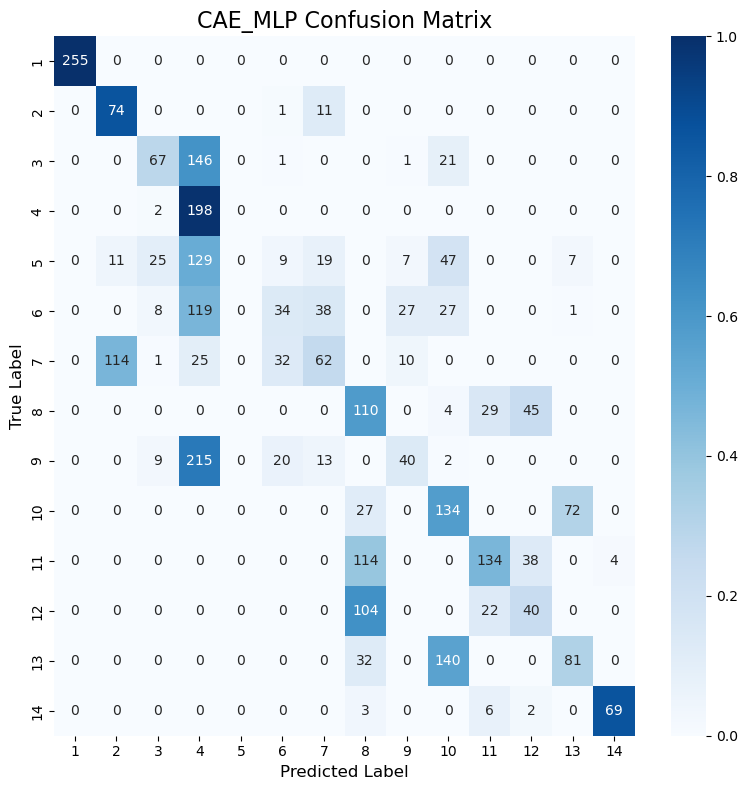

Classification Accuracy: 42.73%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


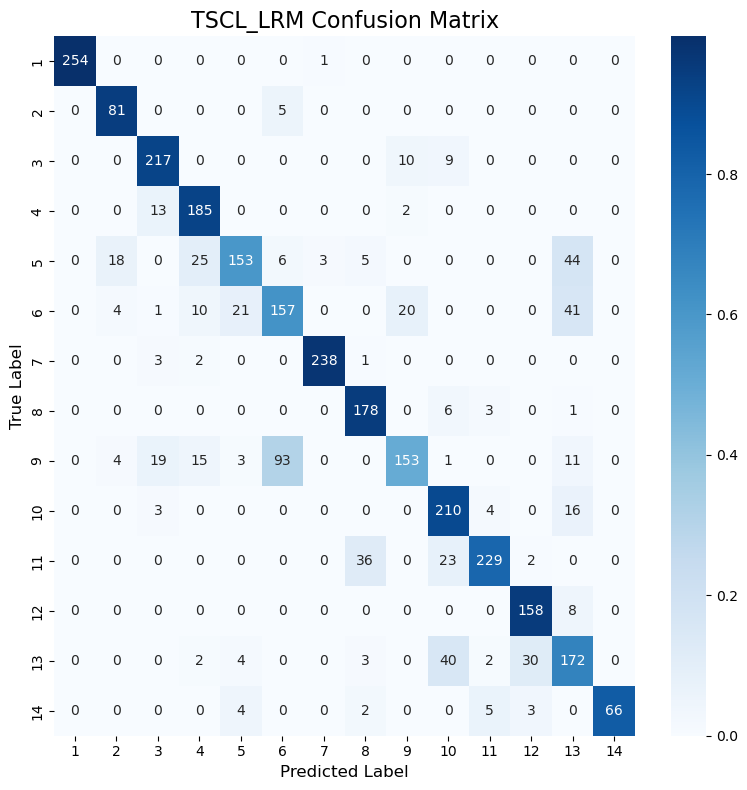

Classification Accuracy: 80.68%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


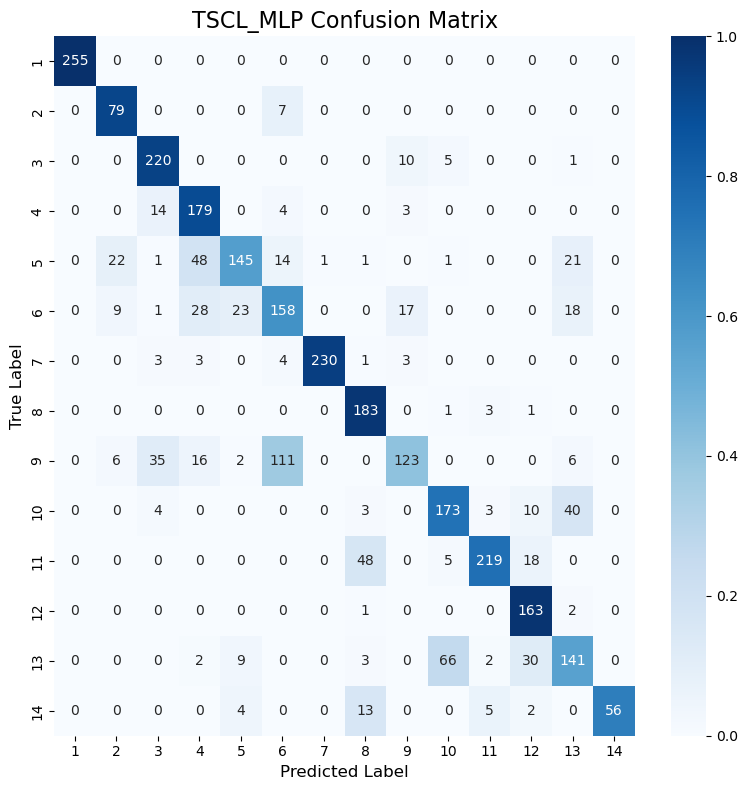

Classification Accuracy: 76.50%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


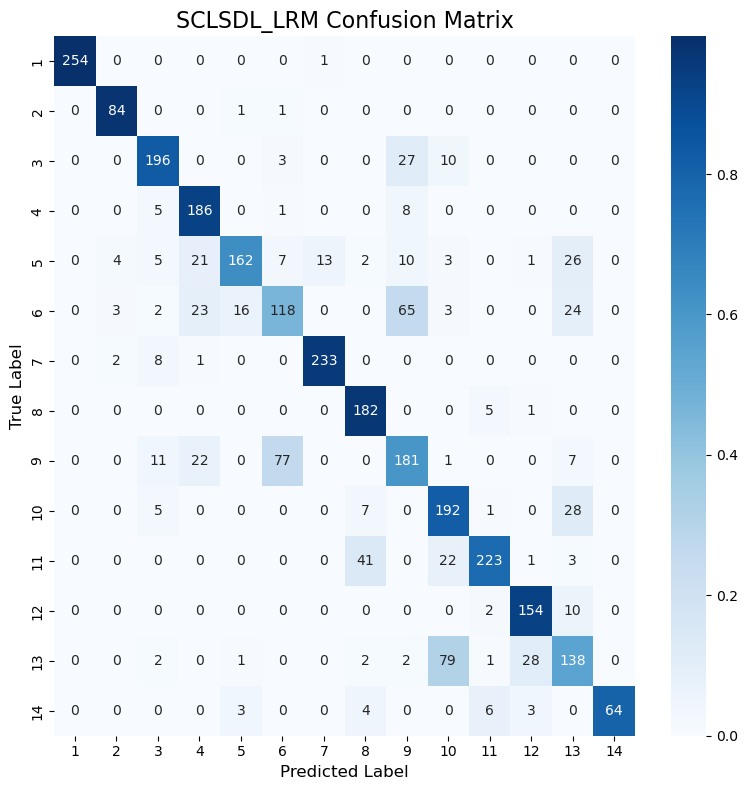

Classification Accuracy: 77.91%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


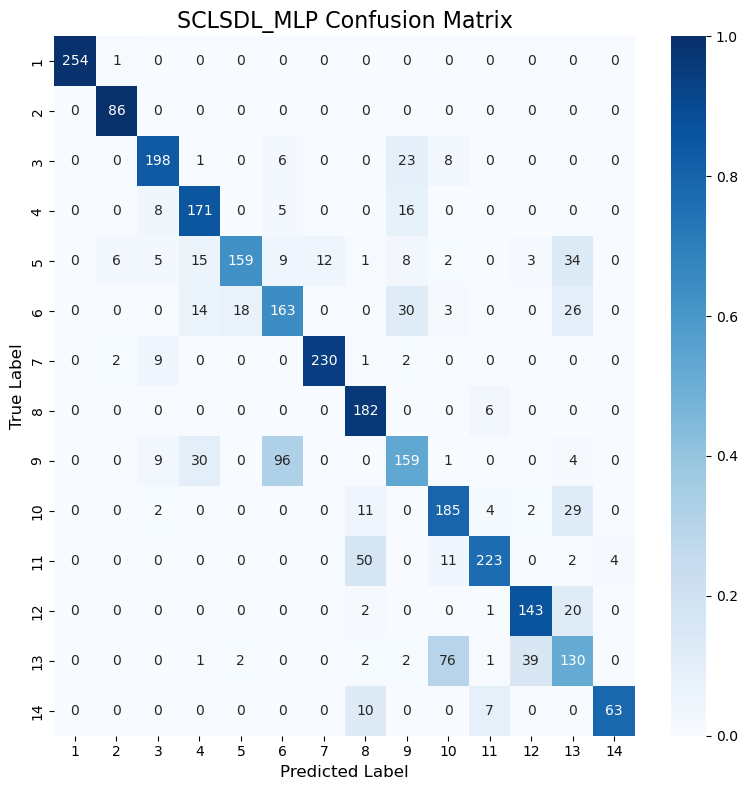

Classification Accuracy: 77.22%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          94.80
1    LRM (CAE)          66.52
2    MLP (CAE)          42.73
3     TSCL LRM          80.68
4     TSCL MLP          76.50
5  SCL_SDL LRM          77.91
6  SCL_SDL MLP          77.22

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          94.80
3     TSCL LRM          80.68
5  SCL_SDL LRM          77.91
6  SCL_SDL MLP          77.22
4     TSCL MLP          76.50
1    LRM (CAE)          66.52
2    MLP (CAE)          42.73
